In [1]:
import os
import re
import gzip
import pickle
import joblib
import lime
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import lime.lime_tabular
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import Image
from imblearn.over_sampling import SMOTE
from glob import glob
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, f1_score, auc, roc_auc_score, fbeta_score, make_scorer, recall_score, precision_score, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors

from keras.models import Sequential, save_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout
from keras.callbacks import Callback, ModelCheckpoint
from keras.metrics import Metric, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, Precision, Recall

path = os.getcwd()

# conda install -c conda-forge imbalanced-learn
# conda install -c conda-forge hyperopt
# https://github.com/hyperopt/hyperopt-sklearn
# https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf
# conda install -c conda-forge mljar-supervised
# https://catboost.ai/docs/installation/python-installation-method-conda-install.html
# conda install -c conda-forge lime
# conda install -c conda-forge tensorflow
# conda install -c conda-forge keras

### Schéma de relation entre les fichiers
kernel de référence:
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition

In [12]:
# Fichiers csv à disposition, arborescence de dossiers sous Windows
csv_files = glob(path + '/fichiers_csv/*.{}'.format('csv'))
display([files.split('\\')[-1] for files in csv_files])

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

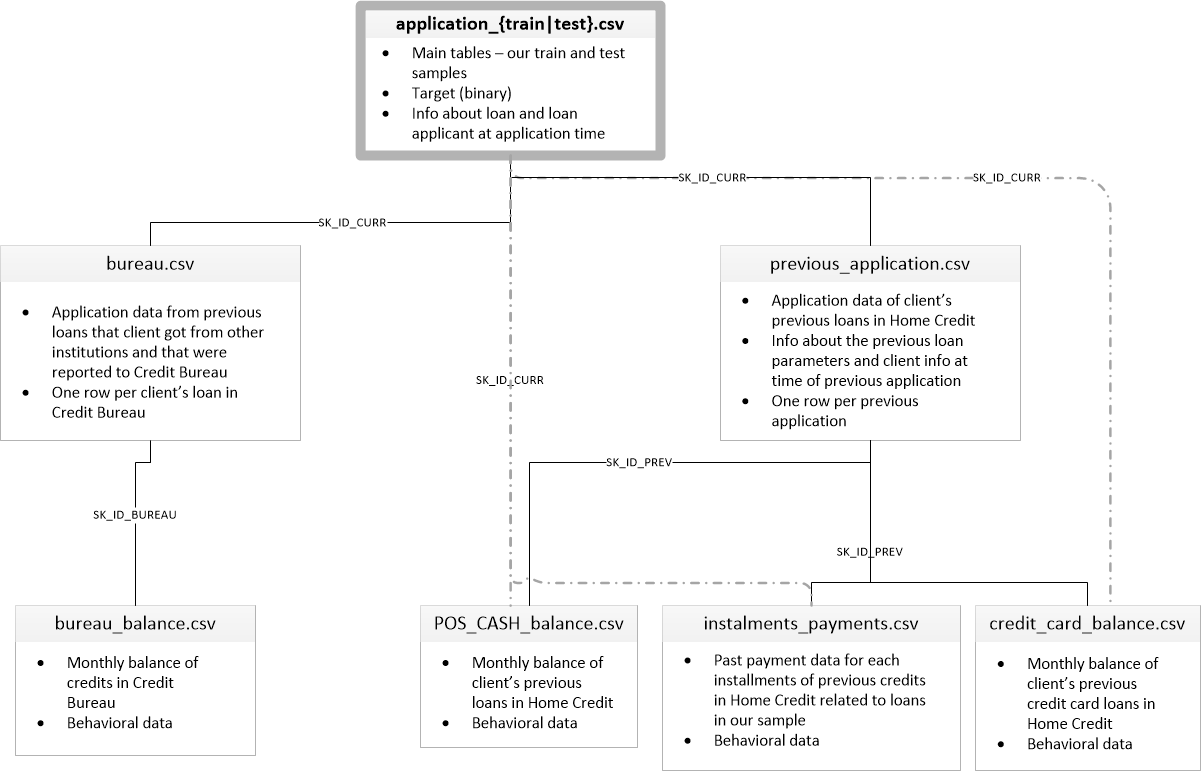

In [8]:
Image(path + '/image/home_credit.png')

In [13]:
# Fichier de référence d'explication des colonnes
df_HomeCredit_columns_description = pd.read_csv(path + '/fichiers_csv/HomeCredit_columns_description.csv', sep=',', encoding='ISO-8859-1')

In [14]:
df_HomeCredit_columns_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   219 non-null    int64 
 1   Table        219 non-null    object
 2   Row          219 non-null    object
 3   Description  219 non-null    object
 4   Special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


In [15]:
with pd.option_context('display.max_rows', None):
    display(df_HomeCredit_columns_description.style.set_properties(subset=['Description', 'Special'], **{'width': '300px'}))

### Observations des fichiers : application_test.csv et application_train.csv
Description : Prêts de Home Credit.<br />
Chaque prêt possède un identifiant unique "SK_ID_CURR"<br />
Le fichier application_training.csv possède une colonne "TARGET" : 0 -> remboursement, 1 -> défaut de remboursement du prêt.

In [16]:
# Chargement du dataframe application (train/test)
df_application_test = pd.read_csv(path + '/fichiers_csv/application_test.csv', sep=',', encoding='utf-8')
df_application_train = pd.read_csv(path + '/fichiers_csv/application_train.csv', sep=',', encoding='utf-8')

In [17]:
print(df_application_train.shape)
print(df_application_test.shape)

(307511, 122)
(48744, 121)


In [18]:
# vérification: que l'on a pas les mêmes SK_ID_CURR entre les deux fichiers
# le résultat doit être égal au nombre d'entrées de df_application_train
len(set(df_application_train['SK_ID_CURR'].unique()) - set(df_application_test['SK_ID_CURR'].unique()))

307511

In [19]:
df_application_train['SK_ID_CURR'].head()

0    100002
1    100003
2    100004
3    100006
4    100007
Name: SK_ID_CURR, dtype: int64

In [20]:
df_application_train[df_application_train['SK_ID_CURR'] == 100003]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
1      100003       0         Cash loans           F            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
1               N             0          270000.0   1293502.5      35698.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
1  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
1                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
1                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
1                        0.0                         0.0  

[1 rows x 122 columns]

In [21]:
print(df_application_test.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    NAME_CONTRACT_TYPE            object 
 2    CODE_GENDER                   object 
 3    FLAG_OWN_CAR                  object 
 4    FLAG_OWN_REALTY               object 
 5    CNT_CHILDREN                  int64  
 6    AMT_INCOME_TOTAL              float64
 7    AMT_CREDIT                    float64
 8    AMT_ANNUITY                   float64
 9    AMT_GOODS_PRICE               float64
 10   NAME_TYPE_SUITE               object 
 11   NAME_INCOME_TYPE              object 
 12   NAME_EDUCATION_TYPE           object 
 13   NAME_FAMILY_STATUS            object 
 14   NAME_HOUSING_TYPE             object 
 15   REGION_POPULATION_RELATIVE    float64
 16   DAYS_BIRTH                    int64  
 17   DAYS_EMPLOYED                 int64  
 18   DAYS

In [22]:
print(df_application_train.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [23]:
# 'display.max_rows', None
with pd.option_context('display.max_columns', None):
    display(df_application_test.head())

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

In [24]:
with pd.option_context('display.max_columns', None):
    display(df_application_train.head())

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

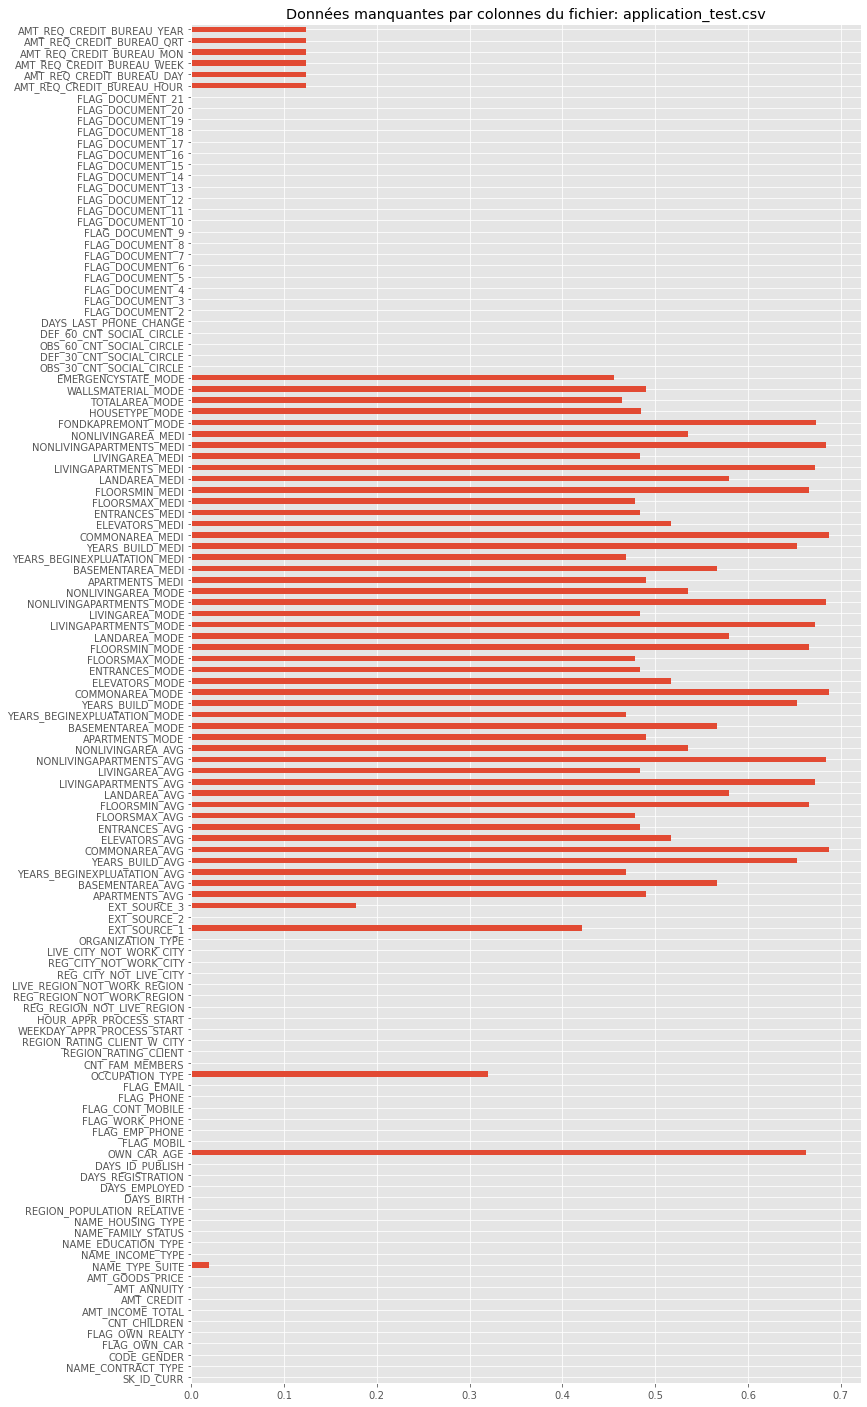

In [26]:
# On regarde les données manquantes sur df_application_test
plt.style.use('ggplot')
plt.figure(figsize=(12,25))
ax = df_application_test.isna().sum().div(len(df_application_test)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: application_test.csv")
plt.show()

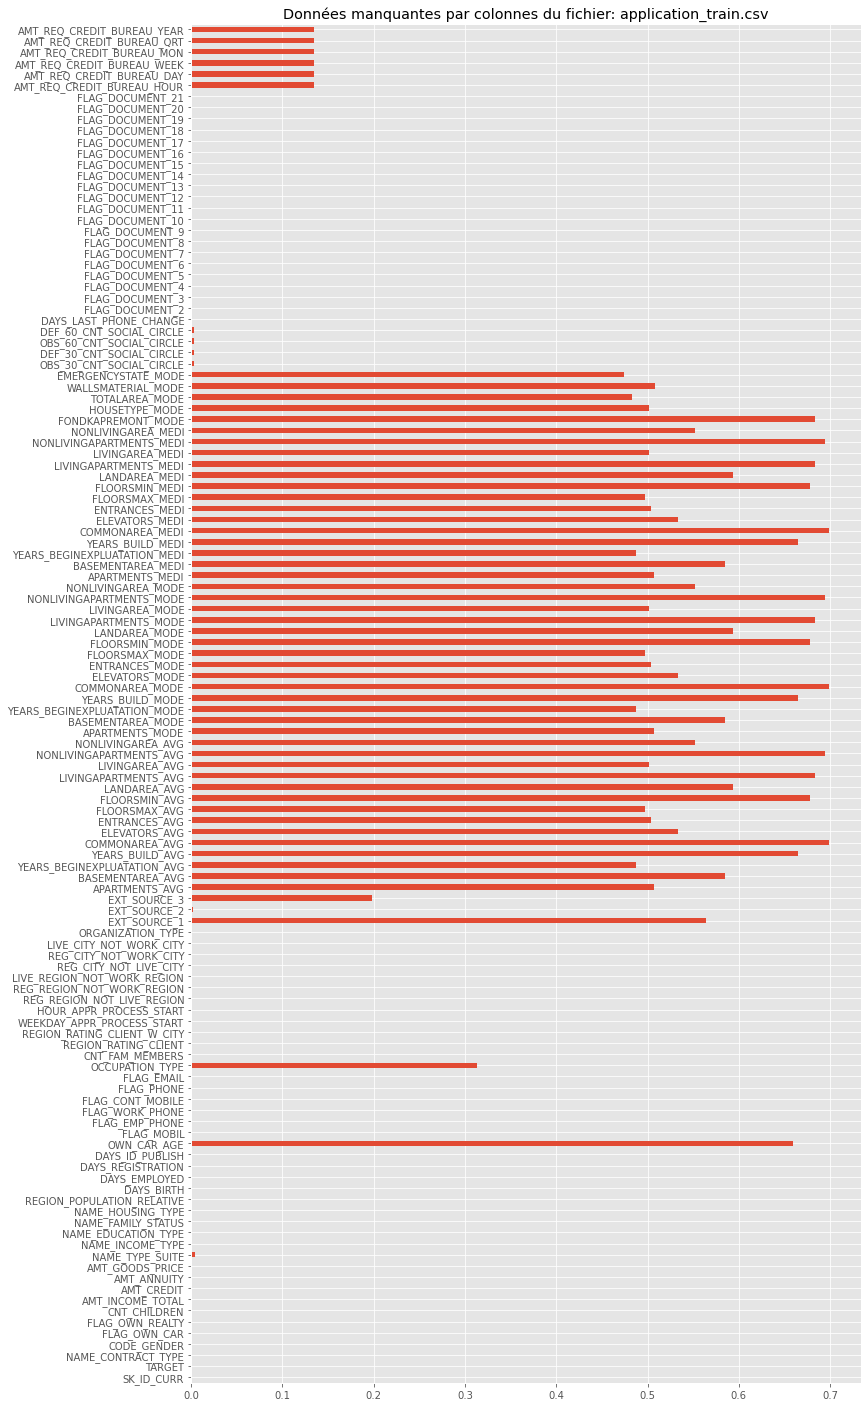

In [27]:
# On regarde les données manquantes sur df_application_train
plt.style.use('ggplot')
plt.figure(figsize=(12,25))
ax = df_application_train.isna().sum().div(len(df_application_train)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: application_train.csv")
plt.show()

In [28]:
# Vérification si les "SK_ID_CURR" sont biens uniques ?
print("df_application_test ID uniques ? : ", len(df_application_test['SK_ID_CURR'].unique()) == len(df_application_test))
print("df_application_train ID uniques ? : ", len(df_application_train['SK_ID_CURR'].unique()) == len(df_application_train))

df_application_test ID uniques ? :  True
df_application_train ID uniques ? :  True


In [29]:
# rappel des dimensions
print("df_application_test.shape : ", df_application_test.shape)
print("df_application_train.shape : ", df_application_train.shape) # colonne TARGET en plus

df_application_test.shape :  (48744, 121)
df_application_train.shape :  (307511, 122)


In [30]:
# Vérification différence des colonnes (Intégrité)
print(list(set(df_application_train.columns) - set(df_application_test.columns)))

['TARGET']


### Observation du fichier: previous_application.csv
Description: Dossiers précédents de demande de prêt chez Home Credit pour un client<br />
Une ligne correspond à un dossier client. Et un client peut avoir plusieurs dossiers (lignes)<br />
Informations avec de nombreux paramètres.

In [31]:
df_previous_application = pd.read_csv(path + '/fichiers_csv/previous_application.csv', sep=',', encoding='utf-8')

In [32]:
df_previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [33]:
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

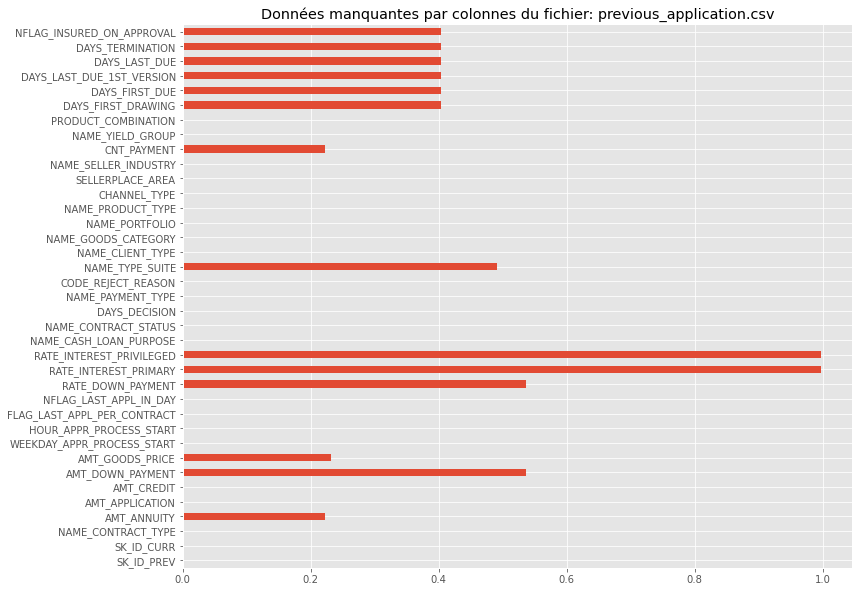

In [34]:
plt.figure(figsize=(12,10))
ax = df_previous_application.isna().sum().div(len(df_previous_application)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: previous_application.csv")
plt.show()

In [35]:
# Clients (SK_ID_CURR) ayant le plus de dossiers de prêts chez Home Credit:
ps_max_customer_app = pd.Series(df_previous_application.groupby('SK_ID_CURR')['SK_ID_CURR'].count())
ps_max_customer_app.sort_values(ascending=False)[:5]

SK_ID_CURR
187868    77
265681    73
173680    72
242412    68
206783    67
Name: SK_ID_CURR, dtype: int64

### Observation du fichier: POS_CASH_balance.csv
Description: Balance mensuelle des précédents prêts pour un client chez Home Credit + données de comportements.<br />
Lié au fichier application_train_test.csv par la clé SK_ID_CURR et au fichier previous_application.csv par SK_ID_PREV<br />
Pour un client, un ancien dossier de prét SK_ID_PREV on peut avoir plusieurs mois de balance.<br />
Ce qui donne : 1 client (SK_ID_CURR) -> 1 ou n dossier antérieur (SK_ID_PREV) -> 1 à n Balance mensuelle<br />
1 ligne = 1 balance mensuelle

In [36]:
df_pos_cash_balance = pd.read_csv(path + '/fichiers_csv/POS_CASH_balance.csv', sep=',', encoding='utf-8')

In [37]:
df_pos_cash_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [38]:
df_pos_cash_balance.sort_values(by='SK_ID_CURR').head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
8531326     1851984      100001             -94             4.0   
1891462     1851984      100001             -95             4.0   
8789081     1369693      100001             -56             4.0   
4704415     1369693      100001             -54             4.0   
7167007     1369693      100001             -57             4.0   

         CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
8531326                    0.0               Active       0           0  
1891462                    1.0               Active       7           7  
8789081                    3.0               Active       0           0  
4704415                    1.0               Active       0           0  
7167007                    4.0               Active       0           0

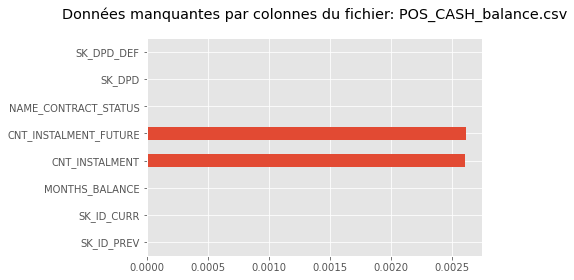

In [39]:
ax = df_pos_cash_balance.isna().sum().div(len(df_pos_cash_balance)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: POS_CASH_balance.csv", pad=20)
plt.show()

### Observation du fichier: installments_payments.csv
Description: Paiements pour chaque previous_application d'un client ?

In [40]:
df_installments_payments = pd.read_csv(path + '/fichiers_csv/installments_payments.csv', sep=',', encoding='utf-8')

In [41]:
df_installments_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [42]:
df_installments_payments.sort_values(by='SK_ID_CURR').head(25)

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
3458712     1369693      100001                     1.0   
3435373     1851984      100001                     1.0   
2624024     1369693      100001                     2.0   
1761012     1851984      100001                     1.0   
3774071     1851984      100001                     1.0   
1478621     1369693      100001                     1.0   
2568722     1369693      100001                     1.0   
2163032     1038818      100002                     1.0   
504426      1038818      100002                     1.0   
699804      1038818      100002                     1.0   
1675768     1038818      100002                     1.0   
3594829     1038818      100002                     1.0   
210205      1038818      100002                     1.0   
2144879     1038818      100002                     1.0   
2785201     1038818      100002                     1.0   
1703436     1038818      100002                     1.0   
185679      1038818      100002                     1.0   
3343696     1038818      100002                     1.0   
1807424     1038818      100002                     1.0   
2841063     1038818      100002                     1.0   
916044      1038818      100002                     1.0   
442432      1038818      100002                     2.0   
2646927     1038818      100002                     1.0   
1390511     1038818      100002                     1.0   
740300      1038818      100002                     1.0   

         NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
3458712                      3          -1649.0             -1660.0   
3435373                      4          -2856.0             -2856.0   
2624024                      4          -1619.0             -1628.0   
1761012                      2          -2916.0             -2916.0   
3774071                      3          -2886.0             -2875.0   
1478621                      1          -1709.0             -1715.0   
2568722                      2          -1679.0             -1715.0   
2163032                      2           -535.0              -562.0   
504426                      12           -235.0              -250.0   
699804                      13           -205.0              -224.0   
1675768                      3           -505.0              -529.0   
3594829                      7           -385.0              -412.0   
210205                       8           -355.0              -375.0   
2144879                      1           -565.0              -587.0   
2785201                     11           -265.0              -284.0   
1703436                     15           -145.0              -160.0   
185679                      16           -115.0              -133.0   
3343696                      4           -475.0              -498.0   
1807424                      6           -415.0              -446.0   
2841063                      5           -445.0              -468.0   
916044                      17            -85.0               -99.0   
442432                      19            -25.0               -49.0   
2646927                     10           -295.0              -312.0   
1390511                     18            -55.0               -67.0   
740300                      14           -175.0              -194.0   

         AMT_INSTALMENT  AMT_PAYMENT  
3458712        3951.000     3951.000  
3435373        3980.925     3980.925  
2624024       17397.900    17397.900  
1761012        3982.050     3982.050  
3774071        3982.050     3982.050  
1478621        3951.000     3951.000  
2568722        3951.000     3951.000  
2163032        9251.775     9251.775  
504426         9251.775     9251.775  
699804         9251.775     9251.775  
1675768        9251.775     9251.775  
3594829        9251.775     9251.775  
210205         9251.775     9251.775  
2144879        9251.775     9251.775  
2785201        9251.775     9251.775  
170

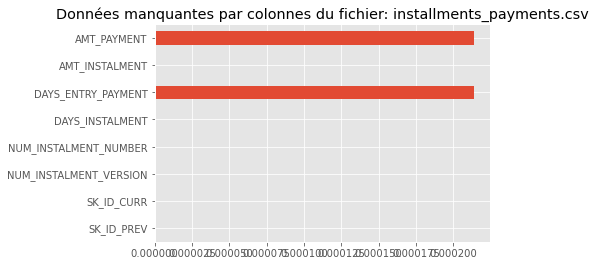

In [43]:
ax = df_installments_payments.isna().sum().div(len(df_installments_payments)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: installments_payments.csv")
plt.show()

### Observation du fichier: credit_card_balance.csv
Description: Balance mensuelle des cartes de crédit précédentes des clients chez Home Credit.

In [44]:
df_credit_card_balance = pd.read_csv(path + '/fichiers_csv/credit_card_balance.csv', sep=',', encoding='utf-8')

In [45]:
df_credit_card_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

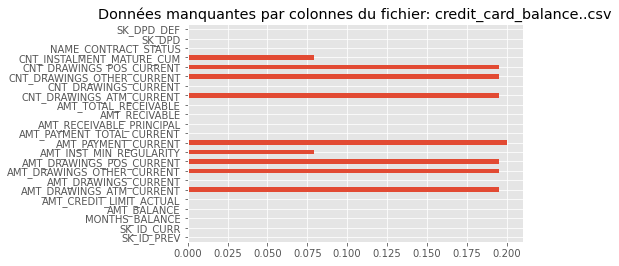

In [46]:
ax = df_credit_card_balance.isna().sum().div(len(df_credit_card_balance)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: credit_card_balance..csv")
plt.show()

### Observation du fichier : bureau.csv
Description: Prêts précédents des clients provenant d'autres institutions que Home Credit.<br />
Note : Un même client peut avoir plusieurs prêts. (clé étrangère: ID_SK_CURR)<br />
Une ligne = Un prêt client

In [47]:
df_bureau = pd.read_csv(path + '/fichiers_csv/bureau.csv', sep=',', encoding='utf-8')

In [48]:
df_bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [49]:
df_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

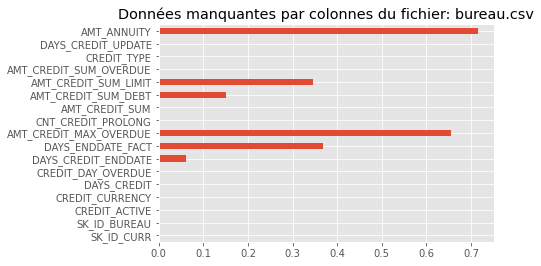

In [50]:
ax = df_bureau.isna().sum().div(len(df_bureau)).plot.barh()
plt.title("Données manquantes par colonnes du fichier: bureau.csv")
plt.show()

In [51]:
# D'après la définition, on a plus de SK_ID_CURR que de SK_ID_CURR uniques, vérifions :
print("SK_ID_CURR uniques :", len(df_bureau['SK_ID_CURR'].unique()))
print("SK_ID_CURR total :", len(df_bureau))

SK_ID_CURR uniques : 305811
SK_ID_CURR total : 1716428


In [52]:
# Le client qui a le plus de prêts antérieurs ?
ps_max_sk_id_curr = pd.Series(df_bureau.groupby('SK_ID_CURR')['SK_ID_CURR'].count())
# Les 5 premiers clients avec le plus de crédits
ps_max_sk_id_curr.sort_values(ascending=False)[:5]

SK_ID_CURR
120860    116
169704     94
318065     78
251643     61
425396     60
Name: SK_ID_CURR, dtype: int64

### Observations du fichier: bureau_balance.csv
Description: Balance mensuelle d'un crédit.<br />
Donc un même crédit pour un même client peut avoir plusieurs lignes correspondant à la balance de son crédit sur plusieurs mois.<br />
Un client qui possède plusieurs crédits peut donc avec avoir pour chaque crédit plusieurs lignes propre à chacun.

In [53]:
df_bureau_balance = pd.read_csv(path + '/fichiers_csv/bureau_balance.csv', sep=',', encoding='utf-8')

In [54]:
df_bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [55]:
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

### EDA

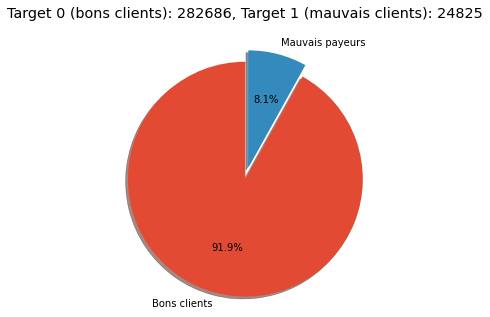

In [56]:
# Proportion des bons et mauvais clients (TARGET)
labels = ['Bons clients', 'Mauvais payeurs']
fig1, ax = plt.subplots(figsize=(6,5))
ax.pie(
    df_application_train['TARGET'].value_counts(),
    explode=(0, 0.1),
    labels=labels,
    autopct='%1.1f%%',
    shadow=True,
    startangle=90
)

ax.axis('equal')
plt.title(
    "Target 0 (bons clients): {}, Target 1 (mauvais clients): {}"\
    .format(df_application_train['TARGET'].value_counts()[0], 
            df_application_train['TARGET'].value_counts()[1]),
    pad=20
)
plt.show()

### Opérations sur dataframe df_application_train/test

In [57]:
# Ajout de ["YEARS_BIRTH"] à partir de ['DAYS_BIRTH']
df_application_train['YEARS_BIRTH'] = df_application_train['DAYS_BIRTH'] / -365
df_application_test['YEARS_BIRTH'] = df_application_test['DAYS_BIRTH'] / -365

In [58]:
print(df_application_train['YEARS_BIRTH'].describe(), '\n')
print(df_application_test['YEARS_BIRTH'].describe())

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: YEARS_BIRTH, dtype: float64 

count    48744.000000
mean        44.022150
std         11.851782
min         20.104110
25%         34.235616
50%         43.246575
75%         53.800000
max         69.027397
Name: YEARS_BIRTH, dtype: float64


In [59]:
# Inspection de la colonne ['DAYS_EMPLOYED']
df_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [60]:
# Travaille depuis 1000 ans ?
df_application_train['DAYS_EMPLOYED'].max() / 365

1000.6657534246575

In [61]:
#0.9% des clients avec plus de 1000 ans de travail et classé en mauvais clients (TARGET =1)
df_application_train[['TARGET']][df_application_train['DAYS_EMPLOYED'] == 365243].sum() / len(df_application_train)

TARGET    0.009723
dtype: float64

In [62]:
df_application_train[(df_application_train['DAYS_EMPLOYED'] == 365243)].shape[0]

55374

In [63]:
df_application_train[(df_application_train['DAYS_EMPLOYED'] == 365243) & (df_application_train['TARGET'] == 1)].shape[0]

2990

In [64]:
# Création d'une colonne indiquant si c'est une anomalie ou non
df_application_train['DAYS_EMPLOYED_ANOMALIE'] = df_application_train['DAYS_EMPLOYED'] == 365243 # Ce qui donne True/False
# On replace les valeurs 365243 par np.NaN pour le machine learning ensuite
df_application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

In [65]:
# On fait la même chose pour le jeu de test
df_application_test['DAYS_EMPLOYED_ANOMALIE'] = df_application_test['DAYS_EMPLOYED'] == 365243 # Ce qui donne True/False
# On replace les valeurs 365243 par np.NaN pour le machine learning ensuite
df_application_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


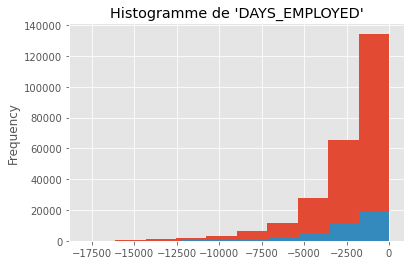

In [66]:
# contrôles
print(df_application_train['DAYS_EMPLOYED'].plot.hist())
print(df_application_test['DAYS_EMPLOYED'].plot.hist())
plt.title("Histogramme de 'DAYS_EMPLOYED'")
plt.show()

#### Inpection des variables

In [67]:
def is_possible_influence_cat(col_cat):
    
    for cat in df_application_train[col_cat].unique():
        print(cat, ":")
        print("Mauvais payeurs (%) :", (
            df_application_train[(df_application_train[col_cat] == cat) & (df_application_train['TARGET'] == 1)].shape[0] \
              / len(df_application_train[df_application_train['TARGET'] == 1]) ) * 100
        )
        print("Bons payeurs (%) :",  (
            df_application_train[(df_application_train[col_cat] == cat) & (df_application_train['TARGET'] == 0)].shape[0] \
              / len(df_application_train[df_application_train['TARGET'] == 0]) ) * 100, "\n"
        )
    
    return None

In [68]:
# NAME_CONTRACT_TYPE: Identification si prêt en espèces ou renouvelable -> Catégories -> OUI -> Catégorie
# INFLUENCE POSSIBLE -> OUI
print(df_application_train['NAME_CONTRACT_TYPE'].unique())
print(df_application_train['NAME_CONTRACT_TYPE'].isna().sum())
is_possible_influence_cat('NAME_CONTRACT_TYPE')

['Cash loans' 'Revolving loans']
0
Cash loans :
Mauvais payeurs (%) : 93.53877139979859
Bons payeurs (%) : 90.20998563777476 

Revolving loans :
Mauvais payeurs (%) : 6.4612286002014105
Bons payeurs (%) : 9.790014362225225 



In [69]:
# CODE_GENDER -> OUI -> Catégorie
print(df_application_train['CODE_GENDER'].unique())
print(df_application_train['CODE_GENDER'].isna().sum())
is_possible_influence_cat('CODE_GENDER')

['M' 'F' 'XNA']
0
M :
Mauvais payeurs (%) : 42.92044310171199
Bons payeurs (%) : 33.395357393008496 

F :
Mauvais payeurs (%) : 57.07955689828802
Bons payeurs (%) : 66.60322760943237 

XNA :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0014149975591292105 



In [70]:
# FLAG_OWN_CAR -> OUI -> Catégorie
print(df_application_train['FLAG_OWN_CAR'].unique())
print(df_application_train['FLAG_OWN_CAR'].isna().sum())
is_possible_influence_cat('FLAG_OWN_CAR')

['N' 'Y']
0
N :
Mauvais payeurs (%) : 69.48237663645519
Bons payeurs (%) : 65.68241794782904 

Y :
Mauvais payeurs (%) : 30.517623363544814
Bons payeurs (%) : 34.317582052170955 



In [71]:
# FLAG_OWN_REALTY -> OUI -> Catégorie -> Si client possède appartement ou maison
print(df_application_train['FLAG_OWN_REALTY'].unique())
print(df_application_train['FLAG_OWN_REALTY'].isna().sum())
is_possible_influence_cat('FLAG_OWN_REALTY')

['Y' 'N']
0
Y :
Mauvais payeurs (%) : 68.41087613293051
Bons payeurs (%) : 69.4512639465697 

N :
Mauvais payeurs (%) : 31.589123867069485
Bons payeurs (%) : 30.548736053430307 



In [85]:
def is_possible_influence_graph(col_values, graph_type='plot'):
    
    good_customers_perc_values_list = []
    bad_customers_perc_values_list = []
    
    for value in df_application_train[col_values].unique():
        if not np.isnan(value):
            bad_customers = (df_application_train[(df_application_train[col_values] == value) & (df_application_train['TARGET'] == 1)].shape[0] \
            / len(df_application_train[df_application_train['TARGET'] == 1]) ) * 100
            bad_customers_perc_values_list.append(bad_customers)

            good_customers = (df_application_train[(df_application_train[col_values] == value) & (df_application_train['TARGET'] == 0)].shape[0] \
            / len(df_application_train[df_application_train['TARGET'] == 0]) ) * 100
            good_customers_perc_values_list.append(good_customers)
    
    plt.style.use('ggplot')
    plt.figure(figsize=(12,10))
    
    unique_values = [value for value in df_application_train[col_values].unique() if not np.isnan(value)]
    if graph_type == 'plot':
        plt.plot(unique_values, bad_customers_perc_values_list, c='r', marker="o")
        plt.plot(unique_values, good_customers_perc_values_list, c='g', marker="o")
    elif graph_type == 'scatter':
        plt.scatter(unique_values, bad_customers_perc_values_list, c='r', marker="o")
        plt.scatter(unique_values, good_customers_perc_values_list, c='g', marker="o")
        
    # print("bad_customers_perc_values_list", len(bad_customers_perc_values_list))
    # print("good_customers_perc_values_list", len(good_customers_perc_values_list))
    # print("unique_values", len(unique_values))
    
    if len(unique_values) < 25:
        plt.xticks(unique_values)
    plt.xlabel("Valeurs uniques de la colonne: '{}'".format(col_values))
    plt.ylabel("Pourcentage Bons et Mauvais clients")
    plt.title("Evolution du pourcentage de Bon/Mauvais clients en fonction des valeurs de: '{}'".format(col_values))
    
    return plt.show()

[ 0  1  2  3  4  7  5  6  8  9 11 12 10 19 14]
0


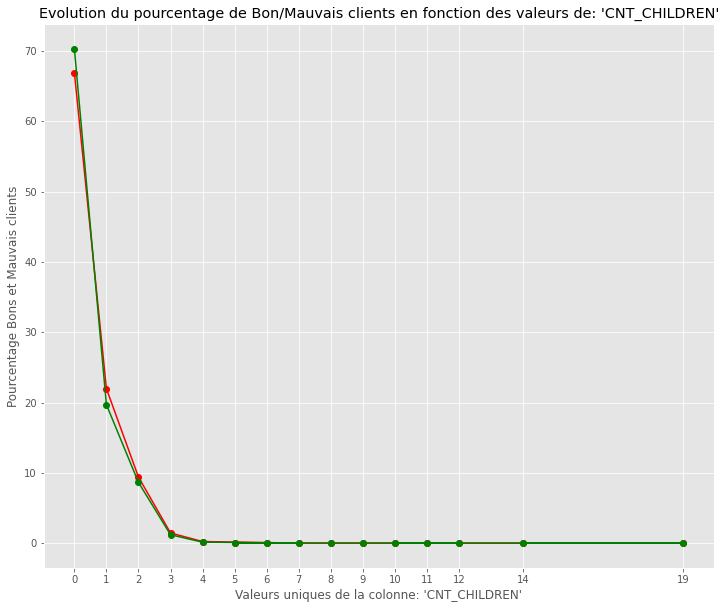

In [87]:
# CNT_CHILDREN -> OUI -> Number of children the client has
print(df_application_train['CNT_CHILDREN'].unique())
print(df_application_train['CNT_CHILDREN'].isna().sum())
is_possible_influence_graph('CNT_CHILDREN') # -> PAS D'INFLUENCE

In [74]:
# AMT_INCOME_TOTAL -> OUI -> Income of the client
print(df_application_train['AMT_INCOME_TOTAL'].unique())
print(df_application_train['AMT_INCOME_TOTAL'].isna().sum())
# is_possible_influence_graph('AMT_INCOME_TOTAL') -> à définir

[202500.  270000.   67500.  ...  96768.  546250.5 113062.5]
0


In [75]:
# AMT_CREDIT (=emprunt total du client ?) -> OUI -> Montant du crédit du prêt ???  -> PAS DE NAN
print(df_application_train['AMT_CREDIT'].unique())
print(df_application_train['AMT_CREDIT'].isna().sum())
print(df_application_train['AMT_CREDIT'].describe())
# is_possible_influence_graph('AMT_CREDIT')

[ 406597.5 1293502.5  135000.  ...  181989.   743863.5 1391130. ]
0
count    3.075110e+05
mean     5.990260e+05
std      4.024908e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64


In [76]:
# AMT_ANNUITY -> OUI -> Rente de prêt (intérêt par an du ?) -> 12 NAN
# (= intérêts à devoir sur l'emprunt ?) -> NAN = intérêts à zéro ? (imputation mean ?)
print(df_application_train['AMT_ANNUITY'].unique())
print(df_application_train['AMT_ANNUITY'].isna().sum())
print(df_application_train['AMT_ANNUITY'].describe())
display(df_application_train[df_application_train['AMT_ANNUITY'].isna()])
# is_possible_influence_graph('AMT_ANNUITY')

[24700.5 35698.5  6750.  ... 71986.5 58770.  77809.5]
12
count    307499.000000
mean      27108.573909
std       14493.737315
min        1615.500000
25%       16524.000000
50%       24903.000000
75%       34596.000000
max      258025.500000
Name: AMT_ANNUITY, dtype: float64


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
47531       155054       0         Cash loans           M            N   
50035       157917       0         Cash loans           F            N   
51594       159744       0         Cash loans           F            N   
55025       163757       0         Cash loans           F            N   
59934       169487       0         Cash loans           M            Y   
75873       187985       0         Cash loans           M            Y   
89343       203726       0         Cash loans           F            Y   
123872      243648       0         Cash loans           F            N   
207186      340147       0         Cash loans           M            N   
227939      364022       0         Cash loans           F            N   
239329      377174       0         Cash loans           F            N   
241835      379997       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
47531                N             0          180000.0    450000.0   
50035                N             0           94500.0    450000.0   
51594                N             0          202500.0    539100.0   
55025                N             0          162000.0    296280.0   
59934                N             0          202500.0    360000.0   
75873                N             0          144000.0    219249.0   
89343                N             0           90000.0    157500.0   
123872               Y             0          202500.0    929088.0   
207186               N             0          171000.0    486000.0   
227939               Y             0          315000.0    628069.5   
239329               Y             0          157500.0    792000.0   
241835               N             0          315000.0   1483231.5   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
47531           NaN  ...                 0                0   
50035           NaN  ...                 0                0   
51594           NaN  ...                 0                0   
55025           NaN  ...                 0                0   
59934           NaN  ...                 0                0   
75873           NaN  ...                 0                0   
89343           NaN  ...                 0                0   
123872          NaN  ...                 0                0   
207186          NaN  ...                 0                0   
227939          NaN  ...                 0                0   
239329          NaN  ...                 0                0   
241835          NaN  ...                 0                0   

       AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
47531                         0.0                       0.0   
50035                         0.0                       0.0   
51594                         0.0                       0.0   
55025                         0.0                       0.0   
59934                         0.0                       0.0   
75873                         0.0                       0.0   
89343                         0.0                       0.0   
123872                        0.0                       0.0   
207186                        0.0                       0.0   
227939                        0.0                       0.0   
239329                        0.0                       0.0   
241835                        NaN                       NaN   

       AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
47531                         0.0                       0.0   
50035                         0.0                       1.0   
51594                         0.0                       1.0   
55025                         0.0                       1.0   
59934                         1.0                       0.0   
75873                         0.0                       0.0   
89343                         0.0                    

In [77]:
# AMT_GOODS_PRICE -> OUI -> Pour les crédits à la consommation c'est le prix des biens pour lesquels le crédit est accordé  -> 278 NAN
# (On peut imputer par le prix du crédit total si on considère que le crédit a été demandé pour la totalité du prix des biens)
print(df_application_train['AMT_GOODS_PRICE'].unique())
print(df_application_train['AMT_GOODS_PRICE'].isna().sum())
display(df_application_train[['AMT_GOODS_PRICE', 'AMT_CREDIT']].describe()) # Imputation au crédit AMT_CREDIT OK
# is_possible_influence_graph('AMT_ANNUITY')

[ 351000.  1129500.   135000.  ...  453465.   143977.5  743863.5]
278


AMT_GOODS_PRICE    AMT_CREDIT
count     3.072330e+05  3.075110e+05
mean      5.383962e+05  5.990260e+05
std       3.694465e+05  4.024908e+05
min       4.050000e+04  4.500000e+04
25%       2.385000e+05  2.700000e+05
50%       4.500000e+05  5.135310e+05
75%       6.795000e+05  8.086500e+05
max       4.050000e+06  4.050000e+06

In [78]:
# NAME_TYPE_SUITE -> OUI -> Catégorie -> Qui accompagnait le client lors de sa demande de prêt -> 1292 NAN 
print(df_application_train['NAME_TYPE_SUITE'].unique())
print(df_application_train['NAME_TYPE_SUITE'].isna().sum())
# Pour les Nan -> Ajouter ['Unspecified']
is_possible_influence_cat('NAME_TYPE_SUITE') # NON

['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
1292
Unaccompanied :
Mauvais payeurs (%) : 81.9214501510574
Bons payeurs (%) : 80.72171950503385 

Family :
Mauvais payeurs (%) : 12.120845921450151
Bons payeurs (%) : 13.13825233651472 

Spouse, partner :
Mauvais payeurs (%) : 3.605236656596173
Bons payeurs (%) : 3.70552485796962 

Children :
Mauvais payeurs (%) : 0.9707955689828802
Bons payeurs (%) : 1.0704456534812476 

Other_A :
Mauvais payeurs (%) : 0.30614300100704933
Bons payeurs (%) : 0.27946201792801906 

nan :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0 

Other_B :
Mauvais payeurs (%) : 0.7009063444108762
Bons payeurs (%) : 0.564584026092555 

Group of people :
Mauvais payeurs (%) : 0.09264853977844914
Bons payeurs (%) : 0.08772984866601105 



In [79]:
# NAME_INCOME_TYPE -> OUI -> Catégorie -> Catégorie sociau-professionnelle de revenues
print(df_application_train['NAME_INCOME_TYPE'].unique())
print(df_application_train['NAME_INCOME_TYPE'].isna().sum())
is_possible_influence_cat('NAME_INCOME_TYPE') # OUI

['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
0
Working :
Mauvais payeurs (%) : 61.32527693856999
Bons payeurs (%) : 50.78072490324954 

State servant :
Mauvais payeurs (%) : 5.031218529707956
Bons payeurs (%) : 7.235590018607217 

Commercial associate :
Mauvais payeurs (%) : 21.591137965760325
Bons payeurs (%) : 23.438373318806025 

Pensioner :
Mauvais payeurs (%) : 12.012084592145015
Bons payeurs (%) : 18.52939303679701 

Unemployed :
Mauvais payeurs (%) : 0.032225579053373615
Bons payeurs (%) : 0.004952491456952237 

Student :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.006367489016081447 

Businessman :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0035374938978230265 

Maternity leave :
Mauvais payeurs (%) : 0.008056394763343404
Bons payeurs (%) : 0.001061248169346908 



In [80]:
# NAME_EDUCATION_TYPE -> OUI -> Catégorie -> Niveau d'études max. du client
print(df_application_train['NAME_EDUCATION_TYPE'].unique())
print(df_application_train['NAME_EDUCATION_TYPE'].isna().sum())
is_possible_influence_cat('NAME_EDUCATION_TYPE') # OUI

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
0
Secondary / secondary special :
Mauvais payeurs (%) : 78.64652567975831
Bons payeurs (%) : 70.34907989783717 

Higher education :
Mauvais payeurs (%) : 16.14904330312185
Bons payeurs (%) : 25.06455926363527 

Incomplete higher :
Mauvais payeurs (%) : 3.512588116817724
Bons payeurs (%) : 3.327013010902556 

Lower secondary :
Mauvais payeurs (%) : 1.6797583081570997
Bons payeurs (%) : 1.2023941758700467 

Academic degree :
Mauvais payeurs (%) : 0.012084592145015106
Bons payeurs (%) : 0.05695365175495072 



In [81]:
# NAME_FAMILY_STATUS -> OUI -> Catégorie 
print(df_application_train['NAME_FAMILY_STATUS'].unique())
print(df_application_train['NAME_FAMILY_STATUS'].isna().sum())
is_possible_influence_cat('NAME_FAMILY_STATUS') # OUI -> Mais pas marqué

['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
0
Single / not married :
Mauvais payeurs (%) : 17.953675730110774
Bons payeurs (%) : 14.499126239007238 

Married :
Mauvais payeurs (%) : 59.818731117824775
Bons payeurs (%) : 64.23452169545007 

Civil marriage :
Mauvais payeurs (%) : 11.927492447129909
Bons payeurs (%) : 9.485436137622663 

Widow :
Mauvais payeurs (%) : 3.774420946626385
Bons payeurs (%) : 5.359657004591667 

Separated :
Mauvais payeurs (%) : 6.525679758308158
Bons payeurs (%) : 6.420551424548792 

Unknown :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0007074987795646052 



In [82]:
# NAME_HOUSING_TYPE -> OUI -> Catégorie -> Type de logement -> PAS DE NAN
print(df_application_train['NAME_HOUSING_TYPE'].unique())
print(df_application_train['NAME_HOUSING_TYPE'].isna().sum())
is_possible_influence_cat('NAME_HOUSING_TYPE') # NON pas vraiment

['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
0
House / apartment :
Mauvais payeurs (%) : 85.68781470292043
Bons payeurs (%) : 89.00193147166821 

Rented apartment :
Mauvais payeurs (%) : 2.420946626384693
Bons payeurs (%) : 1.5140473882682552 

With parents :
Mauvais payeurs (%) : 6.992950654582075
Bons payeurs (%) : 4.635532003707294 

Municipal apartment :
Mauvais payeurs (%) : 3.8469284994964754
Bons payeurs (%) : 3.618148758693391 

Office apartment :
Mauvais payeurs (%) : 0.6928499496475328
Bons payeurs (%) : 0.8649172580177299 

Co-op apartment :
Mauvais payeurs (%) : 0.35850956696878145
Bons payeurs (%) : 0.3654231196451186 



[0.018801 0.003541 0.010032 0.008019 0.028663 0.035792 0.003122 0.018634
 0.019689 0.0228   0.015221 0.031329 0.016612 0.010006 0.020713 0.010966
 0.04622  0.025164 0.006296 0.026392 0.018029 0.019101 0.030755 0.008575
 0.01885  0.006207 0.009175 0.007305 0.007114 0.009334 0.022625 0.01452
 0.006629 0.00733  0.032561 0.00496  0.072508 0.009657 0.02461  0.003069
 0.020246 0.018209 0.009549 0.007274 0.002134 0.010276 0.003813 0.003818
 0.00712  0.0105   0.010147 0.010643 0.008866 0.00702  0.002506 0.005313
 0.006233 0.008474 0.005144 0.011657 0.008625 0.014464 0.004849 0.006008
 0.00963  0.005002 0.006852 0.011703 0.006305 0.010556 0.00823  0.006671
 0.002042 0.005084 0.008068 0.001333 0.001417 0.001276 0.000938 0.000533
 0.00029 ]
0


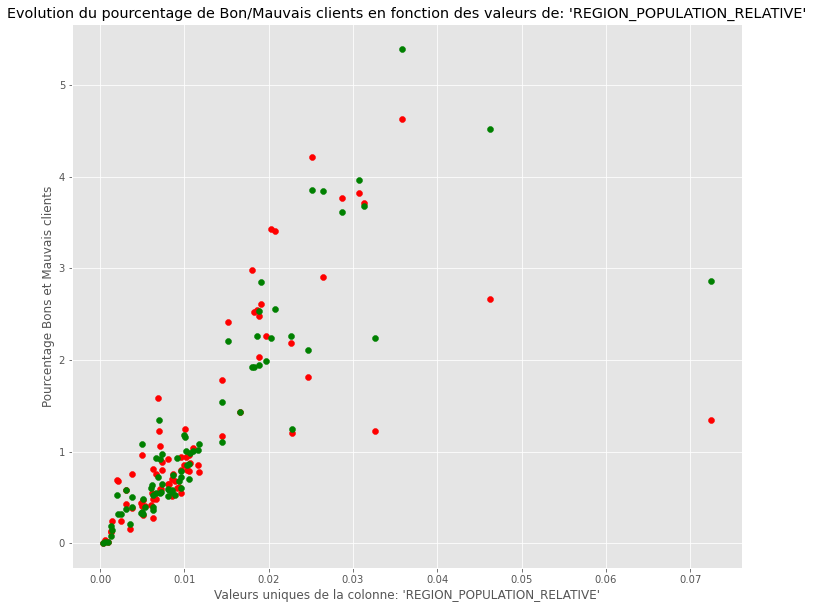

In [88]:
# REGION_POPULATION_RELATIVE -> Plus le chiffre est élevé plus le client vie dans une région peuplée... -> PAS DE NAN
print(df_application_train['REGION_POPULATION_RELATIVE'].unique())
print(df_application_train['REGION_POPULATION_RELATIVE'].isna().sum())
is_possible_influence_graph('REGION_POPULATION_RELATIVE', graph_type='scatter') # OUI

In [89]:
# DAYS_BIRTH -> OUI -> à remettre en année positive (/-365) -> pas de Nan
print(df_application_train['DAYS_BIRTH'].unique())
print(df_application_train['DAYS_BIRTH'].isna().sum())

[ -9461 -16765 -19046 ...  -7951  -7857 -25061]
0


In [90]:
# DAYS_EMPLOYED -> OUI -> How many days before the application the person started current employment -> à remttre en année (/-365)
print(df_application_train['DAYS_EMPLOYED'].unique())
print(df_application_train['DAYS_EMPLOYED'].isna().sum())

[  -637.  -1188.   -225. ... -12971. -11084.  -8694.]
55374


In [91]:
# DAYS_REGISTRATION -> OUI -> Combien de jours avant la demande le client a-t-il modifié son inscription -> PAS DE NAN
print(df_application_train['DAYS_REGISTRATION'].unique())
print(df_application_train['DAYS_REGISTRATION'].isna().sum())

[ -3648.  -1186.  -4260. ... -16396. -14558. -14798.]
0


In [92]:
# DAYS_ID_PUBLISH -> OUI -> Combien de jours avant la demande le client a-t-il changé la pièce d'identité avec laquelle il a demandé le prêt -> PAS DE NAN
print(df_application_train['DAYS_ID_PUBLISH'].unique())
print(df_application_train['DAYS_ID_PUBLISH'].isna().sum())

[-2120  -291 -2531 ... -6194 -5854 -6211]
0


In [93]:
# OWN_CAR_AGE -> OUI/NON -> Âge de la voiture du client -> 202929 NAN
print(df_application_train['OWN_CAR_AGE'].unique())
print(df_application_train['OWN_CAR_AGE'].isna().sum())

[nan 26. 17.  8. 23.  7. 14.  1.  3. 13. 10.  2. 21. 20. 22. 65.  5. 11.
  9.  4. 15. 12. 25.  6. 64.  0. 27. 19. 28. 18. 16. 30. 36. 24. 39. 29.
 40. 41. 31. 42. 37. 35. 34. 33. 54. 38. 32. 43. 55. 49. 44. 63. 46. 45.
 48. 56. 51. 57. 69. 50. 47. 91. 52.]
202929


In [94]:
# FLAG_MOBIL -> OUI -> Le client a-t-il fourni un numéro de téléphone -> PAS DE NAN
print(df_application_train['FLAG_MOBIL'].unique())
print(df_application_train['FLAG_MOBIL'].isna().sum())

[1 0]
0


In [95]:
# FLAG_EMP_PHONE -> OUI -> téléphone du domicile ? -> PAS DE NAN
print(df_application_train['FLAG_EMP_PHONE'].unique())
print(df_application_train['FLAG_EMP_PHONE'].isna().sum())

[1 0]
0


In [96]:
# FLAG_WORK_PHONE -> OUI -> téléphone du travail ? -> PAS DE NAN
print(df_application_train['FLAG_WORK_PHONE'].unique())
print(df_application_train['FLAG_WORK_PHONE'].isna().sum())

[0 1]
0


In [97]:
# FLAG_CONT_MOBILE -> OUI -> téléphone portable joignable ? -> PAS DE NAN
print(df_application_train['FLAG_CONT_MOBILE'].unique())
print(df_application_train['FLAG_CONT_MOBILE'].isna().sum())

[1 0]
0


In [98]:
# FLAG_PHONE -> doublon avec FLAG_EMP_PHONE -> PAS DE NAN
print(df_application_train['FLAG_PHONE'].unique())
print(df_application_train['FLAG_PHONE'].isna().sum())

[1 0]
0


In [99]:
# FLAG_EMAIL -> OUI -> Email du client -> PAS DE NAN
print(df_application_train['FLAG_EMAIL'].unique())
print(df_application_train['FLAG_EMAIL'].isna().sum())

[0 1]
0


In [100]:
# OCCUPATION_TYPE -> OUI -> Métier du client -> Imputation 'UNSPECIFIED'
print(df_application_train['OCCUPATION_TYPE'].unique())
print(df_application_train['OCCUPATION_TYPE'].isna().sum())
is_possible_influence_cat('OCCUPATION_TYPE') # NON pas marqué

['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
96391
Laborers :
Mauvais payeurs (%) : 23.516616314199396
Bons payeurs (%) : 17.45682488697707 

Core staff :
Mauvais payeurs (%) : 7.001007049345417
Bons payeurs (%) : 9.13805423685644 

Accountants :
Mauvais payeurs (%) : 1.9093655589123868
Bons payeurs (%) : 3.303665551176924 

Managers :
Mauvais payeurs (%) : 5.34944612286002
Bons payeurs (%) : 7.0901990194066915 

nan :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0 

Drivers :
Mauvais payeurs (%) : 8.487411883182276
Bons payeurs (%) : 5.835449933848865 

Sales staff :
Mauvais payeurs (%) : 12.455186304128903
Bons payeurs (%) : 10.2622697975846 

Cleaning staff :
Mauvais payeurs (%) : 1.8006042296072506
Bons payeurs (%) : 1.4878699334243648

[ 1.  2.  3.  4.  5.  6.  9.  7.  8. 10. 13. nan 14. 12. 20. 15. 16. 11.]
2


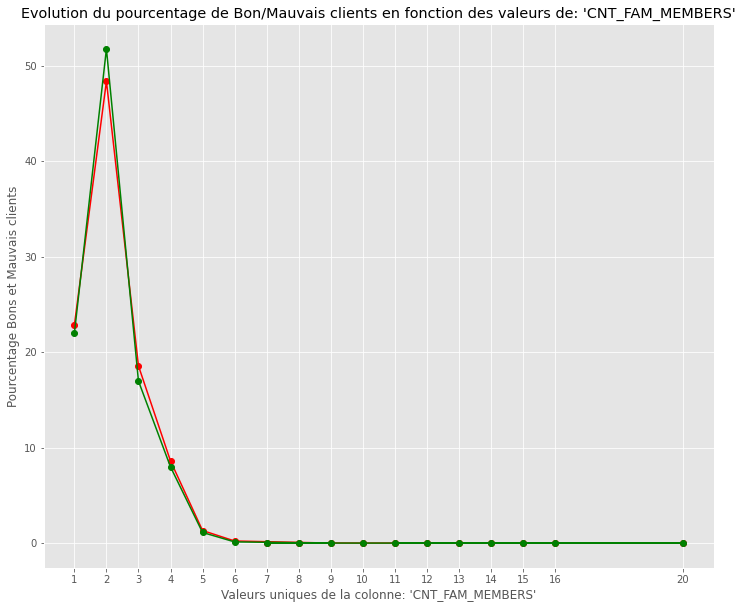

In [102]:
# CNT_FAM_MEMBERS -> OUI -> Nombre de membres de la famille du client -> 2 NAN (IMPUTATION -> Nan)
print(df_application_train['CNT_FAM_MEMBERS'].unique())
print(df_application_train['CNT_FAM_MEMBERS'].isna().sum())
is_possible_influence_graph('CNT_FAM_MEMBERS') # NON 

In [104]:
# REGION_RATING_CLIENT -> OUI-> Notre notation de la région où habite le client  (1,2,3) -> PAS DE NAN
print(df_application_train['REGION_RATING_CLIENT'].unique())
print(df_application_train['REGION_RATING_CLIENT'].isna().sum())
is_possible_influence_cat('REGION_RATING_CLIENT') # OUI

[2 1 3]
0
2 :
Mauvais payeurs (%) : 72.13293051359516
Bons payeurs (%) : 73.9608611675145 

1 :
Mauvais payeurs (%) : 6.251762336354481
Bons payeurs (%) : 10.840650049878665 

3 :
Mauvais payeurs (%) : 21.615307150050352
Bons payeurs (%) : 15.19848878260685 



In [106]:
# REGION_RATING_CLIENT_W_CITY -> OUI-> Notation de la région où habite le client avec prise en compte 
# de la ville (1,2,3) -> PAS DE NAN
print(df_application_train['REGION_RATING_CLIENT_W_CITY'].unique())
print(df_application_train['REGION_RATING_CLIENT_W_CITY'].isna().sum())
is_possible_influence_cat('REGION_RATING_CLIENT_W_CITY') # OUI

[2 1 3]
0
2 :
Mauvais payeurs (%) : 73.19234642497482
Bons payeurs (%) : 74.7521985524575 

1 :
Mauvais payeurs (%) : 6.662638469284995
Bons payeurs (%) : 11.501453909992005 

3 :
Mauvais payeurs (%) : 20.14501510574018
Bons payeurs (%) : 13.746347537550498 



In [107]:
# WEEKDAY_APPR_PROCESS_START 
# -> OUI/NON -> Quel jour de la semaine le client a-t-il demandé le prêt -> PAS DE NAN
print(df_application_train['WEEKDAY_APPR_PROCESS_START'].unique())
print(df_application_train['WEEKDAY_APPR_PROCESS_START'].isna().sum())
is_possible_influence_cat('WEEKDAY_APPR_PROCESS_START') # NON

['WEDNESDAY' 'MONDAY' 'THURSDAY' 'SUNDAY' 'SATURDAY' 'FRIDAY' 'TUESDAY']
0
WEDNESDAY :
Mauvais payeurs (%) : 17.07150050352467
Bons payeurs (%) : 16.872430895056706 

MONDAY :
Mauvais payeurs (%) : 15.846928499496476
Bons payeurs (%) : 16.548396454016117 

THURSDAY :
Mauvais payeurs (%) : 16.507552870090635
Bons payeurs (%) : 16.446870379148596 

SUNDAY :
Mauvais payeurs (%) : 5.168177240684794
Bons payeurs (%) : 5.270158408976744 

SATURDAY :
Mauvais payeurs (%) : 10.755287009063444
Bons payeurs (%) : 11.03061347219176 

FRIDAY :
Mauvais payeurs (%) : 16.51963746223565
Bons payeurs (%) : 16.356310535364326 

TUESDAY :
Mauvais payeurs (%) : 18.13091641490433
Bons payeurs (%) : 17.47521985524575 



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
0


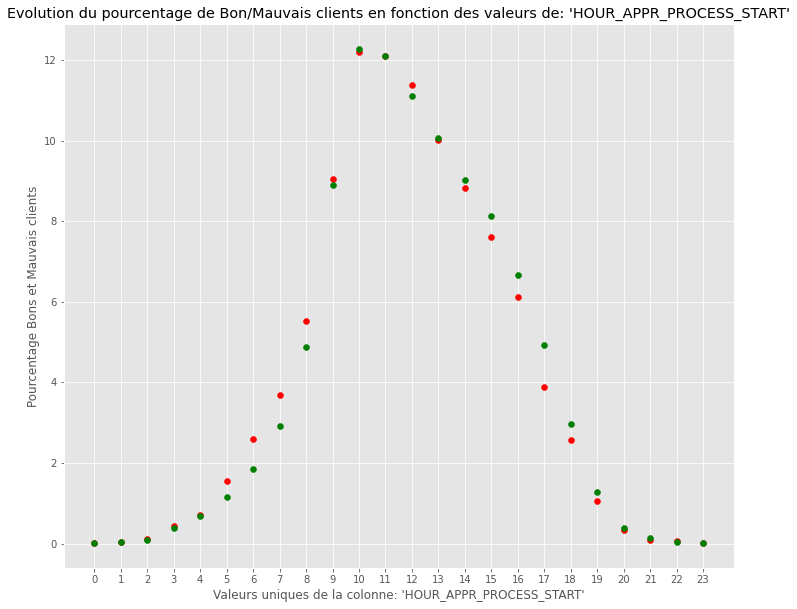

In [109]:
# HOUR_APPR_PROCESS_START 
# -> OUI/NON -> A quelle heure approximativement le client a-t-il demandé le prêt -> PAS DE NAN
print(sorted(df_application_train['HOUR_APPR_PROCESS_START'].unique()))
print(df_application_train['HOUR_APPR_PROCESS_START'].isna().sum())
is_possible_influence_graph('HOUR_APPR_PROCESS_START', graph_type='scatter') # NON

In [110]:
# REG_REGION_NOT_LIVE_REGION
# -> OUI/NON -> Signaler si l'adresse permanente du client ne correspond pas à l'adresse de contact (1=différent, 0=même) -> PAS DE NAN
print(df_application_train['REG_REGION_NOT_LIVE_REGION'].unique())
print(df_application_train['REG_REGION_NOT_LIVE_REGION'].isna().sum())
is_possible_influence_cat('REG_REGION_NOT_LIVE_REGION') # NON

[0 1]
0
0 :
Mauvais payeurs (%) : 98.25579053373616
Bons payeurs (%) : 98.50576257755955 

1 :
Mauvais payeurs (%) : 1.744209466263847
Bons payeurs (%) : 1.4942374224404464 



In [111]:
# REG_REGION_NOT_WORK_REGION
# -> OUI/NON -> Signaler si l'adresse permanente du client ne correspond pas à l'adresse professionnelle -> PAS DE NAN
print(df_application_train['REG_REGION_NOT_WORK_REGION'].unique())
print(df_application_train['REG_REGION_NOT_WORK_REGION'].isna().sum())
is_possible_influence_cat('REG_REGION_NOT_WORK_REGION') # NON

[0 1]
0
0 :
Mauvais payeurs (%) : 94.40886203423969
Bons payeurs (%) : 94.96826867973652 

1 :
Mauvais payeurs (%) : 5.591137965760322
Bons payeurs (%) : 5.031731320263472 



In [112]:
# LIVE_REGION_NOT_WORK_REGION
# -> OUI/NON -> Signaler si l'adresse de contact du client ne correspond pas à l'adresse professionnelle -> PAS DE NAN
print(df_application_train['LIVE_REGION_NOT_WORK_REGION'].unique())
print(df_application_train['LIVE_REGION_NOT_WORK_REGION'].isna().sum())

[0 1]
0


In [113]:
# REG_CITY_NOT_LIVE_CITY
# -> OUI/NON -> Signaler si l'adresse permanente du client ne correspond pas à l'adresse de contact -> PAS DE NAN
print(df_application_train['REG_CITY_NOT_LIVE_CITY'].unique())
print(df_application_train['REG_CITY_NOT_LIVE_CITY'].isna().sum())

[0 1]
0


In [114]:
# LIVE_CITY_NOT_WORK_CITY
# -> OUI/NON - Signaler si l'adresse de contact du client ne correspond pas à l'adresse professionnelle -> PAS DE NAN
print(df_application_train['LIVE_CITY_NOT_WORK_CITY'].unique())
print(df_application_train['LIVE_CITY_NOT_WORK_CITY'].isna().sum())

[0 1]
0


In [115]:
# ORGANIZATION_TYPE
# -> OUI -> Type d'organisation où le client travaille -> PAS DE NAN
print(df_application_train['ORGANIZATION_TYPE'].unique())
print(df_application_train['ORGANIZATION_TYPE'].isna().sum())
is_possible_influence_cat('ORGANIZATION_TYPE') # OUI

['Business Entity Type 3' 'School' 'Government' 'Religion' 'Other' 'XNA'
 'Electricity' 'Medicine' 'Business Entity Type 2' 'Self-employed'
 'Transport: type 2' 'Construction' 'Housing' 'Kindergarten'
 'Trade: type 7' 'Industry: type 11' 'Military' 'Services'
 'Security Ministries' 'Transport: type 4' 'Industry: type 1' 'Emergency'
 'Security' 'Trade: type 2' 'University' 'Transport: type 3' 'Police'
 'Business Entity Type 1' 'Postal' 'Industry: type 4' 'Agriculture'
 'Restaurant' 'Culture' 'Hotel' 'Industry: type 7' 'Trade: type 3'
 'Industry: type 3' 'Bank' 'Industry: type 9' 'Insurance' 'Trade: type 6'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 12' 'Mobile'
 'Trade: type 1' 'Industry: type 5' 'Industry: type 10' 'Legal Services'
 'Advertising' 'Trade: type 5' 'Cleaning' 'Industry: type 13'
 'Trade: type 4' 'Telecom' 'Industry: type 8' 'Realtor' 'Industry: type 6']
0
Business Entity Type 3 :
Mauvais payeurs (%) : 25.47029204431017
Bons payeurs (%) : 21.81537111848482 

S

[0.08303697 0.31126731        nan ... 0.14557045 0.7440264  0.73445967]
173378


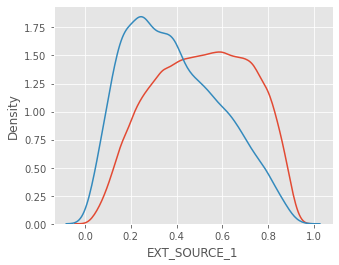

In [116]:
# EXT_SOURCE_1
# -> OUI -> Score provenant d'autre(s) agence(s) de crédit ? -> 173378 NAN (imputation Nan)
print(df_application_train['EXT_SOURCE_1'].unique())
print(df_application_train['EXT_SOURCE_1'].isna().sum())
#is_possible_influence_graph('EXT_SOURCE_1') # ?
plt.figure(figsize=(5,4))
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'EXT_SOURCE_1'], label='Target 0')
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'EXT_SOURCE_1'], label='Target 1')
plt.show()

[0.26294859 0.62224578 0.55591208 ... 0.13118876 0.26448565 0.2678342 ]
660


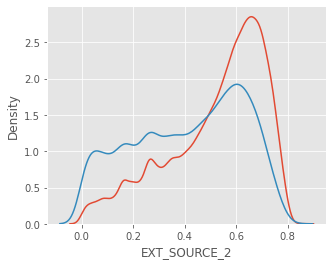

In [117]:
# EXT_SOURCE_2
# -> OUI -> Score provenant d'autre(s) agence(s) de crédit ? -> 660 NAN (imputation Nan)
print(df_application_train['EXT_SOURCE_2'].unique())
print(df_application_train['EXT_SOURCE_2'].isna().sum())
plt.figure(figsize=(5,4))
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'EXT_SOURCE_2'], label='Target 0')
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'EXT_SOURCE_2'], label='Target 1')
plt.show()

60965


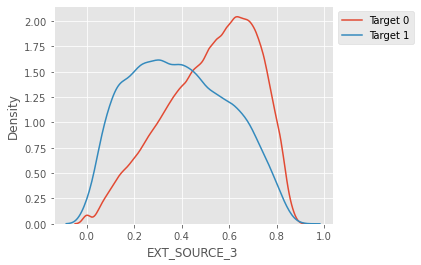

In [118]:
# EXT_SOURCE_3
# -> OUI -> Score provenant d'autre(s) agence(s) de crédit ? -> 60965 NAN (imputation Nan)
#print(df_application_train['EXT_SOURCE_3'].unique())
print(df_application_train['EXT_SOURCE_3'].isna().sum())
plt.figure(figsize=(5,4))
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'EXT_SOURCE_3'], label='Target 0')
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'EXT_SOURCE_3'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [119]:
# APARTMENTS_AVG
# -> OUI -> Information normalisé (moyen) sur le lieu de vie du client -> 156061 NAN (imputation NAN)
print(df_application_train['APARTMENTS_AVG'].unique())
print(df_application_train['APARTMENTS_AVG'].isna().sum())

[0.0247 0.0959    nan ... 0.0261 0.0731 0.3466]
156061


In [120]:
# BASEMENTAREA_AVG
#-> OUI/NON -> Information normalisé (moyen) sur le lieu de vie du client (building) -> 179943 NAN (imputation NAN)
print(df_application_train['BASEMENTAREA_AVG'].unique())
print(df_application_train['BASEMENTAREA_AVG'].isna().sum())

[0.0369 0.0529    nan ... 0.274  0.2733 0.636 ]
179943


150007


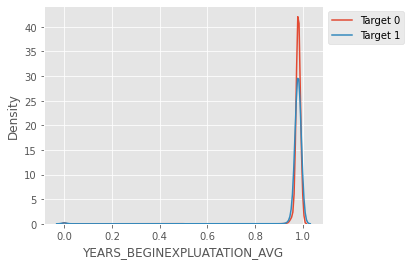

In [121]:
# YEARS_BEGINEXPLUATATION_AVG (imputation NAN)
# -> OUI/NON -> Information normalisé (moyen) sur le lieu de vie du client (building) -> 150007 NAN
#print(df_application_train['YEARS_BEGINEXPLUATATION_AVG'].unique())
print(df_application_train['YEARS_BEGINEXPLUATATION_AVG'].isna().sum())
#is_influence_graph('YEARS_BEGINEXPLUATATION_AVG')
plt.figure(figsize=(5,4))
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'YEARS_BEGINEXPLUATATION_AVG'], label='Target 0')
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'YEARS_BEGINEXPLUATATION_AVG'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

204488


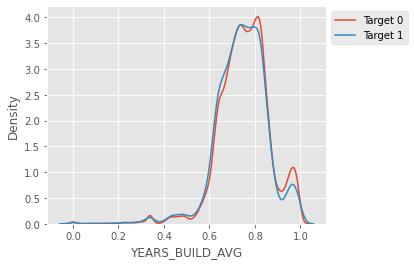

In [122]:
# YEARS_BUILD_AVG (imputation NAN)
#print(df_application_train['YEARS_BUILD_AVG'].unique())
print(df_application_train['YEARS_BUILD_AVG'].isna().sum())
plt.figure(figsize=(5,4))
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 0, 'YEARS_BUILD_AVG'], label='Target 0')
sns.kdeplot(df_application_train.loc[df_application_train['TARGET'] == 1, 'YEARS_BUILD_AVG'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Note: de 44 à 90 variables sur le type d'habitation du client -> (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix)

In [123]:
# FONDKAPREMONT_MODE
print(df_application_train['FONDKAPREMONT_MODE'].unique())
print(df_application_train['FONDKAPREMONT_MODE'].isna().sum())
is_possible_influence_cat('FONDKAPREMONT_MODE')

['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']
210295
reg oper account :
Mauvais payeurs (%) : 20.75327291037261
Bons payeurs (%) : 24.294800591468977 

nan :
Mauvais payeurs (%) : 0.0
Bons payeurs (%) : 0.0 

org spec account :
Mauvais payeurs (%) : 1.3172205438066467
Bons payeurs (%) : 1.8720417707279453 

reg oper spec account :
Mauvais payeurs (%) : 3.190332326283988
Bons payeurs (%) : 3.9931231118626322 

not specified :
Mauvais payeurs (%) : 1.7280966767371602
Bons payeurs (%) : 1.860014291475347 



In [124]:
# TOTALAREA_MODE
print(df_application_train['TOTALAREA_MODE'].unique())
print(df_application_train['TOTALAREA_MODE'].isna().sum())

[0.0149 0.0714    nan ... 0.489  0.482  0.797 ]
148431


[  2.   1.   0.   4.   8.  10.  nan   7.   3.   6.   5.  12.   9.  13.
  11.  14.  22.  16.  15.  17.  20.  25.  19.  18.  21.  24.  23.  28.
  26.  29.  27.  47. 348.  30.]
1021


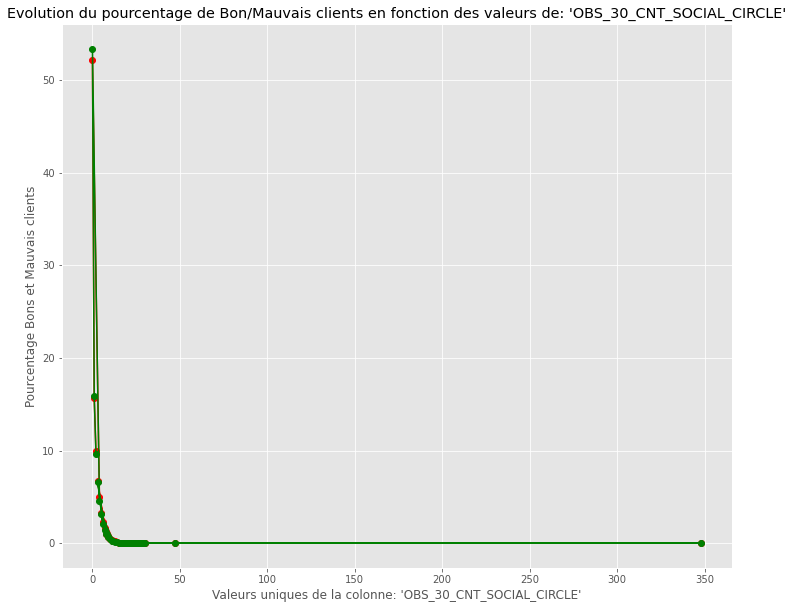

In [125]:
# OBS_30_CNT_SOCIAL_CIRCLE
print(df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'].unique())
print(df_application_train['OBS_30_CNT_SOCIAL_CIRCLE'].isna().sum())
is_possible_influence_graph('OBS_30_CNT_SOCIAL_CIRCLE')

### Fusion des dataframe df_application_train et df_application_test pour merger ensuite d'autres tables

In [126]:
# Pour les lignes provenant du fichier df_application_test -> la colonne TARGET -> se sera des NAN
df_app_train_test = pd.concat([df_application_train, df_application_test], axis=0)
df_app_train_test.reset_index(drop=True, inplace=True)

In [127]:
print(df_application_train.shape)
print(df_application_test.shape)

(307511, 124)
(48744, 123)


In [128]:
df_app_train_test[df_app_train_test['TARGET'].isna()].shape

(48744, 124)

In [129]:
# Est-ce que dans le jeu de TEST et TRAIN ce sont les mêmes identifiants ? (normalement non) -> Si True c'est bien le cas
len(df_app_train_test['SK_ID_CURR'].unique()) == len(df_app_train_test['SK_ID_CURR'])

True

In [ ]:
# df_app_train_test.info(verbose=True)

In [130]:
print(df_app_train_test.loc[678, :]) # On doit avoir qu'une ligne sinon le reset_index est en défaut

SK_ID_CURR                        100784
TARGET                               1.0
NAME_CONTRACT_TYPE            Cash loans
CODE_GENDER                            F
FLAG_OWN_CAR                           N
                                 ...    
AMT_REQ_CREDIT_BUREAU_MON            NaN
AMT_REQ_CREDIT_BUREAU_QRT            NaN
AMT_REQ_CREDIT_BUREAU_YEAR           NaN
YEARS_BIRTH                    60.769863
DAYS_EMPLOYED_ANOMALIE              True
Name: 678, Length: 124, dtype: object


### pd.get_dummies

In [131]:
# NAME_CONTRACT_TYPE: Identification si prêt en espèces ou renouvelable -> Catégories -> OUI -> Catégorie
# INFLUENCE POSSIBLE -> OUI
print(df_application_train['NAME_CONTRACT_TYPE'].unique())
print(df_application_train['NAME_CONTRACT_TYPE'].isna().sum())
is_possible_influence_cat('NAME_CONTRACT_TYPE')

['Cash loans' 'Revolving loans']
0
Cash loans :
Mauvais payeurs (%) : 93.53877139979859
Bons payeurs (%) : 90.20998563777476 

Revolving loans :
Mauvais payeurs (%) : 6.4612286002014105
Bons payeurs (%) : 9.790014362225225 



In [132]:
pd.get_dummies(df_application_train['NAME_CONTRACT_TYPE'], prefix='NAME_CONTRACT_TYPE_')

NAME_CONTRACT_TYPE__Cash loans  NAME_CONTRACT_TYPE__Revolving loans
0                                    1                                    0
1                                    1                                    0
2                                    0                                    1
3                                    1                                    0
4                                    1                                    0
...                                ...                                  ...
307506                               1                                    0
307507                               1                                    0
307508                               1                                    0
307509                               1                                    0
307510                               1                                    0

[307511 rows x 2 columns]

In [133]:
# Si pas de NAN et 2 ou plusieurs valeurs pour les catégories (pd.get_dummies)
for col_name in df_app_train_test.columns:
    if df_app_train_test[col_name].dtype == 'object':
        print("col_name :", col_name)
        if df_app_train_test[col_name].isna().sum() == 0:
            df_app_train_test = pd.concat([pd.get_dummies(df_app_train_test[col_name], prefix=col_name+'_'), df_app_train_test], axis=1)
            df_app_train_test.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")
        else:
            df_app_train_test[col_name].replace({np.nan: 'UNSPECIFIED'}, inplace=True)
            df_app_train_test = pd.concat([pd.get_dummies(df_app_train_test[col_name], prefix=col_name+'_'), df_app_train_test], axis=1)
            df_app_train_test.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")

col_name : NAME_CONTRACT_TYPE
col_name : NAME_CONTRACT_TYPE a été traitée.
col_name : CODE_GENDER
col_name : CODE_GENDER a été traitée.
col_name : FLAG_OWN_CAR
col_name : FLAG_OWN_CAR a été traitée.
col_name : FLAG_OWN_REALTY
col_name : FLAG_OWN_REALTY a été traitée.
col_name : NAME_TYPE_SUITE
col_name : NAME_TYPE_SUITE a été traitée.
col_name : NAME_INCOME_TYPE
col_name : NAME_INCOME_TYPE a été traitée.
col_name : NAME_EDUCATION_TYPE
col_name : NAME_EDUCATION_TYPE a été traitée.
col_name : NAME_FAMILY_STATUS
col_name : NAME_FAMILY_STATUS a été traitée.
col_name : NAME_HOUSING_TYPE
col_name : NAME_HOUSING_TYPE a été traitée.
col_name : OCCUPATION_TYPE
col_name : OCCUPATION_TYPE a été traitée.
col_name : WEEKDAY_APPR_PROCESS_START
col_name : WEEKDAY_APPR_PROCESS_START a été traitée.
col_name : ORGANIZATION_TYPE
col_name : ORGANIZATION_TYPE a été traitée.
col_name : FONDKAPREMONT_MODE
col_name : FONDKAPREMONT_MODE a été traitée.
col_name : HOUSETYPE_MODE
col_name : HOUSETYPE_MODE a été t

In [134]:
df_app_train_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 254 columns):
 #    Column                                              Dtype  
---   ------                                              -----  
 0    EMERGENCYSTATE_MODE__No                             uint8  
 1    EMERGENCYSTATE_MODE__UNSPECIFIED                    uint8  
 2    EMERGENCYSTATE_MODE__Yes                            uint8  
 3    WALLSMATERIAL_MODE__Block                           uint8  
 4    WALLSMATERIAL_MODE__Mixed                           uint8  
 5    WALLSMATERIAL_MODE__Monolithic                      uint8  
 6    WALLSMATERIAL_MODE__Others                          uint8  
 7    WALLSMATERIAL_MODE__Panel                           uint8  
 8    WALLSMATERIAL_MODE__Stone, brick                    uint8  
 9    WALLSMATERIAL_MODE__UNSPECIFIED                     uint8  
 10   WALLSMATERIAL_MODE__Wooden                          uint8  
 11   HOUSETYPE_MODE__UNSPECIF

### Imputations pour les valeurs numériques
Les NAN ne sont pas génants, par contre les valeurs abbérantes/atypiques (outliers ?)

In [135]:
num_col = [name for name in df_app_train_test.columns if df_app_train_test[name].dtype != 'object']
display(num_col)

['EMERGENCYSTATE_MODE__No',
 'EMERGENCYSTATE_MODE__UNSPECIFIED',
 'EMERGENCYSTATE_MODE__Yes',
 'WALLSMATERIAL_MODE__Block',
 'WALLSMATERIAL_MODE__Mixed',
 'WALLSMATERIAL_MODE__Monolithic',
 'WALLSMATERIAL_MODE__Others',
 'WALLSMATERIAL_MODE__Panel',
 'WALLSMATERIAL_MODE__Stone, brick',
 'WALLSMATERIAL_MODE__UNSPECIFIED',
 'WALLSMATERIAL_MODE__Wooden',
 'HOUSETYPE_MODE__UNSPECIFIED',
 'HOUSETYPE_MODE__block of flats',
 'HOUSETYPE_MODE__specific housing',
 'HOUSETYPE_MODE__terraced house',
 'FONDKAPREMONT_MODE__UNSPECIFIED',
 'FONDKAPREMONT_MODE__not specified',
 'FONDKAPREMONT_MODE__org spec account',
 'FONDKAPREMONT_MODE__reg oper account',
 'FONDKAPREMONT_MODE__reg oper spec account',
 'ORGANIZATION_TYPE__Advertising',
 'ORGANIZATION_TYPE__Agriculture',
 'ORGANIZATION_TYPE__Bank',
 'ORGANIZATION_TYPE__Business Entity Type 1',
 'ORGANIZATION_TYPE__Business Entity Type 2',
 'ORGANIZATION_TYPE__Business Entity Type 3',
 'ORGANIZATION_TYPE__Cleaning',
 'ORGANIZATION_TYPE__Construction',
 

### Correction de colonnes ou valeurs

#### DAYS_EMPLOYED / YEARS_EMPLOYED

In [136]:
print(df_app_train_test['DAYS_EMPLOYED'].isna().sum())
print(df_app_train_test['DAYS_EMPLOYED'].describe())

64648
count    291607.000000
mean      -2396.698937
std        2334.479967
min      -17912.000000
25%       -3200.000000
50%       -1663.000000
75%        -780.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64


In [137]:
df_app_train_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
# Nombre de jours avant la demande la personne a commencé son emploi actuel
df_app_train_test['YEARS_EMPLOYED'] = df_app_train_test['DAYS_EMPLOYED'] / -365

In [138]:
df_app_train_test.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

In [139]:
df_app_train_test['YEARS_EMPLOYED'].describe()

count    291607.000000
mean          6.566298
std           6.395836
min          -0.000000
25%           2.136986
50%           4.556164
75%           8.767123
max          49.073973
Name: YEARS_EMPLOYED, dtype: float64

#### DAYS_BIRTH / YEARS_BIRTH

In [140]:
df_app_train_test['DAYS_BIRTH'].describe()

count    356255.000000
mean     -16041.248841
std        4358.803980
min      -25229.000000
25%      -19676.000000
50%      -15755.000000
75%      -12425.000000
max       -7338.000000
Name: DAYS_BIRTH, dtype: float64

In [141]:
df_app_train_test['YEARS_BIRTH'] = df_app_train_test['DAYS_BIRTH'] / -365

In [142]:
df_app_train_test.drop(['DAYS_BIRTH'], axis=1, inplace=True)

In [143]:
df_app_train_test['YEARS_BIRTH'].describe()

count    356255.000000
mean         43.948627
std          11.941929
min          20.104110
25%          34.041096
50%          43.164384
75%          53.906849
max          69.120548
Name: YEARS_BIRTH, dtype: float64

### Annuité constante
- https://fr.wikipedia.org/wiki/Annuité_constante
-L'annuité constante est le remboursement annuel d'un emprunt avec les intérêts par un montant constant, qui est calculé en fonction du taux d'intérêt et de la durée de l'emprunt selon une formule mathématique

#### CREDIT_INCOME_RATIO : Rapport du montant du crédit par rapport aux revenus d'un client (sans les intérêts dus)
Note : cela donne hors intérêts du prêt le nombre d'année de revenus équivalentes au crédit demandé<br />
(faux car la totalité du revenu ne sert pas à rembourser le crédit -> niveau d'endettement)

In [144]:
print(df_app_train_test['AMT_CREDIT'].isna().sum())
print(df_app_train_test['AMT_INCOME_TOTAL'].isna().sum())

0
0


In [145]:
df_app_train_test['CREDIT_INCOME_RATIO'] = df_app_train_test['AMT_CREDIT'] / df_app_train_test['AMT_INCOME_TOTAL']
df_app_train_test['CREDIT_INCOME_RATIO'].describe()

count    356255.000000
mean          3.849476
std           2.635035
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: CREDIT_INCOME_RATIO, dtype: float64

##### Correction de valeurs
Remarque: bien plus de 84 ans pour rembourser un crédit c'est bizarre quand même

In [146]:
# On peut prendre les crédits qui dépassent 30 ans au particulier semblent suspects sur le jeu de train
df_app_train_test[(df_app_train_test['CREDIT_INCOME_RATIO'] > 30) & (df_app_train_test['TARGET'].notna())].shape[0]

23

In [147]:
amt_credit_possible_anomalie = df_app_train_test[(df_app_train_test['CREDIT_INCOME_RATIO'] > 30)].index
print(amt_credit_possible_anomalie)
print(len(amt_credit_possible_anomalie))

Int64Index([   678,  16784,  20727,  35791,  42001,  49325,  58379, 103862,
            107170, 134362, 156189, 158077, 165555, 168253, 190737, 193574,
            200894, 205575, 213274, 226137, 227084, 255247, 293599, 313914],
           dtype='int64')
24


##### AMT_CREDIT_ANOMALIE : Montant de crédit qui semble suspect sachant que cela dépasse plus de 30 ans de salaire complet

In [148]:
df_app_train_test['AMT_CREDIT_ANOMALIE'] = 0 # par défaut pas d'anomalie
df_app_train_test.loc[amt_credit_possible_anomalie , 'AMT_CREDIT_ANOMALIE'] = 1

In [149]:
# Vérification doit être égal au nombre de l'index de crédit anomalies
df_app_train_test[['AMT_CREDIT_ANOMALIE']][df_app_train_test['AMT_CREDIT_ANOMALIE'] == 1].shape[0]

24

In [150]:
# CORRECTION DE CREDIT_PER_INCOME
df_app_train_test.loc[amt_credit_possible_anomalie, 'CREDIT_INCOME_RATIO'] = np.nan

In [151]:
df_app_train_test['CREDIT_INCOME_RATIO'].describe()

count    356231.000000
mean          3.847340
std           2.620684
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          30.000000
Name: CREDIT_INCOME_RATIO, dtype: float64

#### ANNUITY_INCOME_RATIO:  le pourcentage de remboursement du prêt par an (intérêt inclus)  par rapport aux revenus d'un client

In [152]:
print(df_app_train_test['AMT_ANNUITY'].isna().sum())

36


In [153]:
# On peut en théorie exclure du calcul toutes les lignes avec des montants de crédit anormaux donc également AMT_ANNUITY etc
df_app_train_test['ANNUITY_INCOME_RATIO'] = (df_app_train_test['AMT_ANNUITY'] / df_app_train_test['AMT_INCOME_TOTAL']) * 100

In [154]:
print(df_app_train_test['ANNUITY_INCOME_RATIO'].isna().sum())

36


In [155]:
df_app_train_test['ANNUITY_INCOME_RATIO'].describe()

count    356219.000000
mean         18.121091
std           9.470057
min           0.022388
25%          11.495000
50%          16.318182
75%          22.915590
max         202.471429
Name: ANNUITY_INCOME_RATIO, dtype: float64

##### ANOMALIE: Un montant d'intérêt à plus de 23 ou 30% des revenus par an c'est bizarre (atypique)

In [156]:
print(df_app_train_test[df_app_train_test['ANNUITY_INCOME_RATIO'] > 50].shape[0])
print(len(df_app_train_test))

2958
356255


In [157]:
df_app_train_test[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']][df_app_train_test['ANNUITY_INCOME_RATIO'] > 50]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY
678              54000.0   1885500.0      74191.5
733              58500.0    888840.0      29506.5
779              90000.0    701730.0      68490.0
875             112500.0   1215000.0      84694.5
925              67500.0    900000.0      35824.5
...                  ...         ...          ...
355889          121500.0    743850.0      72594.0
355909           67500.0    450000.0      43839.0
356066          153000.0   1928304.0      79578.0
356145           45000.0    238810.5      25204.5
356236           45000.0    450000.0      24543.0

[2958 rows x 3 columns]

In [158]:
# C'est pas logique un prêt par an qui coûte plus de 50% des revenus...
index_amt_annuity_anomalie = \
df_app_train_test[['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY']][df_app_train_test['ANNUITY_INCOME_RATIO'] > 50].index

In [159]:
df_app_train_test['AMT_ANNUITY_ANOMALIE'] = 0
df_app_train_test.loc[index_amt_annuity_anomalie, 'AMT_ANNUITY_ANOMALIE'] = 1

In [160]:
# Vérification
df_app_train_test[df_app_train_test['AMT_ANNUITY_ANOMALIE'] == 1].shape[0]

2958

In [161]:
# Correction d'imputation pour df_app_train_test['ANNUITY_INCOME_PERCENT']
df_app_train_test.loc[index_amt_annuity_anomalie, 'ANNUITY_INCOME_RATIO'] = np.nan

In [162]:
df_app_train_test['ANNUITY_INCOME_RATIO'].describe()

count    353261.000000
mean         17.763943
std           8.591268
min           0.022388
25%          11.443333
50%          16.236667
75%          22.690000
max          50.000000
Name: ANNUITY_INCOME_RATIO, dtype: float64

#### CREDIT_DURATION : Rapport entre le remboursement annuel client (intérêt inclus)  et le prêt total 

In [163]:
df_app_train_test['CREDIT_DURATION'] = df_app_train_test['AMT_CREDIT'] / df_app_train_test['AMT_ANNUITY']

In [164]:
df_app_train_test['CREDIT_DURATION'].isna().sum()

36

In [165]:
df_app_train_test['CREDIT_DURATION'].describe()

count    356219.000000
mean         21.005276
std           7.783368
min           8.036674
25%          14.910747
50%          20.000000
75%          26.260412
max          45.305079
Name: CREDIT_DURATION, dtype: float64

#### YEARS_EMPLOYED_RATIO:  Pourcentage d'années travaillées par rapport à l'âge du client

In [166]:
df_app_train_test['YEARS_EMPLOYED_RATIO'] = (df_app_train_test['YEARS_EMPLOYED'] / df_app_train_test['YEARS_BIRTH']) * 100

In [167]:
print(df_app_train_test['YEARS_EMPLOYED_RATIO'].isna().sum()) # Normal c'est la correction des 1000 ans

64648


In [168]:
print(df_app_train_test['YEARS_EMPLOYED_RATIO'].describe())

count    291607.000000
mean         15.779849
std          13.345000
min          -0.000000
25%           5.695409
50%          12.007537
75%          22.059783
max          72.881149
Name: YEARS_EMPLOYED_RATIO, dtype: float64


### Fusion avec d'autres dataframes

#### df_installments_payments

In [169]:
with pd.option_context('display.max_rows', None):
    display(
        df_HomeCredit_columns_description[df_HomeCredit_columns_description['Table'] == 'installments_payments.csv']\
        .style.set_properties(subset=['Description', 'Special'], **{'width': '300px'})
    )

In [170]:
df_installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [171]:
len(df_installments_payments['SK_ID_PREV'].unique()) == len(df_installments_payments)

False

In [172]:
df_installments_payments['SK_ID_PREV'].value_counts()

2360056    293
2592574    279
1017477    248
1449382    243
1746731    236
          ... 
1591407      1
1329393      1
2558866      1
2479794      1
1276288      1
Name: SK_ID_PREV, Length: 997752, dtype: int64

In [173]:
# On peut avoir plusieurs fois le même SK_ID_PREV pour un même SK_ID_CURR (client)
# Et un client (SK_ID_CURR) peut avoir plusieurs SK_ID_PREV différent
df_installments_payments[df_installments_payments['SK_ID_PREV'] == 2360056 ].head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
11512648     2360056      453103                     0.0   
11524316     2360056      453103                     0.0   
11527596     2360056      453103                     0.0   
11532386     2360056      453103                     0.0   
11539274     2360056      453103                     0.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
11512648                    138          -2069.0             -2069.0   
11524316                    157          -1977.0             -1977.0   
11527596                    221          -1365.0             -1365.0   
11532386                    168          -1924.0             -1924.0   
11539274                    237          -1013.0             -1013.0   

          AMT_INSTALMENT  AMT_PAYMENT  
11512648         10800.0      10800.0  
11524316          2925.0       2925.0  
11527596          3375.0       3375.0  
11532386          5400.0       5400.0  
11539274          5625.0       5625.0

In [174]:
df_installments_payments['SK_ID_PREV'].value_counts()

2360056    293
2592574    279
1017477    248
1449382    243
1746731    236
          ... 
1591407      1
1329393      1
2558866      1
2479794      1
1276288      1
Name: SK_ID_PREV, Length: 997752, dtype: int64

In [175]:
print(df_installments_payments['SK_ID_CURR'].unique().shape)
print(df_installments_payments['SK_ID_PREV'].unique().shape)

(339587,)
(997752,)


In [176]:
df_installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].sort_values(by='SK_ID_CURR').head(10)

SK_ID_CURR  SK_ID_PREV
3458712      100001     1369693
3435373      100001     1851984
2624024      100001     1369693
1761012      100001     1851984
3774071      100001     1851984
1478621      100001     1369693
2568722      100001     1369693
2163032      100002     1038818
504426       100002     1038818
699804       100002     1038818

In [177]:
df_installments_payments[['SK_ID_CURR', 'SK_ID_PREV']].sort_values(by='SK_ID_PREV').head(10)

SK_ID_CURR  SK_ID_PREV
512588       158271     1000001
2159480      158271     1000001
3411021      101962     1000002
1214732      101962     1000002
1006868      101962     1000002
1631862      101962     1000002
7054246      252457     1000003
6145031      252457     1000003
4279518      252457     1000003
5197652      260094     1000004

In [178]:
gb_instal_pay_SK_ID_PREV = df_installments_payments.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR' : 'last', # first c'est pareil, ce sont tous les mêmes
    'DAYS_INSTALMENT' : 'sum',
    'DAYS_ENTRY_PAYMENT' : 'sum',
    'AMT_INSTALMENT' : 'sum',
    'AMT_PAYMENT' : 'sum',
})

gb_instal_pay_SK_ID_PREV.reset_index(inplace=True)

In [179]:
gb_instal_pay_SK_ID_PREV.head()

SK_ID_PREV  SK_ID_CURR  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0     1000001      158271           -506.0              -538.0   
1     1000002      101962          -6220.0             -6299.0   
2     1000003      252457           -192.0              -238.0   
3     1000004      260094          -5404.0             -5591.0   
4     1000005      176456         -16978.0            -17071.0   

   AMT_INSTALMENT  AMT_PAYMENT  
0       68443.425    68443.425  
1       37235.565    37235.565  
2       14854.050    14854.050  
3       33523.155    33523.155  
4      161735.310   147021.705

In [180]:
 gb_instal_pay_SK_ID_PREV['SK_ID_CURR'].value_counts()

309133    26
272099    24
152214    24
328085    23
197583    22
          ..
343818     1
295249     1
202684     1
422392     1
282026     1
Name: SK_ID_CURR, Length: 339587, dtype: int64

In [181]:
gb_instal_pay_SK_ID_PREV[gb_instal_pay_SK_ID_PREV['SK_ID_CURR'] == 309133].head()

SK_ID_PREV  SK_ID_CURR  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
9683       1011291      309133         -10060.0            -10110.0   
96874      1169209      309133         -21392.0            -21413.0   
187104     1324471      309133          -6884.0             -6958.0   
237734     1413354      309133           -460.0              -506.0   
350536     1614057      309133          -4800.0             -4861.0   

        AMT_INSTALMENT  AMT_PAYMENT  
9683         90096.165    90096.165  
96874        71468.235    71468.235  
187104      121198.770   121198.770  
237734      112782.375   112782.375  
350536      262947.735   262947.735

In [182]:
gb_instal_pay_SK_ID_CURR = gb_instal_pay_SK_ID_PREV.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV' : 'count', # prend le nombre total
    'DAYS_INSTALMENT' : 'sum',
    'DAYS_ENTRY_PAYMENT' : 'sum',
    'AMT_INSTALMENT' : 'sum',
    'AMT_PAYMENT' : 'sum',    
})

gb_instal_pay_SK_ID_CURR.reset_index(inplace=True)

In [183]:
gb_instal_pay_SK_ID_CURR.head()

SK_ID_CURR  SK_ID_PREV  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0      100001           2         -15314.0            -15365.0   
1      100002           1          -5605.0             -5993.0   
2      100003           3         -34454.0            -34633.0   
3      100004           1          -2262.0             -2285.0   
4      100005           1          -5274.0             -5486.0   

   AMT_INSTALMENT  AMT_PAYMENT  
0       41195.925    41195.925  
1      219625.695   219625.695  
2     1618864.650  1618864.650  
3       21288.465    21288.465  
4       56161.845    56161.845

In [184]:
def display_dist_col(dataframe, col_name):
    """
    Fonction qui permet de regarder rapidement la distribution des valeurs d'une colonne du dataframe df_app_train_test.
    C'est un outil d'aide pour choisir entre une imputation à la moyenne, la médiane ou encore le mode.
    
    Args:
        dataframe (Dataframe): Le pandas DataFrame sur lequel on souhaite inspecter les colonnes.
        col_name (string): Nom de la colonne du dataframe df_app_train_test à inspecter.
        
    Returns:
        None
    """
    print(dataframe[col_name].unique()[:10], '\n')
    print(dataframe[col_name].agg(['mean', 'median']), '\n')
    print("mode :", dataframe[col_name].mode()[0], '\n')
    print(dataframe[col_name].value_counts(), '\n') # équivalent -> .mode()
    g = sns.boxplot(data=dataframe[col_name], orient='h')
    g2 = sns.displot(data=dataframe[col_name], kind='kde')
    return None

In [185]:
# On créé au final le dataframe une ligne = un client résumant l'ensemble des rembournsements passés (pour l'ensemble des dossiers)
df_instal_pay = gb_instal_pay_SK_ID_CURR.copy()

# Nombre de jours global de retard de paiement du client
df_instal_pay['DAYS_TOTAL_PAY_DIFF'] = df_instal_pay['DAYS_INSTALMENT'] + abs(df_instal_pay['DAYS_ENTRY_PAYMENT'])

# Montant total de retard de paiement du client (devrait normalement être tout le temps à zéro)
df_instal_pay['AMT_TOTAL_DIFF'] = df_instal_pay['AMT_INSTALMENT'] - df_instal_pay['AMT_PAYMENT']

[     0.     29857.365  11986.155 292086.855 -41605.56  179437.725
  57817.17  173765.52  -44369.28  230494.14 ] 

mean     -7357.277519
median       0.000000
Name: AMT_TOTAL_DIFF, dtype: float64 

mode : 0.0 

 0.000         171138
 2250.000         608
-45000.000        448
-22500.000        314
 9000.000         305
                ...  
 20401.830          1
 28404.720          1
 13933.665          1
-346147.290         1
-457431.165         1
Name: AMT_TOTAL_DIFF, Length: 152385, dtype: int64 



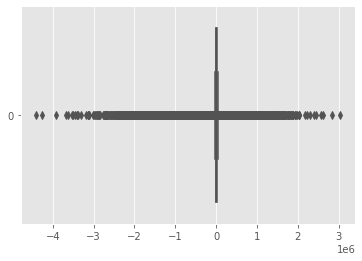

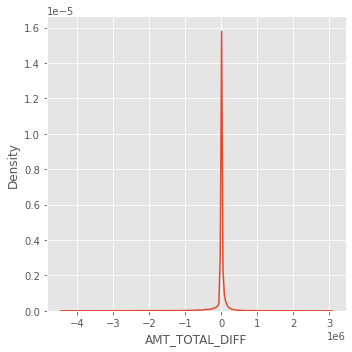

In [186]:
display_dist_col(df_instal_pay, 'AMT_TOTAL_DIFF')

In [187]:
#### IMPUTATION CORRECTION
df_instal_pay['DAYS_TOTAL_PAY_DIFF'].replace({np.nan: df_instal_pay['DAYS_TOTAL_PAY_DIFF'].median()}, inplace=True)
#### IMPUTATION CORRECTION
df_instal_pay['AMT_TOTAL_DIFF'].replace({np.nan: df_instal_pay['AMT_TOTAL_DIFF'].median()}, inplace=True)

In [188]:
# On drop les colonnes qui ne servent plus
df_instal_pay.drop(['DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT'], axis=1, inplace=True)
df_instal_pay.head()

SK_ID_CURR  SK_ID_PREV  DAYS_TOTAL_PAY_DIFF  AMT_TOTAL_DIFF
0      100001           2                 51.0             0.0
1      100002           1                388.0             0.0
2      100003           3                179.0             0.0
3      100004           1                 23.0             0.0
4      100005           1                212.0             0.0

In [189]:
# Contrôle
len(df_instal_pay['SK_ID_CURR'].unique()) == len(df_instal_pay)

True

#### df_pos_cash_balance

In [190]:
with pd.option_context('display.max_rows', None):
    display(
        df_HomeCredit_columns_description[df_HomeCredit_columns_description['Table'] == 'POS_CASH_balance.csv']\
        .style.set_properties(subset=['Description', 'Special'], **{'width': '300px'})
    )

In [191]:
df_pos_cash_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [192]:
df_pos_cash_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [193]:
df_pos_cash_balance['NAME_CONTRACT_STATUS'].unique()

array(['Active', 'Completed', 'Signed', 'Approved',
       'Returned to the store', 'Demand', 'Canceled', 'XNA',
       'Amortized debt'], dtype=object)

In [194]:
df_pos_cash_balance['SK_DPD_DEF'].unique()

array([   0,    1,    2, ..., 2806, 2376, 2495], dtype=int64)

In [195]:
df_pos_cash_balance[(df_pos_cash_balance['NAME_CONTRACT_STATUS'] == 'Active')]

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001352     2700641      448867             -19             6.0   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001352                    0.0               Active     843           0  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  

[9151119 rows x 8 columns]

In [196]:
df_pos_cash_balance['SK_ID_PREV'].value_counts()

1856103    96
2706683    96
1617536    96
1364606    96
1057553    96
           ..
1922777     1
2660098     1
1364218     1
1077449     1
1191779     1
Name: SK_ID_PREV, Length: 936325, dtype: int64

In [197]:
gb_pos_cash_balance_SK_ID_PREV = df_pos_cash_balance.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR': 'last', # c'est le même pour tous pour un client donné
    'NAME_CONTRACT_STATUS': 'count',
    'SK_DPD': 'sum',
    'SK_DPD_DEF': 'sum'
})

gb_pos_cash_balance_SK_ID_PREV.reset_index(inplace=True)

In [198]:
gb_pos_cash_balance_SK_ID_PREV.head()

SK_ID_PREV  SK_ID_CURR  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0     1000001      158271                     3       0           0
1     1000002      101962                     5       0           0
2     1000003      252457                     4       0           0
3     1000004      260094                     8       0           0
4     1000005      176456                    11       0           0

In [199]:
# contrôles
display(gb_pos_cash_balance_SK_ID_PREV[gb_pos_cash_balance_SK_ID_PREV['SK_ID_CURR'] == 100001])

display(df_pos_cash_balance[df_pos_cash_balance['SK_ID_CURR'] == 100001])

SK_ID_PREV  SK_ID_CURR  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
199530     1369693      100001                     5       0           0
447428     1851984      100001                     4       7           7

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
1261679     1851984      100001             -96             4.0   
1891462     1851984      100001             -95             4.0   
2197888     1369693      100001             -53             4.0   
4704415     1369693      100001             -54             4.0   
4928574     1851984      100001             -93             4.0   
7167007     1369693      100001             -57             4.0   
7823681     1369693      100001             -55             4.0   
8531326     1851984      100001             -94             4.0   
8789081     1369693      100001             -56             4.0   

         CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
1261679                    2.0               Active       0           0  
1891462                    1.0               Active       7           7  
2197888                    0.0            Completed       0           0  
4704415                    1.0               Active       0           0  
4928574                    0.0            Completed       0           0  
7167007                    4.0               Active       0           0  
7823681                    2.0               Active       0           0  
8531326                    0.0               Active       0           0  
8789081                    3.0               Active       0           0

In [200]:
gb_pos_cash_balance_SK_ID_CURR = gb_pos_cash_balance_SK_ID_PREV.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count', 
    'NAME_CONTRACT_STATUS': 'count',
    'SK_DPD': 'sum',
    'SK_DPD_DEF': 'sum'    
})

In [201]:
df_pos_cash_bal = gb_pos_cash_balance_SK_ID_CURR.copy()
df_pos_cash_bal.reset_index(inplace=True)
df_pos_cash_bal.head()

SK_ID_CURR  SK_ID_PREV  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
0      100001           2                     2       7           7
1      100002           1                     1       0           0
2      100003           3                     3       0           0
3      100004           1                     1       0           0
4      100005           1                     1       0           0

In [ ]:
display_dist_col(df_pos_cash_bal, 'SK_DPD_DEF')

In [202]:
#### IMPUTATION CORRECTION
df_pos_cash_bal['NAME_CONTRACT_STATUS'].replace({np.nan: df_pos_cash_bal['NAME_CONTRACT_STATUS'].median()}, inplace=True)
df_pos_cash_bal['SK_DPD'].replace({np.nan: df_pos_cash_bal['SK_DPD'].median()}, inplace=True)
df_pos_cash_bal['SK_DPD_DEF'].replace({np.nan: df_pos_cash_bal['SK_DPD_DEF'].median()}, inplace=True)

#### df_credit_card_balance

In [203]:
with pd.option_context('display.max_rows', None):
    display(
        df_HomeCredit_columns_description[df_HomeCredit_columns_description['Table'] == 'credit_card_balance.csv']\
        .style.set_properties(subset=['Description', 'Special'], **{'width': '300px'})
    )

In [204]:
df_credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  ...  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                 1700.325  ...          0.000                 0.000   
1                 2250.000  ...      64875.555             64875.555   
2                 2250.000  ...      31460.085             31460.085   
3                11795.760  ...     233048.970            233048.970   
4                22924.890  ...     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
0                       1.0                       35.0                Active   
1                       0.0                       69.0                Active   
2                       0.0                       30.0                Active   
3                       0.0                       10.0                Active   
4                       1.0                      101.0                Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0  

[5 rows x 23 columns]

In [205]:
df_credit_card_balance['SK_ID_PREV'].value_counts()

2377894    96
2581635    96
1130707    96
1602951    96
2775491    96
           ..
1896484     1
2553866     1
2809310     1
2152605     1
2191610     1
Name: SK_ID_PREV, Length: 104307, dtype: int64

In [206]:
gb_credit_card_balance_SK_ID_PREV = df_credit_card_balance.groupby('SK_ID_PREV').agg({
    'SK_ID_CURR': 'last',
    'AMT_PAYMENT_TOTAL_CURRENT': lambda x: x.median() - x.mean(), # Combien le client a-t-il payé au cours du mois au total sur le crédit précédent 
    'AMT_TOTAL_RECEIVABLE': lambda x: x.median() - x.mean(), # Montant total à recevoir sur le crédit précédent
    'CNT_INSTALMENT_MATURE_CUM': 'count', # Nombre d'acomptes versés sur le crédit précédent
    'NAME_CONTRACT_STATUS': 'count', # Nombre de contrats différents (pas besoin de connaître le détail)
    'SK_DPD': 'sum',
    'SK_DPD_DEF': 'sum' 
})

gb_credit_card_balance_SK_ID_PREV.reset_index(inplace=True)

In [207]:
gb_credit_card_balance_SK_ID_PREV.head()

SK_ID_PREV  SK_ID_CURR  AMT_PAYMENT_TOTAL_CURRENT  AMT_TOTAL_RECEIVABLE  \
0     1000018      394447               -1640.880000         -29242.080000   
1     1000030      361282               -2212.987500          -7898.709375   
2     1000031      131335              -18051.778125         -49197.223125   
3     1000035      436351                   0.000000              0.000000   
4     1000077      181153                   0.000000              0.000000   

   CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          5                     5       0           0  
1                          8                     8       0           0  
2                         16                    16       0           0  
3                          5                     5       0           0  
4                         11                    11       0           0

In [208]:
len(gb_credit_card_balance_SK_ID_PREV['SK_ID_CURR'].unique()) == len(gb_credit_card_balance_SK_ID_PREV)

False

In [209]:
gb_credit_card_balance_SK_ID_PREV['SK_ID_CURR'].value_counts()

355767    4
120076    3
187294    3
206455    3
263421    3
         ..
182557    1
261178    1
240885    1
167674    1
425374    1
Name: SK_ID_CURR, Length: 103558, dtype: int64

In [210]:
gb_credit_card_balance_SK_ID_CURR = gb_credit_card_balance_SK_ID_PREV.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',
    'AMT_PAYMENT_TOTAL_CURRENT': lambda x: x.median() - x.mean(), # Combien le client a-t-il payé au cours du mois au total sur le crédit précédent 
    'AMT_TOTAL_RECEIVABLE': lambda x: x.median() - x.mean(), # Montant total à recevoir sur le crédit précédent
    'CNT_INSTALMENT_MATURE_CUM': 'count', # Nombre d'acomptes versés sur le crédit précédent
    'NAME_CONTRACT_STATUS': 'count', # Nombre de contrats différents (pas besoin de connaître le détail)
    'SK_DPD': 'sum',
    'SK_DPD_DEF': 'sum'    
})

In [211]:
df_credit_card_bal = gb_credit_card_balance_SK_ID_CURR.copy()
df_credit_card_bal.reset_index(inplace=True)
df_credit_card_bal.sort_values(by='SK_ID_PREV', ascending=False).head()

SK_ID_CURR  SK_ID_PREV  AMT_PAYMENT_TOTAL_CURRENT  \
74145      355767           4                       0.00   
47356      263421           3                       0.00   
96387      431517           3                     326.25   
89626      408065           3                       0.00   
30848      206455           3                       0.00   

       AMT_TOTAL_RECEIVABLE  CNT_INSTALMENT_MATURE_CUM  NAME_CONTRACT_STATUS  \
74145              0.000000                          4                     4   
47356              0.000000                          3                     3   
96387         -15448.290417                          3                     3   
89626              0.000000                          3                     3   
30848              0.000000                          3                     3   

       SK_DPD  SK_DPD_DEF  
74145       0           0  
47356       0           0  
96387       2           2  
89626       0           0  
30848       0           0

In [212]:
# Contrôle
len(df_credit_card_bal['SK_ID_CURR'].unique()) == len(df_credit_card_bal)

True

[ 0  1  3 19 12  8  7 10 44 36] 

mean      12.297766
median     0.000000
Name: SK_DPD_DEF, dtype: float64 

mode : 0 

0       86529
1        3854
2        2349
3        1617
4        1182
        ...  
220         1
321         1
5751        1
123         1
151         1
Name: SK_DPD_DEF, Length: 229, dtype: int64 



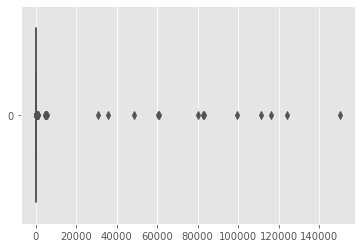

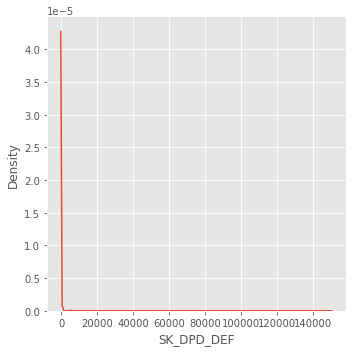

In [213]:
display_dist_col(df_credit_card_bal, 'SK_DPD_DEF')

In [214]:
#### IMPUTATION CORRECTION
df_credit_card_bal['AMT_PAYMENT_TOTAL_CURRENT'].replace({np.nan: df_credit_card_bal['AMT_PAYMENT_TOTAL_CURRENT'].mode()[0]}, inplace=True)
df_credit_card_bal['AMT_TOTAL_RECEIVABLE'].replace({np.nan: df_credit_card_bal['AMT_TOTAL_RECEIVABLE'].mode()[0]}, inplace=True)
df_credit_card_bal['CNT_INSTALMENT_MATURE_CUM'].replace({np.nan: df_credit_card_bal['CNT_INSTALMENT_MATURE_CUM'].mode()[0]}, inplace=True)
df_credit_card_bal['NAME_CONTRACT_STATUS'].replace({np.nan: df_credit_card_bal['NAME_CONTRACT_STATUS'].mode()[0]}, inplace=True)
df_credit_card_bal['SK_DPD'].replace({np.nan: df_credit_card_bal['SK_DPD'].mode()[0]}, inplace=True)
df_credit_card_bal['SK_DPD_DEF'].replace({np.nan: df_credit_card_bal['SK_DPD_DEF'].mode()[0]}, inplace=True)

#### df_previous_application Home Credit

Description: Dossiers précédents de demande de prêt chez Home Credit pour un client<br />
Une ligne correspond à un dossier client. Et un client peut avoir plusieurs dossiers (lignes)<br />
Informations avec de nombreux paramètres.

In [215]:
df_app_train_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 259 columns):
 #    Column                                              Dtype  
---   ------                                              -----  
 0    EMERGENCYSTATE_MODE__No                             uint8  
 1    EMERGENCYSTATE_MODE__UNSPECIFIED                    uint8  
 2    EMERGENCYSTATE_MODE__Yes                            uint8  
 3    WALLSMATERIAL_MODE__Block                           uint8  
 4    WALLSMATERIAL_MODE__Mixed                           uint8  
 5    WALLSMATERIAL_MODE__Monolithic                      uint8  
 6    WALLSMATERIAL_MODE__Others                          uint8  
 7    WALLSMATERIAL_MODE__Panel                           uint8  
 8    WALLSMATERIAL_MODE__Stone, brick                    uint8  
 9    WALLSMATERIAL_MODE__UNSPECIFIED                     uint8  
 10   WALLSMATERIAL_MODE__Wooden                          uint8  
 11   HOUSETYPE_MODE__UNSPECIF

In [216]:
df_previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START  ... NAME_SELLER_INDUSTRY  CNT_PAYMENT  \
0                       15  ...         Connectivity         12.0   
1                       11  ...                  XNA         36.0   
2                       11  ...                  XNA         12.0   
3                        7  ...                  XNA         12.0   
4                        9  ...                  XNA         24.0   

   NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0            middle  POS mobile with interest            365243.0   
1        low_action          Cash X-Sell: low            365243.0   
2              high         Cash X-Sell: high            365243.0   
3            middle       Cash X-Sell: middle            365243.0   
4              high         Cash Street: high                 NaN   

  DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE DAYS_TERMINATION  \
0          -42.0                     300.0          -42.0            -37.0   
1         -134.0                     916.0       365243.0         365243.0   
2         -271.0                      59.0       365243.0         365243.0   
3         -482.0                    -152.0         -182.0           -177.0   
4            NaN                       NaN            NaN              NaN   

  NFLAG_INSURED_ON_APPROVAL  
0                       0.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       NaN  

[5 rows x 37 columns]

In [217]:
with pd.option_context('display.max_rows', None):
    display(
        df_HomeCredit_columns_description[df_HomeCredit_columns_description['Table'] == 'previous_application.csv']\
        .style.set_properties(subset=['Description', 'Special'], **{'width': '300px'})
    )

In [218]:
print(df_previous_application.shape, "\n")
print(df_previous_application.isna().sum())

(1670214, 37) 

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_T

In [219]:
# Observation de valeur typique pour compréhension
with pd.option_context('display.max_columns', None):
    display(df_previous_application[df_previous_application['SK_ID_CURR'] == 271877])

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
735737      1696966      271877     Consumer loans    68258.655   
1567518     2154916      271877     Consumer loans    12417.390   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
735737         1800000.0   1754721.0          180000.0        1800000.0   
1567518         108400.5    119848.5               0.0         108400.5   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                         SATURDAY                       15   
735737                    SATURDAY                       18   
1567518                     SUNDAY                       14   

        FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  \
0                                 Y                       1   
735737                            Y                       1   
1567518                           Y                       1   

         RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED  \
0                 0.000000               0.182832                  0.867336   
735737            0.101325                    NaN                       NaN   
1567518           0.000000                    NaN                       NaN   

        NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION  \
0                          XAP             Approved            -73   
735737                     XAP              Refused           -472   
1567518                    XAP             Approved           -548   

             NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE  \
0        Cash through the bank                XAP             NaN   
735737   Cash through the bank                SCO             NaN   
1567518  Cash through the bank                XAP             NaN   

        NAME_CLIENT_TYPE       NAME_GOODS_CATEGORY NAME_PORTFOLIO  \
0               Repeater                    Mobile            POS   
735737          Repeater  Clothing and Accessories            POS   
1567518              New                 Furniture            POS   

        NAME_PRODUCT_TYPE      CHANNEL_TYPE  SELLERPLACE_AREA  \
0                     XNA      Country-wide                35   
735737                XNA  Regional / Local                55   
1567518               XNA             Stone               196   

        NAME_SELLER_INDUSTRY  CNT_PAYMENT NAME_YIELD_GROUP  \
0               Connectivity         12.0           middle   
735737             Furniture         36.0       low_normal   
1567518            Furniture         12.0           middle   

                PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  \
0          POS mobile with interest            365243.0           -42.0   
735737   POS industry with interest                 NaN             NaN   
1567518  POS industry with interest            365243.0          -512.0   

         DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                            300.0          -42.0             -37.0   
735737                         NaN            NaN               NaN   
1567518                     -182.0         -392.0            -387.0   

         NFLAG_INSURED_ON_APPROVAL  
0                              0.0  
735737                         NaN  
1567518                        0.0

In [220]:
df_app_train_test[df_app_train_test['SK_ID_CURR'] == 271877]

EMERGENCYSTATE_MODE__No  EMERGENCYSTATE_MODE__UNSPECIFIED  \
148238                        1                                 0   

        EMERGENCYSTATE_MODE__Yes  WALLSMATERIAL_MODE__Block  \
148238                         0                          0   

        WALLSMATERIAL_MODE__Mixed  WALLSMATERIAL_MODE__Monolithic  \
148238                          0                               0   

        WALLSMATERIAL_MODE__Others  WALLSMATERIAL_MODE__Panel  \
148238                           0                          0   

        WALLSMATERIAL_MODE__Stone, brick  WALLSMATERIAL_MODE__UNSPECIFIED  \
148238                                 1                                0   

        ...  AMT_REQ_CREDIT_BUREAU_YEAR  YEARS_BIRTH  DAYS_EMPLOYED_ANOMALIE  \
148238  ...                         0.0    39.569863                   False   

        YEARS_EMPLOYED  CREDIT_INCOME_RATIO  AMT_CREDIT_ANOMALIE  \
148238       20.252055              2.37186                    0   

        ANNUITY_INCOME_RATIO  AMT_ANNUITY_ANOMALIE  CREDIT_DURATION  \
148238                11.468                     0        20.682421   

        YEARS_EMPLOYED_RATIO  
148238             51.180503  

[1 rows x 259 columns]

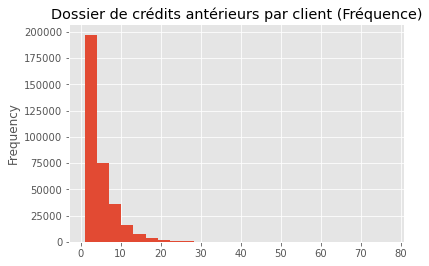

count    338857.000000
mean          4.928964
std           4.220716
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max          77.000000
Name: SK_ID_PREV, dtype: float64


In [221]:
# Combien de dossier précédents par clients ?
df_previous_application.groupby('SK_ID_CURR')['SK_ID_PREV'].count().plot.hist(bins=25)
plt.title("Dossier de crédits antérieurs par client (Fréquence)")
plt.show()
print(df_previous_application.groupby('SK_ID_CURR')['SK_ID_PREV'].count().describe())

In [222]:
df_previous_application['NAME_CASH_LOAN_PURPOSE'].unique()

array(['XAP', 'XNA', 'Repairs', 'Everyday expenses', 'Car repairs',
       'Building a house or an annex', 'Other', 'Journey',
       'Purchase of electronic equipment', 'Medicine',
       'Payments on other loans', 'Urgent needs', 'Buying a used car',
       'Buying a new car', 'Buying a holiday home / land', 'Education',
       'Buying a home', 'Furniture', 'Buying a garage',
       'Business development', 'Wedding / gift / holiday', 'Hobby',
       'Gasification / water supply', 'Refusal to name the goal',
       'Money for a third person'], dtype=object)

In [223]:
df_previous_application.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [225]:
df_prev_app = df_previous_application.copy()

In [226]:
# Idem on transforme les catégories (pd.get_dummies)
for col_name in df_prev_app.columns:
    if df_prev_app[col_name].dtype == 'object':
        print("col_name :", col_name)
        if df_prev_app[col_name].isna().sum() == 0:
            df_prev_app = pd.concat([pd.get_dummies(df_prev_app[col_name], prefix=col_name+'_'), df_prev_app], axis=1)
            df_prev_app.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")
        else:
            df_prev_app[col_name].replace({np.nan: 'UNSPECIFIED'}, inplace=True)
            df_prev_app = pd.concat([pd.get_dummies(df_prev_app[col_name], prefix=col_name+'_'), df_prev_app], axis=1)
            df_prev_app.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")

col_name : NAME_CONTRACT_TYPE
col_name : NAME_CONTRACT_TYPE a été traitée.
col_name : WEEKDAY_APPR_PROCESS_START
col_name : WEEKDAY_APPR_PROCESS_START a été traitée.
col_name : FLAG_LAST_APPL_PER_CONTRACT
col_name : FLAG_LAST_APPL_PER_CONTRACT a été traitée.
col_name : NAME_CASH_LOAN_PURPOSE
col_name : NAME_CASH_LOAN_PURPOSE a été traitée.
col_name : NAME_CONTRACT_STATUS
col_name : NAME_CONTRACT_STATUS a été traitée.
col_name : NAME_PAYMENT_TYPE
col_name : NAME_PAYMENT_TYPE a été traitée.
col_name : CODE_REJECT_REASON
col_name : CODE_REJECT_REASON a été traitée.
col_name : NAME_TYPE_SUITE
col_name : NAME_TYPE_SUITE a été traitée.
col_name : NAME_CLIENT_TYPE
col_name : NAME_CLIENT_TYPE a été traitée.
col_name : NAME_GOODS_CATEGORY
col_name : NAME_GOODS_CATEGORY a été traitée.
col_name : NAME_PORTFOLIO
col_name : NAME_PORTFOLIO a été traitée.
col_name : NAME_PRODUCT_TYPE
col_name : NAME_PRODUCT_TYPE a été traitée.
col_name : CHANNEL_TYPE
col_name : CHANNEL_TYPE a été traitée.
col_name : 

In [227]:
# Ajout de catégroie à la main
df_prev_app = pd.concat([pd.get_dummies(
    df_prev_app['NFLAG_INSURED_ON_APPROVAL'],
    prefix='NFLAG_INSURED_ON_APPROVAL_'), df_prev_app], axis=1
)
df_prev_app.drop(['NFLAG_INSURED_ON_APPROVAL'], axis=1, inplace=True)

In [228]:
df_prev_app.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 167 columns):
 #    Column                                                        Dtype  
---   ------                                                        -----  
 0    NFLAG_INSURED_ON_APPROVAL__0.0                                uint8  
 1    NFLAG_INSURED_ON_APPROVAL__1.0                                uint8  
 2    PRODUCT_COMBINATION__Card Street                              uint8  
 3    PRODUCT_COMBINATION__Card X-Sell                              uint8  
 4    PRODUCT_COMBINATION__Cash                                     uint8  
 5    PRODUCT_COMBINATION__Cash Street: high                        uint8  
 6    PRODUCT_COMBINATION__Cash Street: low                         uint8  
 7    PRODUCT_COMBINATION__Cash Street: middle                      uint8  
 8    PRODUCT_COMBINATION__Cash X-Sell: high                        uint8  
 9    PRODUCT_COMBINATION__Cash X-Sell: low       

In [229]:
df_prev_app['AMT_DOWN_PAYMENT'].unique()

array([    0.  ,      nan, 12649.5 , ...,  4099.95, 55325.25, 50476.5 ])

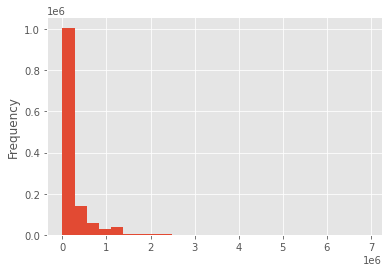

In [230]:
df_prev_app['AMT_GOODS_PRICE'].plot.hist(bins=25)
plt.show()

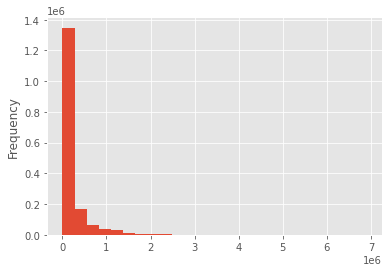

In [231]:
df_prev_app['AMT_CREDIT'].plot.hist(bins=25)
plt.show()

In [232]:
df_prev_app_AMT_GOODS_PRICE_ajusted = df_prev_app['AMT_GOODS_PRICE'].replace({np.nan: 0})
(df_prev_app_AMT_GOODS_PRICE_ajusted / df_prev_app['AMT_CREDIT']).describe()

count    1.333446e+06
mean              inf
std               NaN
min      0.000000e+00
25%      8.959283e-01
50%      1.000000e+00
75%      1.011023e+00
max               inf
dtype: float64

In [233]:
df_prev_app[['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_DOWN_PAYMENT']]\
[df_prev_app['AMT_CREDIT'] == 0]

AMT_CREDIT  AMT_GOODS_PRICE  AMT_ANNUITY  AMT_APPLICATION  \
6               0.0              NaN          NaN              0.0   
7               0.0              NaN          NaN              0.0   
8               0.0              NaN          NaN              0.0   
9               0.0              NaN          NaN              0.0   
22              0.0              NaN          NaN              0.0   
...             ...              ...          ...              ...   
1670180         0.0              NaN          NaN              0.0   
1670186         0.0              NaN          NaN              0.0   
1670187         0.0              NaN          NaN              0.0   
1670190         0.0              NaN          NaN              0.0   
1670193         0.0              NaN          NaN              0.0   

         AMT_DOWN_PAYMENT  
6                     NaN  
7                     NaN  
8                     NaN  
9                     NaN  
22                    NaN  
...                   ...  
1670180               NaN  
1670186               NaN  
1670187               NaN  
1670190               NaN  
1670193               NaN  

[336768 rows x 5 columns]

In [234]:
# Les AMT CREDIT à 0 sont des contrats annulés...
df_prev_app[['AMT_CREDIT', 'NAME_CONTRACT_STATUS__Canceled', 'NAME_CONTRACT_STATUS__Refused', 'NAME_CONTRACT_STATUS__Unused offer']]\
[df_prev_app['AMT_CREDIT'] == 0].tail(25)

AMT_CREDIT  NAME_CONTRACT_STATUS__Canceled  \
1670143         0.0                               1   
1670145         0.0                               1   
1670147         0.0                               1   
1670148         0.0                               1   
1670149         0.0                               1   
1670152         0.0                               1   
1670153         0.0                               1   
1670155         0.0                               1   
1670160         0.0                               1   
1670161         0.0                               0   
1670162         0.0                               1   
1670163         0.0                               1   
1670166         0.0                               1   
1670168         0.0                               1   
1670170         0.0                               1   
1670171         0.0                               1   
1670172         0.0                               1   
1670173         0.0                               1   
1670176         0.0                               1   
1670179         0.0                               1   
1670180         0.0                               1   
1670186         0.0                               1   
1670187         0.0                               1   
1670190         0.0                               1   
1670193         0.0                               0   

         NAME_CONTRACT_STATUS__Refused  NAME_CONTRACT_STATUS__Unused offer  
1670143                              0                                   0  
1670145                              0                                   0  
1670147                              0                                   0  
1670148                              0                                   0  
1670149                              0                                   0  
1670152                              0                                   0  
1670153                              0                                   0  
1670155                              0                                   0  
1670160                              0                                   0  
1670161                              1                                   0  
1670162                              0                                   0  
1670163                              0                                   0  
1670166                              0                                   0  
1670168                              0                                   0  
1670170                              0                                   0  
1670171                              0                                   0  
1670172                              0                                   0  
1670173                              0                                   0  
1670176                              0                                   0  
1670179                              0                                   0  
1670180                              0                                   0  
1670186                              0                                   0  
1670187                              0                                   0  
1670190                              0                                   0  
1670193                              1                                   0

In [235]:
df_prev_app[['AMT_CREDIT']].describe()

AMT_CREDIT
count  1.670213e+06
mean   1.961140e+05
std    3.185746e+05
min    0.000000e+00
25%    2.416050e+04
50%    8.054100e+04
75%    2.164185e+05
max    6.905160e+06

In [237]:
%%time
# %%script echo skipping
gb_prev_app = df_prev_app.groupby('SK_ID_CURR').agg({
    #'PRODUCT_COMBINATION__Card Street': 'sum',
    #'PRODUCT_COMBINATION__Card X-Sell': 'sum',
    #'PRODUCT_COMBINATION__Cash': 'sum',
    #'PRODUCT_COMBINATION__Cash Street: high': 'sum', 
    #'PRODUCT_COMBINATION__Cash Street: low': 'sum', 
    #'PRODUCT_COMBINATION__Cash Street: middle': 'sum', 
    #'PRODUCT_COMBINATION__Cash X-Sell: high': 'sum',  
    #'PRODUCT_COMBINATION__Cash X-Sell: low': 'sum', 
    #'PRODUCT_COMBINATION__Cash X-Sell: middle': 'sum',  
    #'PRODUCT_COMBINATION__POS household with interest': 'sum',
    #'PRODUCT_COMBINATION__POS household without interest': 'sum',  
    #'PRODUCT_COMBINATION__POS industry with interest': 'sum', 
    #'PRODUCT_COMBINATION__POS industry without interest': 'sum',  
    #'PRODUCT_COMBINATION__POS mobile with interest': 'sum',  
    #'PRODUCT_COMBINATION__POS mobile without interest': 'sum',  
    #'PRODUCT_COMBINATION__POS other with interest': 'sum',  
    #'PRODUCT_COMBINATION__POS others without interest': 'sum',  
    #'PRODUCT_COMBINATION__UNSPECIFIED': 'sum',  
    #'NAME_YIELD_GROUP__XNA': 'sum',  
    #'NAME_YIELD_GROUP__high': 'sum',  
    #'NAME_YIELD_GROUP__low_action': 'sum',  
    #'NAME_YIELD_GROUP__low_normal': 'sum',  
    #'NAME_YIELD_GROUP__middle': 'sum',  
    'NAME_SELLER_INDUSTRY__Auto technology': 'sum',  
    'NAME_SELLER_INDUSTRY__Clothing': 'sum',  
    'NAME_SELLER_INDUSTRY__Connectivity': 'sum',  
    'NAME_SELLER_INDUSTRY__Construction': 'sum',  
    'NAME_SELLER_INDUSTRY__Consumer electronics': 'sum',  
    'NAME_SELLER_INDUSTRY__Furniture': 'sum',  
    'NAME_SELLER_INDUSTRY__Industry': 'sum',  
    'NAME_SELLER_INDUSTRY__Jewelry': 'sum',  
    'NAME_SELLER_INDUSTRY__MLM partners': 'sum',  
    'NAME_SELLER_INDUSTRY__Tourism': 'sum',  
    'NAME_SELLER_INDUSTRY__XNA': 'sum',
    'CHANNEL_TYPE__AP+ (Cash loan)': 'sum',  
    'CHANNEL_TYPE__Car dealer': 'sum',  
    'CHANNEL_TYPE__Channel of corporate sales': 'sum',  
    'CHANNEL_TYPE__Contact center': 'sum',  
    'CHANNEL_TYPE__Country-wide': 'sum',  
    'CHANNEL_TYPE__Credit and cash offices': 'sum',  
    'CHANNEL_TYPE__Regional / Local': 'sum',  
    'CHANNEL_TYPE__Stone': 'sum',  
    'NAME_PRODUCT_TYPE__XNA': 'sum',  
    'NAME_PRODUCT_TYPE__walk-in': 'sum',  
    'NAME_PRODUCT_TYPE__x-sell': 'sum',  
    'NAME_PORTFOLIO__Cards': 'sum',  
    'NAME_PORTFOLIO__Cars': 'sum',  
    'NAME_PORTFOLIO__Cash': 'sum',  
    'NAME_PORTFOLIO__POS': 'sum',  
    'NAME_PORTFOLIO__XNA': 'sum',  
    'NAME_GOODS_CATEGORY__Additional Service': 'sum',  
    'NAME_GOODS_CATEGORY__Animals': 'sum',  
    'NAME_GOODS_CATEGORY__Audio/Video': 'sum',  
    'NAME_GOODS_CATEGORY__Auto Accessories': 'sum',  
    'NAME_GOODS_CATEGORY__Clothing and Accessories': 'sum',  
    'NAME_GOODS_CATEGORY__Computers': 'sum',  
    'NAME_GOODS_CATEGORY__Construction Materials': 'sum', 
    'NAME_GOODS_CATEGORY__Consumer Electronics': 'sum',  
    'NAME_GOODS_CATEGORY__Direct Sales': 'sum',  
    'NAME_GOODS_CATEGORY__Education': 'sum',  
    'NAME_GOODS_CATEGORY__Fitness': 'sum',  
    'NAME_GOODS_CATEGORY__Furniture': 'sum',  
    'NAME_GOODS_CATEGORY__Gardening': 'sum',  
    'NAME_GOODS_CATEGORY__Homewares': 'sum',  
    'NAME_GOODS_CATEGORY__House Construction': 'sum',  
    'NAME_GOODS_CATEGORY__Insurance': 'sum',  
    'NAME_GOODS_CATEGORY__Jewelry': 'sum',  
    'NAME_GOODS_CATEGORY__Medical Supplies': 'sum',  
    'NAME_GOODS_CATEGORY__Medicine': 'sum',  
    'NAME_GOODS_CATEGORY__Mobile': 'sum',  
    'NAME_GOODS_CATEGORY__Office Appliances': 'sum',  
    'NAME_GOODS_CATEGORY__Other': 'sum',  
    'NAME_GOODS_CATEGORY__Photo / Cinema Equipment': 'sum',  
    'NAME_GOODS_CATEGORY__Sport and Leisure': 'sum',  
    'NAME_GOODS_CATEGORY__Tourism': 'sum',  
    'NAME_GOODS_CATEGORY__Vehicles': 'sum',  
    'NAME_GOODS_CATEGORY__Weapon': 'sum',  
    'NAME_GOODS_CATEGORY__XNA': 'sum',  
    'NAME_CLIENT_TYPE__New': 'sum',  
    'NAME_CLIENT_TYPE__Refreshed': 'sum',  
    'NAME_CLIENT_TYPE__Repeater': 'sum',  
    'NAME_CLIENT_TYPE__XNA': 'sum',  
    #'NAME_TYPE_SUITE__Children': 'sum',
    #'NAME_TYPE_SUITE__Family': 'sum',  
    #'NAME_TYPE_SUITE__Group of people': 'sum',  
    #'NAME_TYPE_SUITE__Other_A': 'sum',  
    #'NAME_TYPE_SUITE__Other_B': 'sum',  
    #'NAME_TYPE_SUITE__Spouse, partner': 'sum',  
    #'NAME_TYPE_SUITE__UNSPECIFIED': 'sum',  
    #'NAME_TYPE_SUITE__Unaccompanied': 'sum',  
    'CODE_REJECT_REASON__CLIENT': 'sum',  
    'CODE_REJECT_REASON__HC': 'sum',  
    'CODE_REJECT_REASON__LIMIT': 'sum',  
    'CODE_REJECT_REASON__SCO': 'sum',  
    'CODE_REJECT_REASON__SCOFR': 'sum',  
    'CODE_REJECT_REASON__SYSTEM': 'sum',  
    'CODE_REJECT_REASON__VERIF': 'sum',  
    'CODE_REJECT_REASON__XAP': 'sum',  
    'CODE_REJECT_REASON__XNA': 'sum',  
    'NAME_PAYMENT_TYPE__Cash through the bank': 'sum',
    'NAME_PAYMENT_TYPE__Cashless from the account of the employer': 'sum', 
    'NAME_PAYMENT_TYPE__Non-cash from your account': 'sum', 
    'NAME_PAYMENT_TYPE__XNA': 'sum', 
    'NAME_CONTRACT_STATUS__Approved': 'sum',  
    'NAME_CONTRACT_STATUS__Canceled': 'sum', 
    'NAME_CONTRACT_STATUS__Refused': 'sum',  
    'NAME_CONTRACT_STATUS__Unused offer': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Building a house or an annex': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Business development': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Buying a garage': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Buying a holiday home / land': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Buying a home': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Buying a new car': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Buying a used car': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Car repairs': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Education': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Everyday expenses': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Furniture': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Gasification / water supply': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Hobby': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Journey': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Medicine': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Money for a third person': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Other': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Payments on other loans': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Purchase of electronic equipment': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Refusal to name the goal': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__Repairs': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Urgent needs': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__Wedding / gift / holiday': 'sum', 
    'NAME_CASH_LOAN_PURPOSE__XAP': 'sum',  
    'NAME_CASH_LOAN_PURPOSE__XNA': 'sum',  
    #'FLAG_LAST_APPL_PER_CONTRACT__N': 'sum', 
    #'FLAG_LAST_APPL_PER_CONTRACT__Y': 'sum', 
    #'WEEKDAY_APPR_PROCESS_START__FRIDAY': 'sum',  
    #'WEEKDAY_APPR_PROCESS_START__MONDAY': 'sum', 
    #'WEEKDAY_APPR_PROCESS_START__SATURDAY': 'sum', 
    #'WEEKDAY_APPR_PROCESS_START__SUNDAY': 'sum', 
    #'WEEKDAY_APPR_PROCESS_START__THURSDAY': 'sum',  
    #'WEEKDAY_APPR_PROCESS_START__TUESDAY': 'sum',  
    #'WEEKDAY_APPR_PROCESS_START__WEDNESDAY': 'sum',  
    'NAME_CONTRACT_TYPE__Cash loans': 'sum', 
    'NAME_CONTRACT_TYPE__Consumer loans': 'sum', 
    'NAME_CONTRACT_TYPE__Revolving loans': 'sum',  
    'NAME_CONTRACT_TYPE__XNA': 'sum',  
    #'SK_ID_CURR' : lambda x: x.value_counts().index,  # on replace par le mode,  lambda x : ', '.join(x.dropna())
    'AMT_ANNUITY' : lambda x: x.median() - x.mean(),
    'AMT_APPLICATION' : lambda x: x.median() - x.mean(),
    'AMT_CREDIT' : lambda x: x.median() - x.mean(),
    'AMT_DOWN_PAYMENT': lambda x: x.median() - x.mean(),
    'AMT_GOODS_PRICE' : lambda x: x.median() - x.mean(), 
    'RATE_DOWN_PAYMENT' : lambda x: x.median() - x.mean(),                                       
    'DAYS_DECISION' : lambda x: x.median() - x.mean(),
    #'SELLERPLACE_AREA' : lambda x: x.value_counts().index,
    'CNT_PAYMENT' : lambda x: x.median() - x.mean(),
    'NFLAG_INSURED_ON_APPROVAL__0.0' : 'sum',
    'NFLAG_INSURED_ON_APPROVAL__1.0' : 'sum',
})

Wall time: 2min 10s


In [238]:
%%script echo skipping
pickle.dump(gb_prev_app, open(path + '/fichiers_pickle/gb_prev_app.pkl', 'wb'))

Couldn't find program: 'echo'


In [239]:
gb_prev_app = pickle.load(open(path + '/fichiers_pickle/gb_prev_app.pkl', 'rb'))

In [240]:
# gb_prev_app.info(verbose=True)

In [241]:
gb_prev_app.reset_index(inplace=True)
gb_prev_app.head()

SK_ID_CURR  NAME_SELLER_INDUSTRY__Auto technology  \
0      100001                                      0   
1      100002                                      1   
2      100003                                      0   
3      100004                                      0   
4      100005                                      0   

   NAME_SELLER_INDUSTRY__Clothing  NAME_SELLER_INDUSTRY__Connectivity  \
0                               0                                   1   
1                               0                                   0   
2                               0                                   0   
3                               0                                   1   
4                               0                                   1   

   NAME_SELLER_INDUSTRY__Construction  \
0                                   0   
1                                   0   
2                                   0   
3                                   0   
4                                   0   

   NAME_SELLER_INDUSTRY__Consumer electronics  \
0                                           0   
1                                           0   
2                                           1   
3                                           0   
4                                           0   

   NAME_SELLER_INDUSTRY__Furniture  NAME_SELLER_INDUSTRY__Industry  \
0                                0                               0   
1                                0                               0   
2                                1                               0   
3                                0                               0   
4                                0                               0   

   NAME_SELLER_INDUSTRY__Jewelry  NAME_SELLER_INDUSTRY__MLM partners  ...  \
0                              0                                   0  ...   
1                              0                                   0  ...   
2                              0                                   0  ...   
3                              0                                   0  ...   
4                              0                                   0  ...   

   AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  \
0        0.000              0.0         0.0               0.0   
1        0.000              0.0         0.0               0.0   
2     8013.675         -97936.5   -135553.5               0.0   
3        0.000              0.0         0.0               0.0   
4        0.000              0.0         0.0               0.0   

   AMT_GOODS_PRICE  RATE_DOWN_PAYMENT  DAYS_DECISION  CNT_PAYMENT  \
0              0.0                0.0            0.0          0.0   
1              0.0                0.0            0.0          0.0   
2         -97936.5                0.0          477.0          2.0   
3              0.0                0.0            0.0          0.0   
4              0.0                0.0            0.0          0.0   

   NFLAG_INSURED_ON_APPROVAL__0.0  NFLAG_INSURED_ON_APPROVAL__1.0  
0                               1                               0  
1                               1                               0  
2                               1                               2  
3                               1                               0  
4                               1                               0  

[5 rows x 116 columns]

In [242]:
gb_prev_app.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 116 columns):
 #    Column                                                        Dtype  
---   ------                                                        -----  
 0    SK_ID_CURR                                                    int64  
 1    NAME_SELLER_INDUSTRY__Auto technology                         uint8  
 2    NAME_SELLER_INDUSTRY__Clothing                                uint8  
 3    NAME_SELLER_INDUSTRY__Connectivity                            uint8  
 4    NAME_SELLER_INDUSTRY__Construction                            uint8  
 5    NAME_SELLER_INDUSTRY__Consumer electronics                    uint8  
 6    NAME_SELLER_INDUSTRY__Furniture                               uint8  
 7    NAME_SELLER_INDUSTRY__Industry                                uint8  
 8    NAME_SELLER_INDUSTRY__Jewelry                                 uint8  
 9    NAME_SELLER_INDUSTRY__MLM partners            

In [243]:
df_prev_app_new = gb_prev_app.copy()

In [244]:
uint8_col_prev_app = [col for col in df_prev_app_new.columns if df_prev_app_new[col].dtype == 'uint8']
float64_col_prev_app = [col for col in df_prev_app_new.columns if df_prev_app_new[col].dtype == 'float64']

In [245]:
print(len(uint8_col_prev_app))
print(len(float64_col_prev_app))

107
8


In [246]:
#### IMPUTATIONS
# On parse les colonnes par dtype (uint8 et float64) pour déterminer, 
# la meilleure imputation en fonction de l'asymétrie de la distribution. (skewness)
for col in uint8_col_prev_app:
    # si la distribution des valeurs est asymétrique on impute par le mode, sinon la médiane pour les Nan
    if df_prev_app_new[col].skew(skipna=True) > 0.5 or df_prev_app_new[col].skew(skipna=True) < -0.5:
            df_prev_app_new[col].replace({np.nan: df_prev_app_new[col].mode()[0]}, inplace=True)
    else:
        df_prev_app_new[col].replace({np.nan: df_prev_app_new[col].median()}, inplace=True)
        
for col in float64_col_prev_app:
    # si la distribution des valeurs est asymétrique on impute par la mediane, sinon la moyenne pour les Nan
    if df_prev_app_new[col].skew(skipna=True) > 0.5 or df_prev_app_new[col].skew(skipna=True) < -0.5:
            df_prev_app_new[col].replace({np.nan: df_prev_app_new[col].median()}, inplace=True)
    else:
        df_prev_app_new[col].replace({np.nan: df_prev_app_new[col].mean()}, inplace=True)

In [247]:
df_prev_app_new['DAYS_DECISION'].isna().sum()

0

[  0.         477.          91.44444444 236.33333333 553.
 270.28571429  50.5        110.25       273.         -70.        ] 

mean      70.988716
median     0.000000
Name: DAYS_DECISION, dtype: float64 

mode : 0.0 

 0.000000      114957
 53.000000        138
 44.000000        138
 49.000000        137
 37.000000        137
                ...  
-475.250000         1
 12.230769          1
 375.428571         1
 398.791667         1
 52.214286          1
Name: DAYS_DECISION, Length: 64155, dtype: int64 



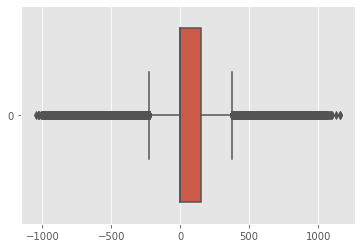

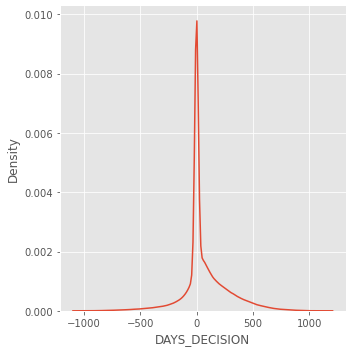

In [248]:
display_dist_col(df_prev_app_new, 'DAYS_DECISION')

In [249]:
# contrôle
df_prev_app_new.shape

(338857, 116)

#### A fusionner : df_prev_app + df_instal_pay (on SK_ID_CURR) + df_pos_cash_bal (on SK_ID_CURR) + df_credit_card_bal (on SK_ID_CURR)

In [250]:
print("df_prev_app_new.shape :", df_prev_app_new.shape)
print("df_instal_pay.shape :", df_instal_pay.shape)
print("df_pos_cash_bal.shape :", df_pos_cash_bal.shape)
print("df_credit_card_bal.shape :", df_credit_card_bal.shape)

df_prev_app_new.shape : (338857, 116)
df_instal_pay.shape : (339587, 4)
df_pos_cash_bal.shape : (337252, 5)
df_credit_card_bal.shape : (103558, 8)


#### renommage des colonnes

In [251]:
prev_app_new_cols = ['prev_app__'+re.sub('[^A-Za-z0-9_]', '_', col.lower()) for col in df_prev_app_new.columns]
# print(prev_app_cols[:5])
df_prev_app_new.columns = prev_app_new_cols
print(df_prev_app_new.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 116 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    prev_app__sk_id_curr                                                    int64  
 1    prev_app__name_seller_industry__auto_technology                         uint8  
 2    prev_app__name_seller_industry__clothing                                uint8  
 3    prev_app__name_seller_industry__connectivity                            uint8  
 4    prev_app__name_seller_industry__construction                            uint8  
 5    prev_app__name_seller_industry__consumer_electronics                    uint8  
 6    prev_app__name_seller_industry__furniture                               uint8  
 7    prev_app__name_seller_industry__industry                                uint8  
 8    prev_app__name_seller_

In [252]:
instal_pay_cols = ['instal_pay__'+re.sub('[^A-Za-z0-9_]', '_', col.lower()) for col in df_instal_pay.columns]
df_instal_pay.columns = instal_pay_cols
print(df_instal_pay.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339587 entries, 0 to 339586
Data columns (total 4 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   instal_pay__sk_id_curr           339587 non-null  int64  
 1   instal_pay__sk_id_prev           339587 non-null  int64  
 2   instal_pay__days_total_pay_diff  339587 non-null  float64
 3   instal_pay__amt_total_diff       339587 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 10.4 MB
None


In [253]:
pos_cash_bal_cols = ['pos_cash_bal__'+re.sub('[^A-Za-z0-9_]', '_', col.lower()) for col in df_pos_cash_bal.columns]
df_pos_cash_bal.columns = pos_cash_bal_cols
print(df_pos_cash_bal.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337252 entries, 0 to 337251
Data columns (total 5 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   pos_cash_bal__sk_id_curr            337252 non-null  int64
 1   pos_cash_bal__sk_id_prev            337252 non-null  int64
 2   pos_cash_bal__name_contract_status  337252 non-null  int64
 3   pos_cash_bal__sk_dpd                337252 non-null  int64
 4   pos_cash_bal__sk_dpd_def            337252 non-null  int64
dtypes: int64(5)
memory usage: 12.9 MB
None


In [254]:
credit_card_bal_cols = ['credit_card_bal__'+re.sub('[^A-Za-z0-9_]', '_', col.lower()) for col in df_credit_card_bal.columns]
df_credit_card_bal.columns = credit_card_bal_cols
print(df_credit_card_bal.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103558 entries, 0 to 103557
Data columns (total 8 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   credit_card_bal__sk_id_curr                 103558 non-null  int64  
 1   credit_card_bal__sk_id_prev                 103558 non-null  int64  
 2   credit_card_bal__amt_payment_total_current  103558 non-null  float64
 3   credit_card_bal__amt_total_receivable       103558 non-null  float64
 4   credit_card_bal__cnt_instalment_mature_cum  103558 non-null  int64  
 5   credit_card_bal__name_contract_status       103558 non-null  int64  
 6   credit_card_bal__sk_dpd                     103558 non-null  int64  
 7   credit_card_bal__sk_dpd_def                 103558 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 6.3 MB
None


##### Vérification des SK_ID_CURR

In [255]:
print(df_credit_card_bal.shape)
display(df_credit_card_bal['credit_card_bal__sk_id_curr'].head())

(103558, 8)


0    100006
1    100011
2    100013
3    100021
4    100023
Name: credit_card_bal__sk_id_curr, dtype: int64

In [256]:
print(df_pos_cash_bal.shape)
display(df_pos_cash_bal['pos_cash_bal__sk_id_curr'].head())

(337252, 5)


0    100001
1    100002
2    100003
3    100004
4    100005
Name: pos_cash_bal__sk_id_curr, dtype: int64

In [257]:
print(df_instal_pay.shape)
display(df_instal_pay['instal_pay__sk_id_curr'].head())

(339587, 4)


0    100001
1    100002
2    100003
3    100004
4    100005
Name: instal_pay__sk_id_curr, dtype: int64

In [258]:
check_diff = \
list(set(df_pos_cash_bal['pos_cash_bal__sk_id_curr'].unique()) - set(df_credit_card_bal['credit_card_bal__sk_id_curr'].unique()))

In [259]:
len(check_diff)

236794

In [260]:
# rappel
df_app_train_test['SK_ID_CURR'].shape

(356255,)

In [261]:
# rappel
print(df_prev_app_new['prev_app__sk_id_curr'].shape)
display(df_prev_app_new['prev_app__sk_id_curr'].head())

(338857,)


0    100001
1    100002
2    100003
3    100004
4    100005
Name: prev_app__sk_id_curr, dtype: int64

#### fusion des dataframes

In [262]:
df_prev_home = df_prev_app_new.merge(
    df_instal_pay, 
    how='left',
    left_on='prev_app__sk_id_curr',
    right_on='instal_pay__sk_id_curr'
)

df_prev_home = df_prev_home.merge(
    df_pos_cash_bal,
    how='left',
    left_on='prev_app__sk_id_curr',
    right_on='pos_cash_bal__sk_id_curr'
    
)
df_prev_home = df_prev_home.merge(
    df_credit_card_bal,
    how='left',
    left_on='prev_app__sk_id_curr',
    right_on='credit_card_bal__sk_id_curr'
)

In [263]:
df_prev_home.shape

(338857, 133)

In [264]:
df_prev_home.isna().sum()

prev_app__sk_id_curr                                    0
prev_app__name_seller_industry__auto_technology         0
prev_app__name_seller_industry__clothing                0
prev_app__name_seller_industry__connectivity            0
prev_app__name_seller_industry__construction            0
                                                    ...  
credit_card_bal__amt_total_receivable              236148
credit_card_bal__cnt_instalment_mature_cum         236148
credit_card_bal__name_contract_status              236148
credit_card_bal__sk_dpd                            236148
credit_card_bal__sk_dpd_def                        236148
Length: 133, dtype: int64

#### df_bureau_balance

In [265]:
df_bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [266]:
len(df_bureau_balance['SK_ID_BUREAU'].unique()) == len(df_bureau_balance)

False

In [267]:
df_bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [268]:
df_bureau_balance = pd.concat([pd.get_dummies(
    df_bureau_balance['STATUS'],
    prefix='status_'), df_bureau_balance], axis=1
)
df_bureau_balance.drop(['STATUS'], axis=1, inplace=True)
df_bureau_balance.drop(['MONTHS_BALANCE'], axis=1, inplace=True)

In [269]:
df_bureau_balance.rename(columns={'SK_ID_BUREAU': 'sk_id_bureau'}, inplace=True)

In [270]:
df_bureau_balance.head()

status__0  status__1  status__2  status__3  status__4  status__5  \
0          0          0          0          0          0          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   status__C  status__X  sk_id_bureau  
0          1          0       5715448  
1          1          0       5715448  
2          1          0       5715448  
3          1          0       5715448  
4          1          0       5715448

In [271]:
df_bureau_balance['sk_id_bureau'].value_counts()

5645521    97
6733619    97
6176606    97
6321834    97
6356432    97
           ..
6212548     1
5819605     1
5626301     1
5626300     1
6803532     1
Name: sk_id_bureau, Length: 817395, dtype: int64

In [272]:
df_bureau_bal = df_bureau_balance.groupby('sk_id_bureau').agg({
    'status__0': 'sum',
    'status__1': 'sum',
    'status__2': 'sum',
    'status__3': 'sum',
    'status__4': 'sum',
    'status__5': 'sum',
    'status__C': 'sum',
    'status__X': 'sum',
})

df_bureau_bal.reset_index(inplace=True)

In [273]:
df_bureau_bal.head()

sk_id_bureau  status__0  status__1  status__2  status__3  status__4  \
0       5001709          0          0          0          0          0   
1       5001710          5          0          0          0          0   
2       5001711          3          0          0          0          0   
3       5001712         10          0          0          0          0   
4       5001713          0          0          0          0          0   

   status__5  status__C  status__X  
0          0         86         11  
1          0         48         30  
2          0          0          1  
3          0          9          0  
4          0          0         22

In [274]:
# contrôle
len(df_bureau_bal['sk_id_bureau'].unique()) == len(df_bureau_bal)

True

In [275]:
df_bureau_bal.shape

(817395, 9)

#### Merge de df_bureau + df_bureau_bal avant aggrégation (à cause des sk_id_bureau)
un client (SK_ID_CURR) peut avoir plusieurs SK_ID_BUREAU uniques (pas de duplication comme pour SK_ID_PREV)

In [276]:
df_bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].sort_values(by='SK_ID_CURR').head(10)

SK_ID_CURR  SK_ID_BUREAU
248487      100001       5896633
248485      100001       5896631
248490      100001       5896636
248489      100001       5896635
248486      100001       5896632
248484      100001       5896630
248488      100001       5896634
675689      100002       6158909
675688      100002       6158908
675687      100002       6158907

In [277]:
df_bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].sort_values(by='SK_ID_BUREAU').head(10)

SK_ID_BUREAU  SK_ID_CURR
1706035       5000000      166497
1706036       5000001      166497
61505         5000002      166497
61506         5000003      166497
61507         5000004      166497
61508         5000005      356385
1706037       5000006      375916
61509         5000009      375916
61510         5000010      375916
61511         5000011      375916

In [278]:
bureau_bal_cols = ['bureau_bal__'+col for col in df_bureau_bal.columns]
df_bureau_bal.columns = bureau_bal_cols
df_bureau_bal.head()

bureau_bal__sk_id_bureau  bureau_bal__status__0  bureau_bal__status__1  \
0                   5001709                      0                      0   
1                   5001710                      5                      0   
2                   5001711                      3                      0   
3                   5001712                     10                      0   
4                   5001713                      0                      0   

   bureau_bal__status__2  bureau_bal__status__3  bureau_bal__status__4  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   bureau_bal__status__5  bureau_bal__status__C  bureau_bal__status__X  
0                      0                     86                     11  
1                      0                     48                     30  
2                      0                      0                      1  
3                      0                      9                      0  
4                      0                      0                     22

In [279]:
df_bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [280]:
df_pre_prev_bureau = df_bureau.merge(
    df_bureau_bal,
    how='left',
    left_on='SK_ID_BUREAU',
    right_on='bureau_bal__sk_id_bureau'
)

df_pre_prev_bureau.drop('bureau_bal__sk_id_bureau', axis=1, inplace=True)

In [281]:
print("df_pre_prev_bureau.shape", df_pre_prev_bureau.shape)
print("df_bureau.shape", df_bureau.shape)
print("df_bureau_bal.shape", df_bureau_bal.shape)

df_pre_prev_bureau.shape (1716428, 25)
df_bureau.shape (1716428, 17)
df_bureau_bal.shape (817395, 9)


In [282]:
# contrôles
print(len(df_bureau_bal['bureau_bal__sk_id_bureau'].unique()))
print(len(df_bureau['SK_ID_BUREAU'].unique()))
print(len(df_pre_prev_bureau['SK_ID_BUREAU'].unique()))

817395
1716428
1716428


In [283]:
df_pre_prev_bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  ...  DAYS_CREDIT_UPDATE  \
0                     NaN                   0  ...                -131   
1                     NaN                   0  ...                 -20   
2                     NaN                   0  ...                 -16   
3                     NaN                   0  ...                 -16   
4                 77674.5                   0  ...                 -21   

   AMT_ANNUITY  bureau_bal__status__0  bureau_bal__status__1  \
0          NaN                    NaN                    NaN   
1          NaN                    NaN                    NaN   
2          NaN                    NaN                    NaN   
3          NaN                    NaN                    NaN   
4          NaN                    NaN                    NaN   

  bureau_bal__status__2  bureau_bal__status__3  bureau_bal__status__4  \
0                   NaN                    NaN                    NaN   
1                   NaN                    NaN                    NaN   
2                   NaN                    NaN                    NaN   
3                   NaN                    NaN                    NaN   
4                   NaN                    NaN                    NaN   

   bureau_bal__status__5  bureau_bal__status__C  bureau_bal__status__X  
0                    NaN                    NaN                    NaN  
1                    NaN                    NaN                    NaN  
2                    NaN                    NaN                    NaN  
3                    NaN                    NaN                    NaN  
4                    NaN                    NaN                    NaN  

[5 rows x 25 columns]

In [284]:
df_pre_prev_bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 25 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
 17  bureau_bal__status__0   float64
 18  bureau_bal__status__1   float64
 19  bureau_bal__status__2   float64
 20  bureau_bal__status__3   float64
 21  bureau_bal__status__4   float64

#### df_bureau -> df_pre_prev_bureau

In [285]:
df_pre_prev_bureau['CREDIT_TYPE'].unique()

array(['Consumer credit', 'Credit card', 'Mortgage', 'Car loan',
       'Microloan', 'Loan for working capital replenishment',
       'Loan for business development', 'Real estate loan',
       'Unknown type of loan', 'Another type of loan',
       'Cash loan (non-earmarked)', 'Loan for the purchase of equipment',
       'Mobile operator loan', 'Interbank credit',
       'Loan for purchase of shares (margin lending)'], dtype=object)

In [286]:
# Idem on transforme les catégories (pd.get_dummies)
for col_name in df_pre_prev_bureau.columns:
    if df_pre_prev_bureau[col_name].dtype == 'object':
        print("col_name :", col_name)
        if df_pre_prev_bureau[col_name].isna().sum() == 0:
            df_pre_prev_bureau = pd.concat([
                pd.get_dummies(df_pre_prev_bureau[col_name], prefix=col_name+'_'),
                df_pre_prev_bureau
            ], axis=1)
            df_pre_prev_bureau.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")
        else:
            df_pre_prev_bureau[col_name].replace({np.nan: 'unspecified'}, inplace=True)
            df_pre_prev_bureau = pd.concat([
                pd.get_dummies(df_pre_prev_bureau[col_name], prefix=col_name+'_'),
                df_pre_prev_bureau
            ], axis=1)
            df_pre_prev_bureau.drop([col_name], axis=1, inplace=True)
            print("col_name :", col_name, "a été traitée.")

col_name : CREDIT_ACTIVE
col_name : CREDIT_ACTIVE a été traitée.
col_name : CREDIT_CURRENCY
col_name : CREDIT_CURRENCY a été traitée.
col_name : CREDIT_TYPE
col_name : CREDIT_TYPE a été traitée.


In [287]:
pre_prev_bureau_cols = ['bureau__'+re.sub('[^A-Za-z0-9_]', '_', col.lower()) for col in df_pre_prev_bureau.columns]
df_pre_prev_bureau.columns = pre_prev_bureau_cols
print(df_pre_prev_bureau.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 45 columns):
 #   Column                                                             Dtype  
---  ------                                                             -----  
 0   bureau__credit_type__another_type_of_loan                          uint8  
 1   bureau__credit_type__car_loan                                      uint8  
 2   bureau__credit_type__cash_loan__non_earmarked_                     uint8  
 3   bureau__credit_type__consumer_credit                               uint8  
 4   bureau__credit_type__credit_card                                   uint8  
 5   bureau__credit_type__interbank_credit                              uint8  
 6   bureau__credit_type__loan_for_business_development                 uint8  
 7   bureau__credit_type__loan_for_purchase_of_shares__margin_lending_  uint8  
 8   bureau__credit_type__loan_for_the_purchase_of_equipment            uint8  
 9   bu

In [288]:
# contrôle
df_pre_prev_bureau['bureau__sk_id_curr'].value_counts()

120860    116
169704     94
318065     78
251643     61
425396     60
         ... 
405288      1
413028      1
288569      1
215224      1
235871      1
Name: bureau__sk_id_curr, Length: 305811, dtype: int64

In [289]:
%%script echo skipping
df_prev_bureau = df_pre_prev_bureau.groupby('bureau__sk_id_curr').agg({
    'bureau__credit_type__another_type_of_loan': 'sum',
    'bureau__credit_type__car_loan': 'sum',
    'bureau__credit_type__cash_loan__non_earmarked_': 'sum',  
    'bureau__credit_type__consumer_credit': 'sum', 
    'bureau__credit_type__credit_card': 'sum', 
    'bureau__credit_type__interbank_credit': 'sum', 
    'bureau__credit_type__loan_for_business_development': 'sum', 
    'bureau__credit_type__loan_for_purchase_of_shares__margin_lending_': 'sum',  
    'bureau__credit_type__loan_for_the_purchase_of_equipment': 'sum', 
    'bureau__credit_type__loan_for_working_capital_replenishment': 'sum', 
    'bureau__credit_type__microloan': 'sum',
    'bureau__credit_type__mobile_operator_loan': 'sum',  
    'bureau__credit_type__mortgage': 'sum', 
    'bureau__credit_type__real_estate_loan': 'sum', 
    'bureau__credit_type__unknown_type_of_loan': 'sum',  
    'bureau__credit_currency__currency_1': 'sum',  
    'bureau__credit_currency__currency_2': 'sum',  
    'bureau__credit_currency__currency_3': 'sum',  
    'bureau__credit_currency__currency_4': 'sum', 
    'bureau__credit_active__active': 'sum', 
    'bureau__credit_active__bad_debt': 'sum', 
    'bureau__credit_active__closed': 'sum', 
    'bureau__credit_active__sold': 'sum',
    'bureau__sk_id_bureau': 'sum',
    'bureau__credit_day_overdue': lambda x: x.median() - x.mean(), # exemple si c'est négatif (valeur haute type outlier)
    'bureau__days_credit_enddate': lambda x: x.median() - x.mean(),
    'bureau__amt_credit_max_overdue': 'sum', # cela fait une somme cumulée ici -> intéressant
    'bureau__cnt_credit_prolong': 'sum',
    'bureau__amt_credit_sum': 'sum', # montant total de crédit (client est très demandeur de crédits ?)
    'bureau__amt_credit_sum_debt': 'sum',
    'bureau__amt_credit_sum_limit':lambda x: x.median() - x.mean(), # négatif -> limite haute ? confiance sur client ?
    'bureau__amt_credit_sum_overdue': 'sum', # total de dettes cumulées sur les crédits !
    'bureau__amt_annuity': lambda x: x.median() - x.mean(), # pour connaître la variation dans le temps
    'bureau__bureau_bal__status__0': 'sum',
    'bureau__bureau_bal__status__1': 'sum',
    'bureau__bureau_bal__status__2': 'sum',
    'bureau__bureau_bal__status__3': 'sum',
    'bureau__bureau_bal__status__4': 'sum',
    'bureau__bureau_bal__status__5': 'sum',
    'bureau__bureau_bal__status__c': 'sum',
    'bureau__bureau_bal__status__x': 'sum',
})

df_prev_bureau.reset_index(inplace=True)

Couldn't find program: 'echo'


In [290]:
%%script echo skipping
pickle.dump(df_prev_bureau, open(path + '/fichiers_pickle/df_prev_bureau.pkl', 'wb'))

Couldn't find program: 'echo'


In [291]:
df_prev_bureau = pickle.load(open(path + '/fichiers_pickle/df_prev_bureau.pkl', 'rb'))

In [292]:
df_prev_bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 42 columns):
 #   Column                                                             Non-Null Count   Dtype  
---  ------                                                             --------------   -----  
 0   bureau__sk_id_curr                                                 305811 non-null  int64  
 1   bureau__credit_type__another_type_of_loan                          305811 non-null  uint8  
 2   bureau__credit_type__car_loan                                      305811 non-null  uint8  
 3   bureau__credit_type__cash_loan__non_earmarked_                     305811 non-null  uint8  
 4   bureau__credit_type__consumer_credit                               305811 non-null  uint8  
 5   bureau__credit_type__credit_card                                   305811 non-null  uint8  
 6   bureau__credit_type__interbank_credit                              305811 non-null  uint8  
 7   bureau__cre

[-3545.35714286     0.                    nan -1420.5
 -3012.01071429 -1986.1875     -2367.         -9997.2
 -2858.07214286 -4901.72727273] 

mean     -3758.950773
median       0.000000
Name: bureau__amt_annuity, dtype: float64 

mode : 0.0 

 0.000000         64055
-4500.000000        132
-1500.000000        100
-1125.000000         83
-2250.000000         77
                  ...  
 9645.000000          1
-2516.247000          1
-9045.000000          1
-1060.363636          1
-102768.465000        1
Name: bureau__amt_annuity, Length: 42953, dtype: int64 



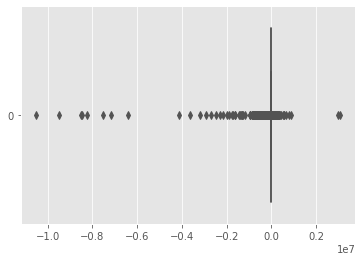

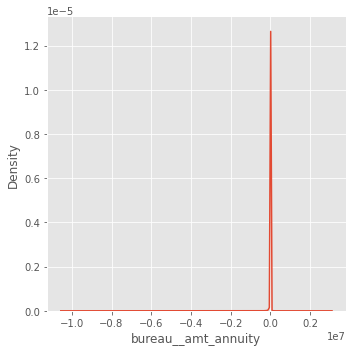

In [293]:
display_dist_col(df_prev_bureau, 'bureau__amt_annuity')

In [294]:
len(df_prev_bureau['bureau__amt_annuity'].unique())

42954

In [295]:
#### IMPUTATIONS CORRECTIONS
for col in df_prev_bureau.columns:
    # si la distribution des valeurs est asymétrique on impute par le mode, sinon la médiane pour les Nan
    if df_prev_bureau[col].skew(skipna=True) > 0.5 or df_prev_bureau[col].skew(skipna=True) < -0.5:
        if len(df_prev_bureau[col].unique()) < 10: # moins de 10 le mode est plus approprié
            df_prev_bureau[col].replace({np.nan: df_prev_bureau[col].mode()[0]}, inplace=True)
        else:
            df_prev_bureau[col].replace({np.nan: df_prev_bureau[col].median()}, inplace=True)
    else:
        df_prev_bureau[col].replace({np.nan: df_prev_bureau[col].mean()}, inplace=True)

In [296]:
df_prev_bureau.isna().sum().sum()

0

#### Fusion globale: df_app_train_test + df_prev_home + df_prev_bureau

In [297]:
print("df_app_train_test.shape", df_app_train_test.shape)
print("df_prev_home.shape :", df_prev_home.shape)
print("df_prev_bureau.shape :", df_prev_bureau.shape)

df_app_train_test.shape (356255, 259)
df_prev_home.shape : (338857, 133)
df_prev_bureau.shape : (305811, 42)


In [298]:
print("df_app_train_test -> Nan:", df_app_train_test.isna().sum().sum())
print("df_prev_home -> Nan:", df_prev_home.isna().sum().sum())
print("df_prev_bureau. -> Nan:", df_prev_bureau.isna().sum().sum())

df_app_train_test -> Nan: 9854573
df_prev_home -> Nan: 1908457
df_prev_bureau. -> Nan: 0


##### Réduction des Nan avant fusion: df_app_train_test

In [299]:
with pd.option_context('display.max_rows', None):
    print(df_app_train_test.isna().sum())

EMERGENCYSTATE_MODE__No                                    0
EMERGENCYSTATE_MODE__UNSPECIFIED                           0
EMERGENCYSTATE_MODE__Yes                                   0
WALLSMATERIAL_MODE__Block                                  0
WALLSMATERIAL_MODE__Mixed                                  0
WALLSMATERIAL_MODE__Monolithic                             0
WALLSMATERIAL_MODE__Others                                 0
WALLSMATERIAL_MODE__Panel                                  0
WALLSMATERIAL_MODE__Stone, brick                           0
WALLSMATERIAL_MODE__UNSPECIFIED                            0
WALLSMATERIAL_MODE__Wooden                                 0
HOUSETYPE_MODE__UNSPECIFIED                                0
HOUSETYPE_MODE__block of flats                             0
HOUSETYPE_MODE__specific housing                           0
HOUSETYPE_MODE__terraced house                             0
FONDKAPREMONT_MODE__UNSPECIFIED                            0
FONDKAPREMONT_MODE__not 

In [300]:
df_app_train_test['NONLIVINGAPARTMENTS_MODE'].value_counts()

0.0000    68893
0.0039    16439
0.0078     7452
0.0117     4247
0.0156     2957
          ...  
0.4319        1
0.8949        1
0.7626        1
0.7082        1
0.6537        1
Name: NONLIVINGAPARTMENTS_MODE, Length: 178, dtype: int64

In [301]:
df_app_train_test['NONLIVINGAPARTMENTS_MODE'].mode()

0    0.0
dtype: float64

In [302]:
df_app_train_test['NONLIVINGAPARTMENTS_MODE'].mean()

0.008115959741851203

##### Imputation pour la moyenne ou le mode: dépend du type de données suivant les colonnes

In [303]:
df_app_train_test.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Data columns (total 259 columns):
 #    Column                                              Dtype  
---   ------                                              -----  
 0    EMERGENCYSTATE_MODE__No                             uint8  
 1    EMERGENCYSTATE_MODE__UNSPECIFIED                    uint8  
 2    EMERGENCYSTATE_MODE__Yes                            uint8  
 3    WALLSMATERIAL_MODE__Block                           uint8  
 4    WALLSMATERIAL_MODE__Mixed                           uint8  
 5    WALLSMATERIAL_MODE__Monolithic                      uint8  
 6    WALLSMATERIAL_MODE__Others                          uint8  
 7    WALLSMATERIAL_MODE__Panel                           uint8  
 8    WALLSMATERIAL_MODE__Stone, brick                    uint8  
 9    WALLSMATERIAL_MODE__UNSPECIFIED                     uint8  
 10   WALLSMATERIAL_MODE__Wooden                          uint8  
 11   HOUSETYPE_MODE__UNSPECIF

In [ ]:
# TARGET -> on garde les NAN à l'exclusion

In [304]:
# Autres approches : MCAR, MAR, MNAR (pour une question de rapidité et d'efficacité, je choisis Mean, Median, Mode(s))
col_imp_by_mean = [
    'EXT_SOURCE_1', 
]

col_imp_by_median = [
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'OWN_CAR_AGE',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ELEVATORS_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
    'NONLIVINGAPARTMENTS_AVG',
    'NONLIVINGAREA_AVG',
    'APARTMENTS_MODE',
    'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ELEVATORS_MODE',
    'ENTRANCES_MODE',
    'FLOORSMAX_MODE',
    'FLOORSMIN_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE',
    'NONLIVINGAREA_MODE',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ELEVATORS_MEDI',
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI',
    'FLOORSMIN_MEDI',
    'LANDAREA_MEDI',
    'LIVINGAPARTMENTS_MEDI',
    'LIVINGAREA_MEDI',
    'NONLIVINGAPARTMENTS_MEDI',
    'NONLIVINGAREA_MEDI',
    'TOTALAREA_MODE',
    'DAYS_LAST_PHONE_CHANGE',
    'AMT_REQ_CREDIT_BUREAU_YEAR',
    'YEARS_EMPLOYED',
    'CREDIT_INCOME_RATIO',
    'ANNUITY_INCOME_RATIO',
    'CREDIT_DURATION',
    'YEARS_EMPLOYED_RATIO',
]
col_imp_by_mode = [
    'CNT_FAM_MEMBERS',
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',  
]

[nan 26. 17.  8. 23.  7. 14.  1.  3. 13.] 

mean      12.023741
median     9.000000
Name: OWN_CAR_AGE, dtype: float64 

mode : 7.0 

7.0     8625
3.0     7397
8.0     6984
4.0     6909
6.0     6880
        ... 
48.0       1
57.0       1
69.0       1
47.0       1
74.0       1
Name: OWN_CAR_AGE, Length: 63, dtype: int64 



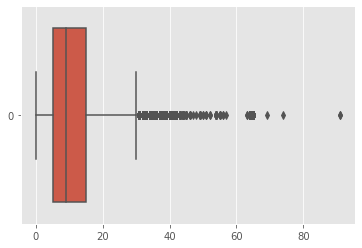

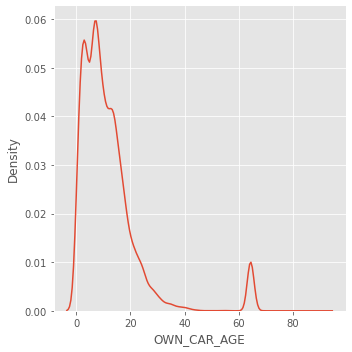

In [305]:
display_dist_col(df_app_train_test, 'OWN_CAR_AGE')

In [306]:
#### IMPUTATIONS
# On effectue les imputations nécessaires (df_app_train_test)
for col in col_imp_by_mean:
    df_app_train_test[col].replace(
        {np.nan:  df_app_train_test[col].mean()}, inplace=True
    )
for col in col_imp_by_median:
    df_app_train_test[col].replace(
        {np.nan:  df_app_train_test[col].median()}, inplace=True
    )
for col in col_imp_by_mode:
    df_app_train_test[col].replace(
        {np.nan:  df_app_train_test[col].mode()[0]}, inplace=True
    )

In [307]:
# contrôle
with pd.option_context('display.max_rows', None):
    print(df_app_train_test.isna().sum())

EMERGENCYSTATE_MODE__No                                   0
EMERGENCYSTATE_MODE__UNSPECIFIED                          0
EMERGENCYSTATE_MODE__Yes                                  0
WALLSMATERIAL_MODE__Block                                 0
WALLSMATERIAL_MODE__Mixed                                 0
WALLSMATERIAL_MODE__Monolithic                            0
WALLSMATERIAL_MODE__Others                                0
WALLSMATERIAL_MODE__Panel                                 0
WALLSMATERIAL_MODE__Stone, brick                          0
WALLSMATERIAL_MODE__UNSPECIFIED                           0
WALLSMATERIAL_MODE__Wooden                                0
HOUSETYPE_MODE__UNSPECIFIED                               0
HOUSETYPE_MODE__block of flats                            0
HOUSETYPE_MODE__specific housing                          0
HOUSETYPE_MODE__terraced house                            0
FONDKAPREMONT_MODE__UNSPECIFIED                           0
FONDKAPREMONT_MODE__not specified       

##### Merge

In [308]:
# df_prev_home.info(verbose=True)
# df_prev_bureau.info(verbose=True)
# df_app_train_test.info(verbose=True)

In [309]:
diff_app_train_test_prev_home = \
list(set(df_app_train_test['SK_ID_CURR'].unique()) - set(df_prev_home['credit_card_bal__sk_id_curr'].unique()))
print(len(diff_app_train_test_prev_home))

253546


In [310]:
df_app_train_test['SK_ID_CURR'].head()

0    100002
1    100003
2    100004
3    100006
4    100007
Name: SK_ID_CURR, dtype: int64

In [311]:
df_prev_home.isna().sum()

prev_app__sk_id_curr                                    0
prev_app__name_seller_industry__auto_technology         0
prev_app__name_seller_industry__clothing                0
prev_app__name_seller_industry__connectivity            0
prev_app__name_seller_industry__construction            0
                                                    ...  
credit_card_bal__amt_total_receivable              236148
credit_card_bal__cnt_instalment_mature_cum         236148
credit_card_bal__name_contract_status              236148
credit_card_bal__sk_dpd                            236148
credit_card_bal__sk_dpd_def                        236148
Length: 133, dtype: int64

In [312]:
len(diff_app_train_test_prev_home) / len(df_app_train_test)

0.7116980814304361

#### Merge final: intervient sur les SK_ID_CURR de df_app_train_test uniquement
En effet les SK_ID_CURR des différents dataframes ne sont pas communs et cela créé des NaN inutilement.

In [313]:
print(df_prev_home['credit_card_bal__sk_id_curr'].shape)
print(df_prev_bureau['bureau__sk_id_curr'].shape)
print(df_app_train_test['SK_ID_CURR'].shape)

(338857,)
(305811,)
(356255,)


In [314]:
df_prev_home['prev_app__sk_id_curr'].head()

0    100001
1    100002
2    100003
3    100004
4    100005
Name: prev_app__sk_id_curr, dtype: int64

In [315]:
df_prev_home['pos_cash_bal__sk_id_curr'].head()

0    100001.0
1    100002.0
2    100003.0
3    100004.0
4    100005.0
Name: pos_cash_bal__sk_id_curr, dtype: float64

In [316]:
df_prev_home['credit_card_bal__sk_id_curr'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: credit_card_bal__sk_id_curr, dtype: float64

In [317]:
print(len(list(set(df_app_train_test['SK_ID_CURR'].unique()) - set(df_prev_home['credit_card_bal__sk_id_curr'].unique()))))
# df_prev_home a été créé sur des jointures gauches à partir de la clef prev_app__sk_id_curr -> donc on merge dessus
print(len(list(set(df_app_train_test['SK_ID_CURR'].unique()) - set(df_prev_home['prev_app__sk_id_curr'].unique()))))

253546
17398


In [318]:
print(len(list(set(df_app_train_test['SK_ID_CURR'].unique()) - set(df_prev_bureau['bureau__sk_id_curr'].unique()))))

50444


In [319]:
df_prev_bureau.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 42 columns):
 #   Column                                                             Non-Null Count   Dtype  
---  ------                                                             --------------   -----  
 0   bureau__sk_id_curr                                                 305811 non-null  int64  
 1   bureau__credit_type__another_type_of_loan                          305811 non-null  uint8  
 2   bureau__credit_type__car_loan                                      305811 non-null  uint8  
 3   bureau__credit_type__cash_loan__non_earmarked_                     305811 non-null  uint8  
 4   bureau__credit_type__consumer_credit                               305811 non-null  uint8  
 5   bureau__credit_type__credit_card                                   305811 non-null  uint8  
 6   bureau__credit_type__interbank_credit                              305811 non-null  uint8  
 7   bureau__cre

In [320]:
df_custom_global = df_app_train_test.merge(
    df_prev_home, 
    how='left',
    left_on='SK_ID_CURR',
    right_on='prev_app__sk_id_curr'
)

df_custom_global = df_custom_global.merge(
    df_prev_bureau,
    how='left',
    left_on='SK_ID_CURR',
    right_on='bureau__sk_id_curr'
    
)

In [321]:
# contrôle
diff_SK_ID_CURR = list(set(df_app_train_test['SK_ID_CURR'].unique()) - set(df_custom_global['SK_ID_CURR'].unique()))
print(len(diff_SK_ID_CURR))

0


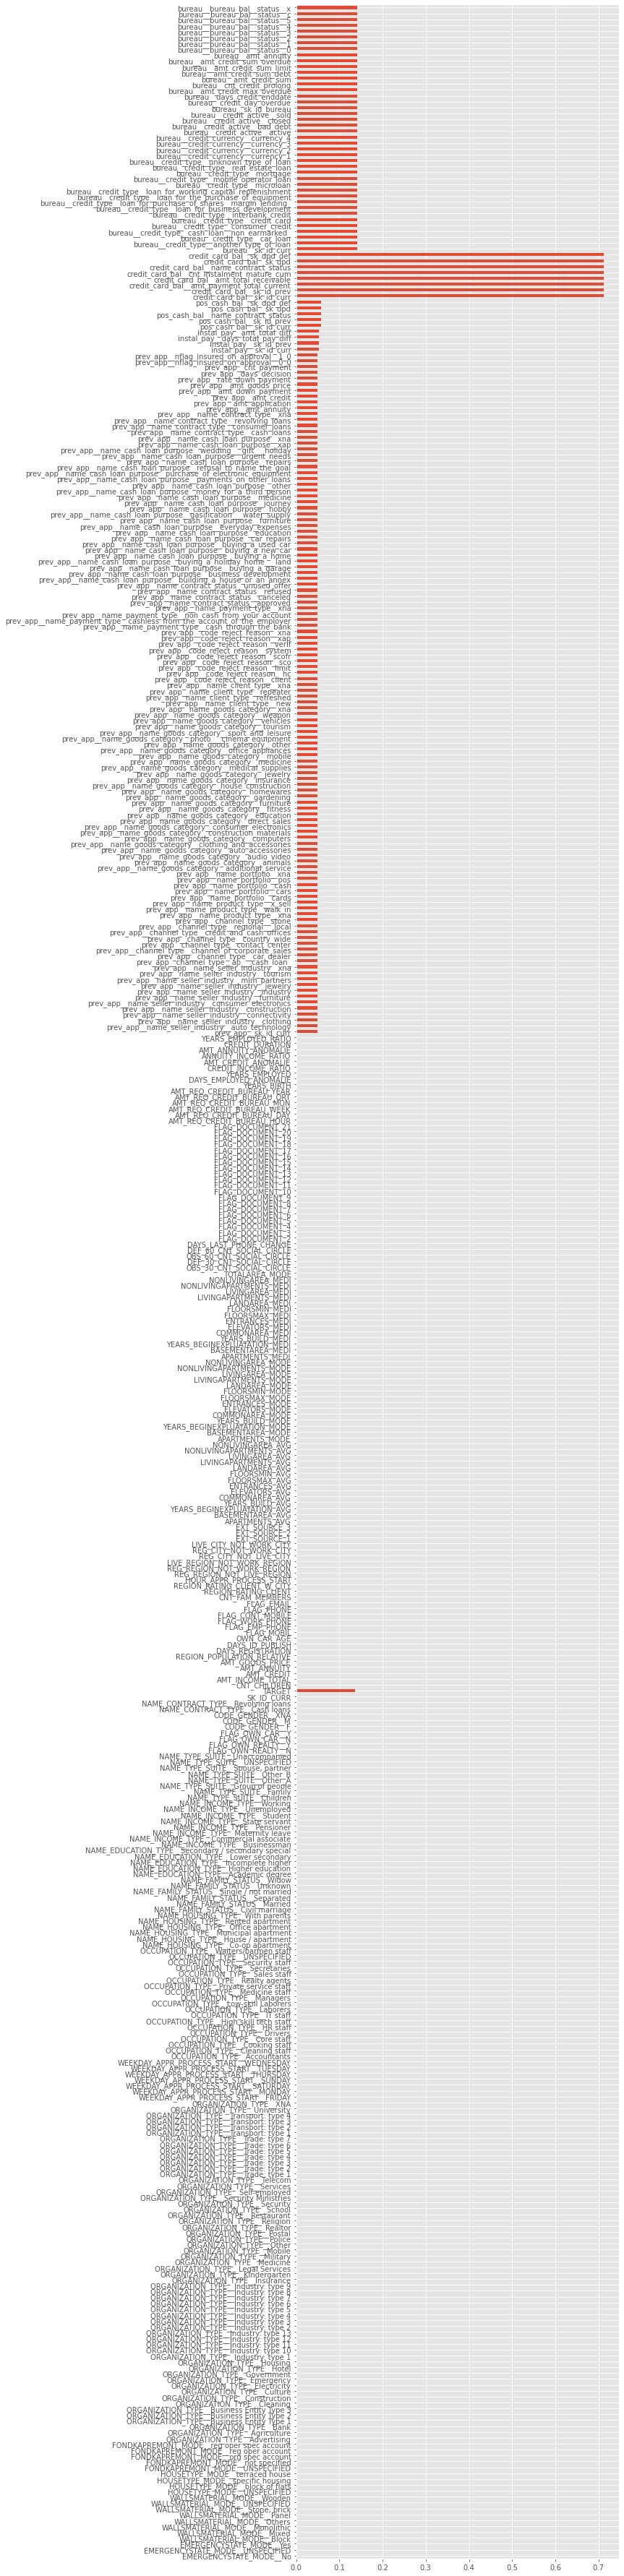

In [322]:
plt.figure(figsize=(8,65))
ax = df_custom_global.isna().sum().div(len(df_custom_global)).plot.barh()
plt.show()

In [323]:
# Je décide de dropper les colonnes avec un taux de Nan supérieur à 70%
df_custom_global.dropna(thresh=0.7* len(df_custom_global), axis=1, inplace=True)

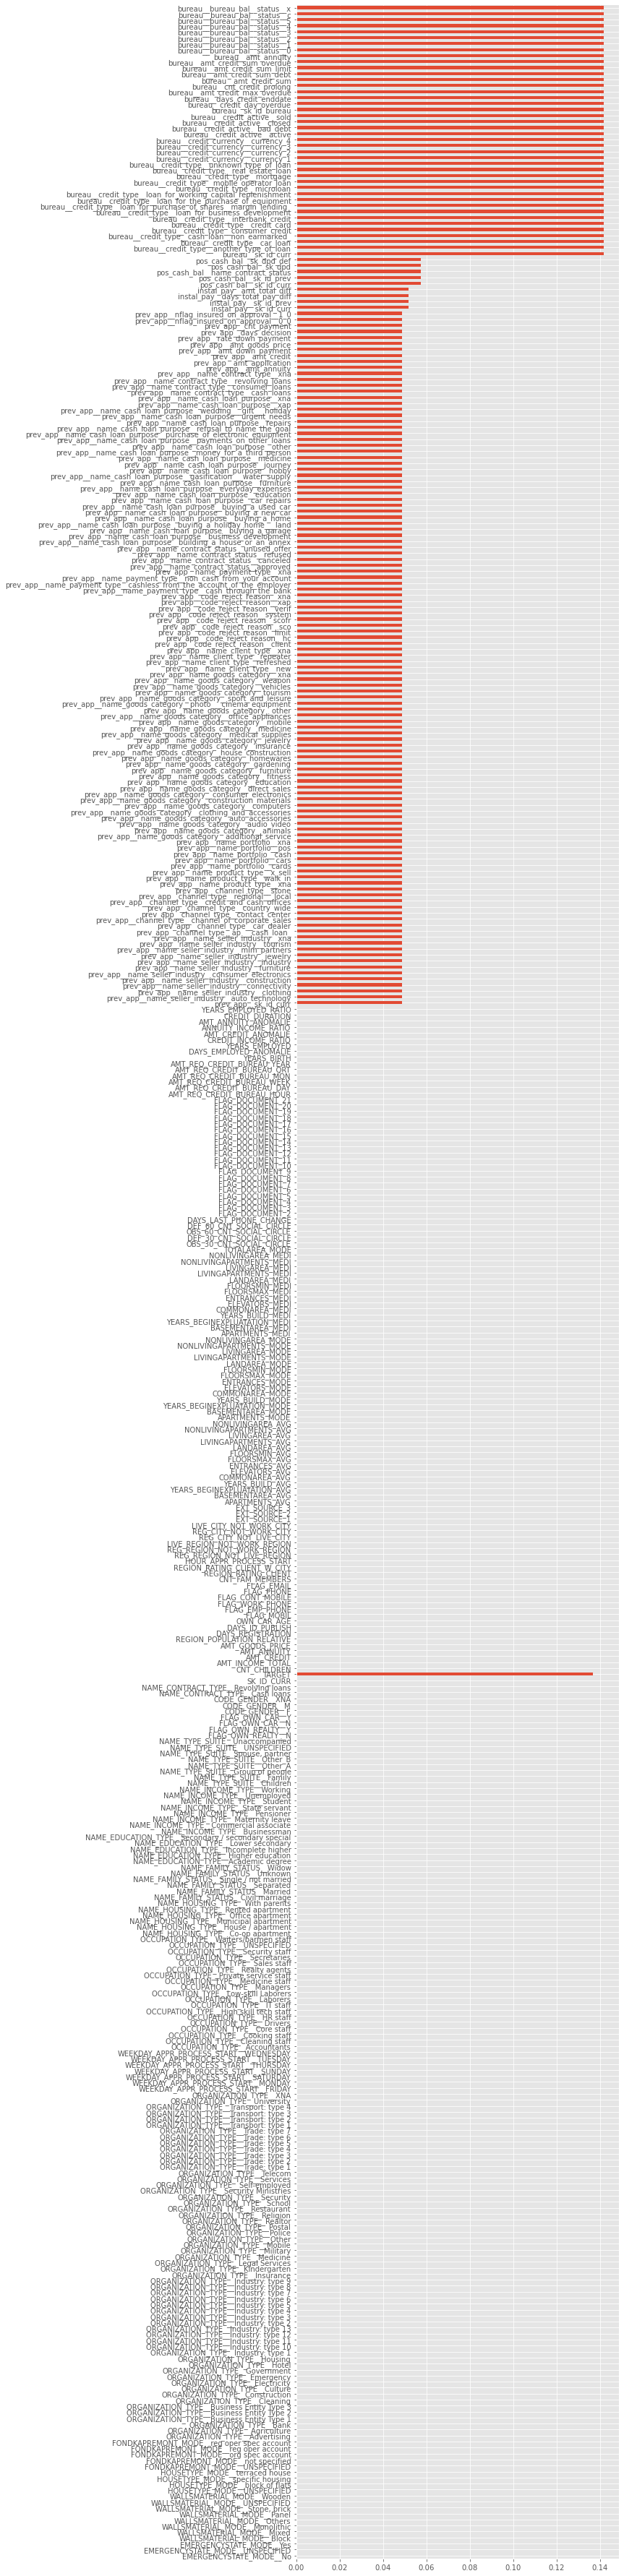

In [324]:
# contrôle
plt.figure(figsize=(8,65))
ax = df_custom_global.isna().sum().div(len(df_custom_global)).plot.barh()
plt.show()

In [325]:
##### IMPUTATIONS
# A part pour la colonne Target, je réimpute pour les valeurs manquantes
for col in df_custom_global.columns:
    # On évite la colonne TARGET (qui doit conserver ses Nan pour identifier le jeu de test fusionné)
    if col != 'TARGET':
        # si la distribution des valeurs est asymétrique on impute par le mode, sinon la médiane pour les Nan
        if df_custom_global[col].skew(skipna=True) > 0.5 or df_custom_global[col].skew(skipna=True) < -0.5:
            if len(df_custom_global[col].unique()) < 10: # moins de 10 -> le mode est plus approprié
                df_custom_global[col].replace({np.nan: df_custom_global[col].mode()[0]}, inplace=True)
            else:
                df_custom_global[col].replace({np.nan: df_custom_global[col].median()}, inplace=True)
        else:
            df_custom_global[col].replace({np.nan: df_custom_global[col].mean()}, inplace=True)

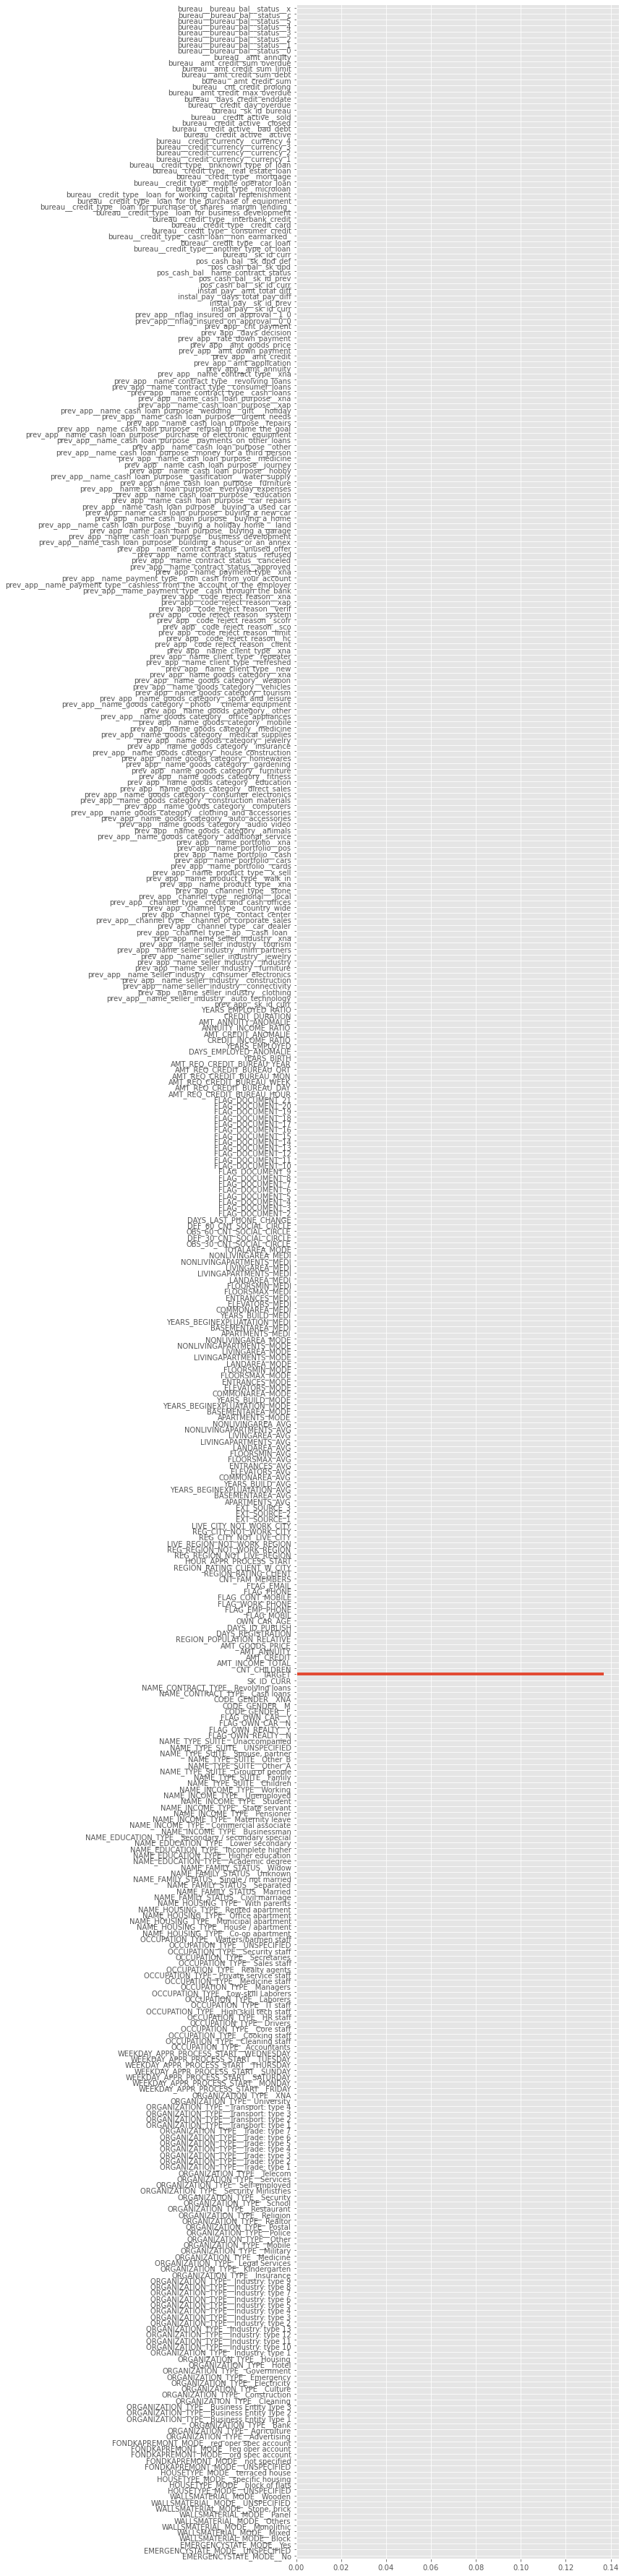

In [326]:
# contrôle
plt.figure(figsize=(8,65))
ax = df_custom_global.isna().sum().div(len(df_custom_global)).plot.barh()
plt.show()

In [327]:
%%script echo skipping
pickle.dump(df_custom_global, open(path + '/fichiers_pickle/df_custom_global.pkl', 'wb'))

Couldn't find program: 'echo'


In [330]:
df_custom_global = pickle.load(open(path + '/fichiers_pickle/df_custom_global.pkl', 'rb'))

In [331]:
df_custom_global_optim = df_custom_global.copy()

#### Observation des corrélations linéaires

In [332]:
df_custom_global_optim_avant_suppr_corr = df_custom_global_optim.copy()

In [333]:
%%time
num_col = [name for name in df_custom_global_optim.columns if df_custom_global_optim[name].dtype != 'object']
num_col_corr = df_custom_global_optim[num_col].corr()

Wall time: 2min 13s


In [334]:
# pour pouvoir revenir en arrière
num_col_to_drop = num_col_corr.copy()

In [335]:
num_col_corr.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 426 entries, EMERGENCYSTATE_MODE__No to bureau__bureau_bal__status__x
Data columns (total 426 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    EMERGENCYSTATE_MODE__No                                                 float64
 1    EMERGENCYSTATE_MODE__UNSPECIFIED                                        float64
 2    EMERGENCYSTATE_MODE__Yes                                                float64
 3    WALLSMATERIAL_MODE__Block                                               float64
 4    WALLSMATERIAL_MODE__Mixed                                               float64
 5    WALLSMATERIAL_MODE__Monolithic                                          float64
 6    WALLSMATERIAL_MODE__Others                                              float64
 7    WALLSMATERIAL_MODE__Panel                                              

In [336]:
num_col_corr[num_col_corr.loc[: , 'EMERGENCYSTATE_MODE__No'] > 0.5].index[1:]

Index(['WALLSMATERIAL_MODE__Panel', 'HOUSETYPE_MODE__block of flats',
       'FONDKAPREMONT_MODE__reg oper account'],
      dtype='object')

In [337]:
num_col_corr[num_col_corr.loc[: , 'EMERGENCYSTATE_MODE__No'] > 0.5]['EMERGENCYSTATE_MODE__No'].sort_values()[:-1]

WALLSMATERIAL_MODE__Panel               0.503601
FONDKAPREMONT_MODE__reg oper account    0.535639
HOUSETYPE_MODE__block of flats          0.914588
Name: EMERGENCYSTATE_MODE__No, dtype: float64

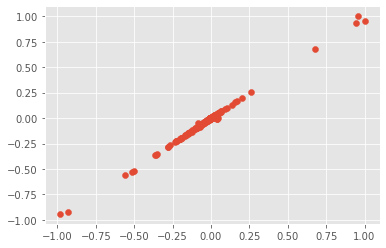

In [339]:
plt.scatter(num_col_corr['HOUSETYPE_MODE__UNSPECIFIED'], num_col_corr['WALLSMATERIAL_MODE__UNSPECIFIED'])
plt.show()

#### suppression des corrélations fortes

In [340]:
for col in num_col_to_drop.columns:
    ps_corr = num_col_to_drop[(num_col_to_drop.loc[: , col] > 0.95) & 
                    (num_col_to_drop.loc[: , col] < 1)][col].sort_values()[:-1]
    if len(ps_corr) != 0: # si le pandas serie n'est pas vide
        print("col :", col)
        for index in ps_corr.index:
            print("index : {} présente une forte corrélation de {}".format(
                index, ps_corr.loc[index]
            ))
            try:
                if index != 'SK_ID_CURR':
                    df_custom_global_optim.drop(index, axis=1, inplace=True)
                    print("Supression effectuée.")
                    print('\n')
            except:
                pass # En effet si la colonne était déjà corrélée avec une autre avant.

col : NAME_INCOME_TYPE__Pensioner
index : DAYS_EMPLOYED_ANOMALIE présente une forte corrélation de 0.999688171823371
Supression effectuée.


col : SK_ID_CURR
index : pos_cash_bal__sk_id_curr présente une forte corrélation de 0.9712916291791768
Supression effectuée.


index : instal_pay__sk_id_curr présente une forte corrélation de 0.9740974141811314
Supression effectuée.


col : APARTMENTS_AVG
index : APARTMENTS_MODE présente une forte corrélation de 0.9749501046805511
Supression effectuée.


col : BASEMENTAREA_AVG
index : BASEMENTAREA_MODE présente une forte corrélation de 0.9724853218338126
Supression effectuée.


col : YEARS_BEGINEXPLUATATION_AVG
index : YEARS_BEGINEXPLUATATION_MODE présente une forte corrélation de 0.9722161638395248
Supression effectuée.


col : YEARS_BUILD_AVG
index : YEARS_BUILD_MODE présente une forte corrélation de 0.9894314527431981
Supression effectuée.


col : COMMONAREA_AVG
index : COMMONAREA_MODE présente une forte corrélation de 0.9785307771939821
Supres

In [341]:
# On regarde l'index décorellé
display(df_custom_global_optim.shape)
print('SK_ID_CURR' in num_col_to_drop.index)

(356255, 390)

True


In [342]:
print(df_custom_global_optim_avant_suppr_corr.shape)
print(df_custom_global_optim.shape)

(356255, 426)
(356255, 390)


In [ ]:
# contrôle
#df_custom_global_optim['prev_app__name_goods_category__xna']

In [343]:
# contrôle de suppression
print(df_custom_global_optim.shape)
print(df_custom_global.shape)

(356255, 390)
(356255, 426)


### Corrélations linéaires: YEARS_BIRTH vs EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

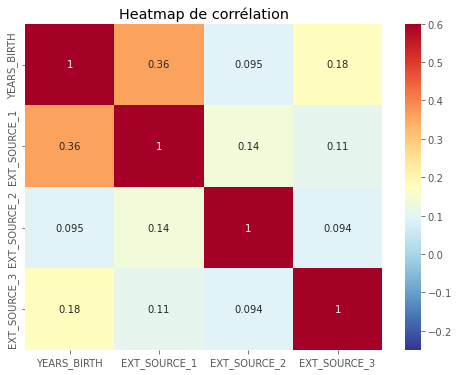

In [344]:
num_col_corr = df_custom_global_optim[[
    'YEARS_BIRTH',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]].corr()
plt.figure(figsize = (8, 6))
sns.heatmap(num_col_corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Heatmap de corrélation')
plt.show()

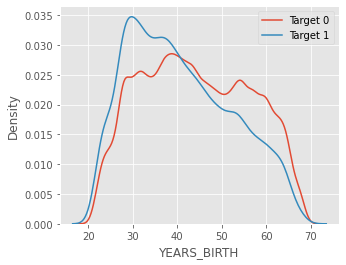

In [345]:
# Age en fonction de la capacité de paiement
plt.figure(figsize=(5,4))
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 0, 'YEARS_BIRTH'], label='Target 0')
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 1, 'YEARS_BIRTH'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Feature engenering utile ?

#### Visualisation des nouvelles variables par classe de TARGET
- YEARS_EMPLOYED_RATIO
- CREDIT_DURATION
- ANNUITY_INCOME_RATIO
- CREDIT_INCOME_RATIO

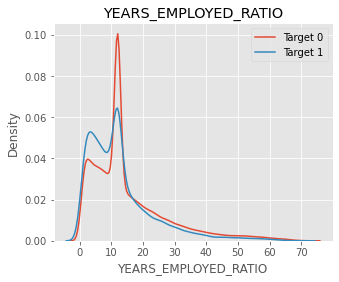

In [346]:
plt.figure(figsize=(5,4))
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 0, 'YEARS_EMPLOYED_RATIO'], label='Target 0')
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 1, 'YEARS_EMPLOYED_RATIO'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("YEARS_EMPLOYED_RATIO")
plt.show()

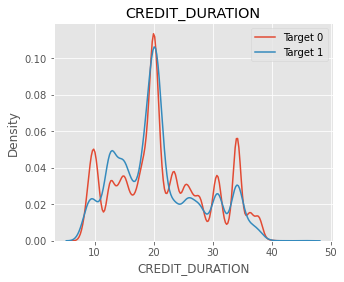

In [347]:
plt.figure(figsize=(5,4))
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 0, 'CREDIT_DURATION'], label='Target 0')
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 1, 'CREDIT_DURATION'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("CREDIT_DURATION")
plt.show()

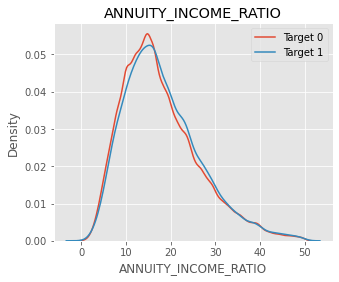

In [348]:
plt.figure(figsize=(5,4))
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 0, 'ANNUITY_INCOME_RATIO'], label='Target 0')
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 1, 'ANNUITY_INCOME_RATIO'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("ANNUITY_INCOME_RATIO")
plt.show()

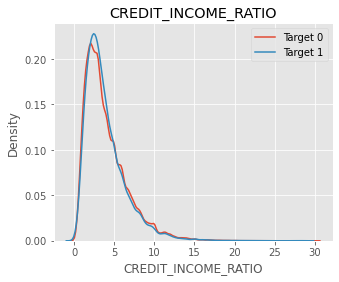

In [349]:
plt.figure(figsize=(5,4))
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 0, 'CREDIT_INCOME_RATIO'], label='Target 0')
sns.kdeplot(df_custom_global_optim.loc[df_custom_global_optim['TARGET'] == 1, 'CREDIT_INCOME_RATIO'], label='Target 1')
plt.legend(bbox_to_anchor=(1, 1))
plt.title("CREDIT_INCOME_RATIO")
plt.show()

### On reindex les colonnes alphabetiquement

In [350]:
df_custom_global_optim = df_custom_global_optim.reindex(sorted(df_custom_global_optim.columns), axis=1)

### Imputation de valeurs manquantes nécessaire ?

In [351]:
df_custom_global_optim.head()

AMT_ANNUITY  AMT_ANNUITY_ANOMALIE  AMT_CREDIT  AMT_CREDIT_ANOMALIE  \
0      24700.5                     0    406597.5                    0   
1      35698.5                     0   1293502.5                    0   
2       6750.0                     0    135000.0                    0   
3      29686.5                     0    312682.5                    0   
4      21865.5                     0    513000.0                    0   

   AMT_GOODS_PRICE  AMT_INCOME_TOTAL  AMT_REQ_CREDIT_BUREAU_DAY  \
0         351000.0          202500.0                        0.0   
1        1129500.0          270000.0                        0.0   
2         135000.0           67500.0                        0.0   
3         297000.0          135000.0                        0.0   
4         513000.0          121500.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  ...  \
0                        0.0  ...   
1                        0.0  ...   
2                        0.0  ...   
3                        0.0  ...   
4                        0.0  ...   

   prev_app__name_seller_industry__consumer_electronics  \
0                                                0.0      
1                                                1.0      
2                                                0.0      
3                                                1.0      
4                                                3.0      

   prev_app__name_seller_industry__furniture  \
0                                        0.0   
1                                        1.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   prev_app__name_seller_industry__industry  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   prev_app__name_seller_industry__jewelry  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   prev_app__name_seller_industry__mlm_partners  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   prev_app__name_seller_industry__tourism  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   prev_app__name_seller_industry__xna  \
0                                  0.0   
1                                  1.0   
2                                  0.0   
3                                  7.0   
4                                  2.0   

   prev_app__nflag_insured_on_approval__0_0  \
0                                       1.0   
1                                       1.0   
2                                       1.0   
3                                       4.0   
4                                       2.0   

   prev_app__nflag_insured_on_approval__1_0  prev_app__rate_down_payment  
0                                       0.0                          0.0  
1                                       2.0                          0.0  
2                           

In [352]:
# Pour le modèle, il faudra enlever "AMT_ANNUITY_ANOMALIE" et "AMT_CREDIT_ANOMALIE"
df_custom_global_optim.agg(['mean', 'median', 'min', 'max'])

AMT_ANNUITY  AMT_ANNUITY_ANOMALIE    AMT_CREDIT  \
mean     27425.323483              0.008303  5.877674e+05   
median   25078.500000              0.000000  5.002110e+05   
min       1615.500000              0.000000  4.500000e+04   
max     258025.500000              1.000000  4.050000e+06   

        AMT_CREDIT_ANOMALIE  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
mean               0.000067     5.279591e+05      1.701161e+05   
median             0.000000     4.500000e+05      1.530000e+05   
min                0.000000     4.050000e+04      2.565000e+04   
max                1.000000     4.050000e+06      1.170000e+08   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
mean                     0.005443                    0.005033   
median                   0.000000                    0.000000   
min                      0.000000                    0.000000   
max                      9.000000                    4.000000   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  ...  \
mean                     0.200761                   0.263755  ...   
median                   0.000000                   0.000000  ...   
min                      0.000000                   0.000000  ...   
max                     27.000000                 261.000000  ...   

        prev_app__name_seller_industry__consumer_electronics  \
mean                                             1.166757      
median                                           1.000000      
min                                              0.000000      
max                                             48.000000      

        prev_app__name_seller_industry__furniture  \
mean                                     0.162381   
median                                   0.000000   
min                                      0.000000   
max                                     20.000000   

        prev_app__name_seller_industry__industry  \
mean                                    0.053877   
median                                  0.000000   
min                                     0.000000   
max                                    10.000000   

        prev_app__name_seller_industry__jewelry  \
mean                                   0.007604   
median                                 0.000000   
min                                    0.000000   
max                                    9.000000   

        prev_app__name_seller_industry__mlm_partners  \
mean                                         0.00341   
median                                       0.00000   
min                                          0.00000   
max                                         12.00000   

        prev_app__name_seller_industry__tourism  \
mean                                    0.00144   
median                                  0.00000   
min                                     0.00000   
max                                    10.00000   

        prev_app__name_seller_industry__xna  \
mean                               2.450823   
median                             1.000000   
min                                0.000000   
max                               68.000000   

        prev_app__nflag_insured_on_approval__0_0  \
mean                                    1.965791   
median                                  2.000000   
min                                     0.000000   
max                                    21.000000   

        prev_app__nflag_insured_on_approval__1_0  prev_app__rate_down_payment  
mean                                    0.979692                    -0.005167  
median                                  1.000000                     0.000000  
min                                     0.000000                    -0.288179  
max                                    23.000000                     0.259025  

[4 rows x 390 columns]

In [353]:
with pd.option_context('display.max_rows', None):
    print(df_custom_global_optim.isna().sum())

AMT_ANNUITY                                                                   0
AMT_ANNUITY_ANOMALIE                                                          0
AMT_CREDIT                                                                    0
AMT_CREDIT_ANOMALIE                                                           0
AMT_GOODS_PRICE                                                               0
AMT_INCOME_TOTAL                                                              0
AMT_REQ_CREDIT_BUREAU_DAY                                                     0
AMT_REQ_CREDIT_BUREAU_HOUR                                                    0
AMT_REQ_CREDIT_BUREAU_MON                                                     0
AMT_REQ_CREDIT_BUREAU_QRT                                                     0
AMT_REQ_CREDIT_BUREAU_WEEK                                                    0
AMT_REQ_CREDIT_BUREAU_YEAR                                                    0
ANNUITY_INCOME_RATIO                    

In [354]:
# sélection des colonnes "sk_id"
col_sk_id = [col for col in df_custom_global_optim.columns if col.find("sk_id") != -1]
print(col_sk_id)

['bureau__sk_id_bureau', 'bureau__sk_id_curr', 'instal_pay__sk_id_prev']


In [355]:
df_custom_global_optim.drop(col_sk_id, axis=1, inplace=True)

In [ ]:
%%script echo skipping
pickle.dump(df_custom_global_optim, open(path + '/fichiers_pickle/df_custom_global_optim.pkl', 'wb'))

In [356]:
df_custom_global_optim = pickle.load(open(path + '/fichiers_pickle/df_custom_global_optim.pkl', 'rb'))

In [357]:
print(df_custom_global_optim.isna().sum().sum()) # TARGEt uniquement donc tout est OK
print(df_custom_global_optim.shape)

48744
(356255, 387)


##### Train & Test: df_global_custom

In [358]:
df_custom_global_train = df_custom_global_optim.loc[df_custom_global_optim['TARGET'].notnull(), :]
print(df_custom_global_train.shape)

(307511, 387)


In [359]:
df_custom_global_test = df_custom_global_optim.loc[df_custom_global_optim['TARGET'].isnull(), :]
print(df_custom_global_test.shape)

(48744, 387)


In [360]:
# contrôle
len(df_custom_global) == len(df_custom_global_train) + len(df_custom_global_test)

True

In [361]:
df_custom_global_train['TARGET'].tail(5)

307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, dtype: float64

In [362]:
# On drop les colonnes qui ne seront plus utilisées pour l'entrainement du modèle
df_custom_global_train = df_custom_global_train[df_custom_global_train.columns.difference(
    ['AMT_ANNUITY_ANOMALIE', # laissée initialement pour l'inspection (remplacé en np.nan -> et remplacé par l'imputation)
    'AMT_CREDIT_ANOMALIE']
)]
print(df_custom_global_train.shape)

(307511, 385)


In [363]:
scaler = MinMaxScaler()
arr_custom_global_train_std = scaler.fit_transform(df_custom_global_train) # On scale TARGET également (pas de changement avec le scaler)

In [364]:
df_custom_global_train_std = pd.DataFrame(
    data=arr_custom_global_train_std,
    index=df_custom_global_train.index,
    columns=df_custom_global_train.columns
)
print(df_custom_global_train_std['TARGET'].tail())

307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, dtype: float64


#### PCA exploitable ?

In [365]:
pca = PCA(n_components=0.90) # soit le pourcentage, soit le nombre
pca_features = pca.fit_transform(df_custom_global_train_std)
print(pca_features.shape, '\n')
print(pca.explained_variance_ratio_.cumsum()[-1])

(307511, 57) 

0.9018845119455964


In [366]:
# les 5 premières composantes n'expliquent pas beaucoup de variance (=quasiment pas de corrélations sur notre jeu)
print(pca.explained_variance_ratio_[:5])

[0.14128257 0.08384168 0.05320681 0.04068515 0.03939201]


In [367]:
pca_columns = ["PCA_{}".format(col) for col in range(0, pca_features.shape[1])]

df_custom_global_train_pca = pd.DataFrame(
    data = pca_features,
    index = df_custom_global_train.index,
    columns = pca_columns
)

### Sélection des variables qui contribuent le plus au modèle
Méthode mise en oeuvre ici: RFE avec RandomForest et subsample balanced.

In [368]:
X_train, X_test, y_train, y_test = train_test_split(
    df_custom_global_train_std.drop('TARGET', axis=1), # X (df_custom_global_train, df_custom_global_train_std)
    df_custom_global_train_std['TARGET'], # y
    test_size=0.2,
    stratify=df_custom_global_train_std['TARGET'],
    random_state=24
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(246008, 384) (246008,)
(61503, 384) (61503,)


In [369]:
rfe = RFE(
    estimator=RandomForestClassifier(class_weight='balanced_subsample'), 
    n_features_to_select=100,
    step=50,
    verbose=1
)

In [370]:
%%time
%%script echo skipping
rfe.fit(X_train, y_train)

Fitting estimator with 384 features.
Fitting estimator with 334 features.
Fitting estimator with 284 features.
Fitting estimator with 234 features.
Fitting estimator with 184 features.
Fitting estimator with 134 features.
Wall time: 14min 46s


RFE(estimator=RandomForestClassifier(class_weight='balanced_subsample'),
    n_features_to_select=100, step=50, verbose=1)

In [371]:
print(f1_score(y_test, rfe.predict(X_test)))
print(accuracy_score(y_test, rfe.predict(X_test)))

0.009554140127388536
0.9190933775588183


In [372]:
# contrôle
print(len(rfe.support_))

384


In [373]:
%%script echo skipping
pickle.dump(
    df_custom_global_train.drop('TARGET', axis=1).columns[rfe.support_],
    open(path + '/fichiers_pickle/rfe_remove_cols.pkl', 'wb')
)

Couldn't find program: 'echo'


In [374]:
rfe_removed_cols = pickle.load(open(path + '/fichiers_pickle/rfe_remove_cols.pkl', 'rb'))

In [375]:
# on affiche le nom des colonnes qui ont été enlevées
print(rfe_removed_cols[:15])

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'ANNUITY_INCOME_RATIO', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
       'CODE_GENDER__F', 'CODE_GENDER__M', 'COMMONAREA_MEDI'],
      dtype='object')


In [376]:
rfe_removed_cols = rfe_removed_cols.tolist()
print(len(rfe_removed_cols))
df_custom_global_train_rfe = df_custom_global_train_std[df_custom_global_train_std.columns.difference(rfe_removed_cols)]

100


In [377]:
df_custom_global_train_rfe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 285 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    AMT_REQ_CREDIT_BUREAU_DAY                                               float64
 1    AMT_REQ_CREDIT_BUREAU_HOUR                                              float64
 2    AMT_REQ_CREDIT_BUREAU_WEEK                                              float64
 3    CODE_GENDER__XNA                                                        float64
 4    EMERGENCYSTATE_MODE__UNSPECIFIED                                        float64
 5    EMERGENCYSTATE_MODE__Yes                                                float64
 6    FLAG_CONT_MOBILE                                                        float64
 7    FLAG_DOCUMENT_10                                                        float64
 8    FLAG_DOCUMENT_11      

### Fonction Joblib pour sauvegarder et recharger un modèle

In [393]:
def save_load_gs_model(action, model_name, gs_model=None):
    """Fonction qui permet de sauvegarder ou charger une copie d'un modèle issu d'une GridSearchCV (ou autre).
    
    Args:
        action (string): "load" ou "save" pour charger ou sauvegarder les modèles entraînés avec les hyperparamètres.
        gs_model (object): instance du modèle.
        model_name (string) : nom de du modèle. 
        
    Returns:
        Le modèle entraîné avec les meilleurs hyperparamètres trouvés.
    """
    # model_name = f'{gs_model=}'.split('=')[0] # pas de référence, out of scope -> dommage ne fonctionne pas
    model_name = str(model_name)
    
    if action == 'save':
        try:
            joblib.dump(gs_model, path + '/fichiers_pickle/' + model_name + '.pkl')
            return
            
        except Exception as e:
            print("L'action demandée n'a pas abouti. Vérifiez le chemin et/ou le fichier utilisé.")
            return
        
    if action == 'load':
        try:
            joblib_gs_model = joblib.load(path + '/fichiers_pickle/' + model_name + '.pkl')
            return joblib_gs_model
            
        except Exception as e:
            print("L'action demandée n'a pas abouti. Vérifiez le chemin et/ou le fichier utilisé.")
            return

### Test RFC sur df_app_train_test pour regarder si l'apport des merges est important ou non

In [379]:
with pd.option_context('display.max_rows', None):
    print(df_app_train_test.drop('TARGET', axis=1).isna().sum())

EMERGENCYSTATE_MODE__No                               0
EMERGENCYSTATE_MODE__UNSPECIFIED                      0
EMERGENCYSTATE_MODE__Yes                              0
WALLSMATERIAL_MODE__Block                             0
WALLSMATERIAL_MODE__Mixed                             0
WALLSMATERIAL_MODE__Monolithic                        0
WALLSMATERIAL_MODE__Others                            0
WALLSMATERIAL_MODE__Panel                             0
WALLSMATERIAL_MODE__Stone, brick                      0
WALLSMATERIAL_MODE__UNSPECIFIED                       0
WALLSMATERIAL_MODE__Wooden                            0
HOUSETYPE_MODE__UNSPECIFIED                           0
HOUSETYPE_MODE__block of flats                        0
HOUSETYPE_MODE__specific housing                      0
HOUSETYPE_MODE__terraced house                        0
FONDKAPREMONT_MODE__UNSPECIFIED                       0
FONDKAPREMONT_MODE__not specified                     0
FONDKAPREMONT_MODE__org spec account            

In [380]:
#df_app_train_test, on exclue la partie "test" -> qui n'a pas de TARGET
df_app_train_for_model = df_app_train_test[df_app_train_test['TARGET'].notnull()]

##### Normalisation des données

In [381]:
scaler = MinMaxScaler()
df_app_train_for_model_std = scaler.fit_transform(df_app_train_for_model)

In [382]:
df_app_train_for_model_std.shape

(307511, 259)

In [383]:
df_app_train_for_model_std = pd.DataFrame(
    df_app_train_for_model_std,
    index=df_app_train_for_model.index,
    columns=df_app_train_for_model.columns.tolist() # on prend pas TARGET
)
display(df_app_train_for_model_std.head())

EMERGENCYSTATE_MODE__No  EMERGENCYSTATE_MODE__UNSPECIFIED  \
0                      1.0                               0.0   
1                      1.0                               0.0   
2                      0.0                               1.0   
3                      0.0                               1.0   
4                      0.0                               1.0   

   EMERGENCYSTATE_MODE__Yes  WALLSMATERIAL_MODE__Block  \
0                       0.0                        0.0   
1                       0.0                        1.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        0.0   

   WALLSMATERIAL_MODE__Mixed  WALLSMATERIAL_MODE__Monolithic  \
0                        0.0                             0.0   
1                        0.0                             0.0   
2                        0.0                             0.0   
3                        0.0                             0.0   
4                        0.0                             0.0   

   WALLSMATERIAL_MODE__Others  WALLSMATERIAL_MODE__Panel  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   WALLSMATERIAL_MODE__Stone, brick  WALLSMATERIAL_MODE__UNSPECIFIED  ...  \
0                               1.0                              0.0  ...   
1                               0.0                              0.0  ...   
2                               0.0                              1.0  ...   
3                               0.0                              1.0  ...   
4                               0.0                              1.0  ...   

   AMT_REQ_CREDIT_BUREAU_YEAR  YEARS_BIRTH  DAYS_EMPLOYED_ANOMALIE  \
0                        0.04     0.111161                     0.0   
1                        0.00     0.522886                     0.0   
2                        0.00     0.651466                     0.0   
3                        0.04     0.649154                     0.0   
4                        0.00     0.701409                     0.0   

   YEARS_EMPLOYED  CREDIT_INCOME_RATIO  AMT_CREDIT_ANOMALIE  \
0        0.035563             0.066780                  0.0   
1        0.066324             0.159557                  0.0   
2        0.012561             0.066517                  0.0   
3        0.169663             0.077058                  0.0   
4        0.169607             0.140603                  0.0   

   ANNUITY_INCOME_RATIO  AMT_ANNUITY_ANOMALIE  CREDIT_DURATION  \
0              0.243617                   0.0         0.226047   
1              0.264104                   0.0         0.756604   
2              0.199642                   0.0         0.321005   
3              0.439549                   0.0         0.066977   
4              0.359639                   0.0         0.413888   

   YEARS_EMPLOYED_RATIO  
0              0.092382  
1              0.097229  
2              0.016209  
3              0.219406  
4              0.209133  

[5 rows x 259 columns]

In [384]:
# contrôle
print(df_app_train_for_model_std['TARGET'].tail())

307506    0.0
307507    0.0
307508    0.0
307509    1.0
307510    0.0
Name: TARGET, dtype: float64


In [ ]:
# Besoin d'ajouter la colonne 'TARGET' (pour ce splitting uniquement)
#df_app_train_for_model_std['TARGET'] = df_app_train_for_model['TARGET']

In [385]:
# contrôle
print(df_app_train_for_model_std.shape)
print(df_app_train_for_model.shape)

(307511, 259)
(307511, 259)


##### Splitting des données

In [386]:
# jeu réduit -> sampling
data_1, sample_1 = train_test_split(
    df_app_train_for_model_std, # X jeu complet (df_app_train_for_model)
    test_size=0.1, # 0.1, sampling de 30 % du jeu complet
    stratify=df_app_train_for_model_std['TARGET'],
    random_state=42
)

print("data_1.shape", data_1.shape)
print("sample_1.shape", sample_1.shape)

data_1.shape (276759, 259)
sample_1.shape (30752, 259)


In [387]:
sample_1['TARGET'].sum()

2483.0

In [388]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    sample_1.drop('TARGET', axis=1), # X 
    sample_1['TARGET'], # y
    test_size=0.2,
    stratify= sample_1['TARGET'],
    random_state=42
)

print(X_train_1.shape, y_train_1.shape)
print(X_test_1.shape, y_test_1.shape)

(24601, 258) (24601,)
(6151, 258) (6151,)


In [389]:
rfc_1_params = {
    'n_estimators' : [250, 350, 400], #[150, 200, 250, 300], 
    'max_depth': [5, 10, 20], #np.arange(5, 20, 2),
    'criterion' : ['gini', 'entropy'], #['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2'], #['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', 'balanced_subsample'] #['balanced', 'balanced_subsample', {0:1, 1:4}],

}
#gs_rfc_rfe : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}

rfc_1_k_folds = 5
rfc_1_scoring = 'f1' # accuracy ne nous renseigne pas sur le niveau (taux) de précision/recall (f1 = 2 * (p*r)/(p+r))

gs_rfc_1 = GridSearchCV(
    RandomForestClassifier(random_state=24),
    param_grid=rfc_1_params,
    cv=rfc_1_k_folds,
    scoring=rfc_1_scoring,
    n_jobs=2, #-1
    verbose=1
)

In [390]:
%%time
%%script echo skipping
gs_rfc_1.fit(X_train_1, y_train_1)

Couldn't find program: 'echo'
Wall time: 3.99 ms


In [ ]:
# y_pred_rfc_1 = gs_rfc_1.predict(X_test_1)

In [391]:
%%script echo skipping
save_load_gs_model('save', 'gs_rfc_1', gs_rfc_1)

Couldn't find program: 'echo'


In [395]:
joblib_gs_rfc_1 = save_load_gs_model('load', 'gs_rfc_1')
print("gs_rfc_1 :", joblib_gs_rfc_1.best_params_)

gs_rfc_1 : {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [396]:
gs_rfc_1 = RandomForestClassifier(**joblib_gs_rfc_1.best_params_)
gs_rfc_1.fit(X_train_1, y_train_1)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=200)

In [397]:
print("F1 sur le jeu de test : {}".format(f1_score(y_test_1, gs_rfc_1.predict(X_test_1))))
print("Accuracy sur le jeu de test : {}".format(gs_rfc_1.score(X_test_1, y_test_1)))

F1 sur le jeu de test : 0.2676864244741874
Accuracy sur le jeu de test : 0.813201105511299


In [398]:
cm_rfc_1 = confusion_matrix(y_test_1, gs_rfc_1.predict(X_test_1))
print(cm_rfc_1)

[[4792  862]
 [ 287  210]]


In [399]:
print(classification_report(y_test_1, gs_rfc_1.predict(X_test_1)))

              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      5654
         1.0       0.20      0.42      0.27       497

    accuracy                           0.81      6151
   macro avg       0.57      0.64      0.58      6151
weighted avg       0.88      0.81      0.84      6151



##### Utilisation de "class weight"

In [400]:
dict_joblib_gs_rfc_1 = joblib_gs_rfc_1.best_params_

In [401]:
dict_joblib_gs_rfc_1['class_weight'] = {0:1, 1:16}
print(dict_joblib_gs_rfc_1)

{'class_weight': {0: 1, 1: 16}, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [402]:
gs_rfc_2 = RandomForestClassifier(**dict_joblib_gs_rfc_1)
gs_rfc_2.fit(X_train_1, y_train_1)

RandomForestClassifier(class_weight={0: 1, 1: 16}, max_depth=10,
                       n_estimators=200)

In [403]:
print("F1 sur le jeu de test : {}".format(f1_score(y_test_1, gs_rfc_2.predict(X_test_1))))
print("Accuracy sur le jeu de test : {}".format(gs_rfc_2.score(X_test_1, y_test_1)))

F1 sur le jeu de test : 0.23600483286347163
Accuracy sur le jeu de test : 0.6915948626239636


In [404]:
cm_rfc_2 = confusion_matrix(y_test_1, gs_rfc_2.predict(X_test_1))
print(cm_rfc_2)

[[3961 1693]
 [ 204  293]]


In [405]:
print(classification_report(y_test_1, gs_rfc_2.predict(X_test_1)))

              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81      5654
         1.0       0.15      0.59      0.24       497

    accuracy                           0.69      6151
   macro avg       0.55      0.65      0.52      6151
weighted avg       0.89      0.69      0.76      6151



On peut donc augmenter le recall au détriment de la précision en utilisant "class weight"<br />
Cependant cela augmentent significativement le nombre de Fp.<br />
Il faut donc trouver une autre méthode pour "minimiser" l'augmentation des Fp en gardant un taux de Fn le plus faible possible -> SMOTE.

##### utilisation de la méthode de resampling SMOTE conjointement avec class weight
https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html<br />
SMOTE: Synthetic Minority Oversampling Technique<br />
SMOTE utilise des caractéristiques des plus proches voisins en défaut de paiement pour créer des nouveaux "individus".<br />
Cette technique est très intéressante car elle évite de dupliquer des individus en défaut de paiement en créant de nouveaux profils.<br />
Bénol: Cela suppose que les individus en défaut de paiement possèdent des profils "assez proches",<br />
sinon SMOTE construit les nouveaux profils à partir d'individus en règle (-> plus proche voisins)<br />
-> Ce qui peut introduire du "bruit" supplémentaire dans nos données initiales.<br />
Rappel: Les techniques de resampling s'utilisent uniquement sur le jeu d'entrainement !

In [406]:
smote = SMOTE(
    random_state=42,
    k_neighbors=5, # défaut 5
    n_jobs=-1
)
    
X_train_1_resampled, y_train_1_resampled = smote.fit_resample(X_train_1, y_train_1)

In [407]:
dict_joblib_gs_rfc_1 = joblib_gs_rfc_1.best_params_
dict_joblib_gs_rfc_1['class_weight'] = None # {0:1, 1:3} # None # {0:1, 1:1} # 'balanced_subsample'
print(dict_joblib_gs_rfc_1)

{'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 200}


In [408]:
# compute sample weights on the TARGET
arr_sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_1)

In [409]:
%%time
gs_rfc_3 = RandomForestClassifier(**dict_joblib_gs_rfc_1)
# gs_rfc_3.fit(X_train_1_resampled, y_train_1_resampled) # SMOTE ne donne pas de bons résultats
# gs_rfc_3.fit(X_train_1, y_train_1)
gs_rfc_3.fit(X_train_1, y_train_1, sample_weight=arr_sample_weights)

Wall time: 7.8 s


RandomForestClassifier(max_depth=10, n_estimators=200)

In [410]:
print("F1 sur le jeu de test : {}".format(f1_score(y_test_1, gs_rfc_3.predict(X_test_1))))
print("Accuracy sur le jeu de test : {}".format(gs_rfc_3.score(X_test_1, y_test_1)))

F1 sur le jeu de test : 0.27857589006870703
Accuracy sur le jeu de test : 0.8122256543651439


In [411]:
cm_rfc_3 = confusion_matrix(y_test_1, gs_rfc_3.predict(X_test_1))
print(cm_rfc_3)

[[4773  881]
 [ 274  223]]


In [412]:
print(classification_report(y_test_1, gs_rfc_3.predict(X_test_1)))

              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89      5654
         1.0       0.20      0.45      0.28       497

    accuracy                           0.81      6151
   macro avg       0.57      0.65      0.59      6151
weighted avg       0.89      0.81      0.84      6151



##### ROC curve and AUC

In [413]:
y_pred_1_prob = gs_rfc_3.predict_proba(X_test_1)[:, 1] # On veut la classe possitive (=1 -> client en défaut)

In [414]:
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_1_prob)

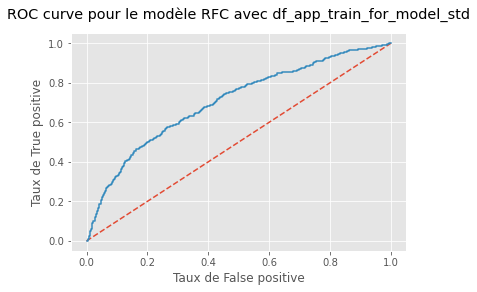

In [415]:
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='RFC (SMOTE and Class weigth)')
plt.xlabel("Taux de False positive")
plt.ylabel("Taux de True positive")
plt.title("ROC curve pour le modèle RFC avec df_app_train_for_model_std", pad=15)
plt.show()

In [416]:
# Pour ensuite comparer ce modèle avec d'autre classifier, on va utiliser l'aire sous la courbe ROC (AUC)
print("AUC pour le RFC (sans SMOTE & sample_weight) sur df_app_train_for_model_std: {:.2f}".format(roc_auc_score(y_test_1, y_pred_1_prob)))

AUC pour le RFC (sans SMOTE & sample_weight) sur df_app_train_for_model_std: 0.70


#### Naive Classifiers 
- pour la F-Mesure -> Recall=1 et Precision=0.01 (prédit seulement la classe minortaire)
- pour l'aire (AUC) sous la courbe ROC -> AUC ROC=0.5 pour une prédiction constante stratifiée (prédit une valeur constante)

#### Sampling technique pour accélérer l'évaluation des algorithmes d'intérêt
- Stratified Sampling

In [418]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42) 

#### RFC sur jeu complet (df_custom_global_train_rfe) avec SMOTE et class_weight
Two commonly used values for β are 2, which weighs recall higher than precision, and 0.5, which weighs recall lower than precision.<br />
Deux manières courantes de pondérer le Recall et la Précision (F0.5 et F2 mesures)

In [419]:
df_custom_global_train_rfe.shape
#df_custom_global_train_rfe['TARGET'].head()

(307511, 285)

##### Normalisation des données

In [420]:
scaler = MinMaxScaler()
df_custom_global_train_rfe_std = scaler.fit_transform(df_custom_global_train_rfe)

In [421]:
df_custom_global_train_rfe_std.shape

(307511, 285)

In [422]:
df_custom_global_train_rfe_std = pd.DataFrame(
    data=df_custom_global_train_rfe_std,
    index=df_custom_global_train_rfe.index,
    columns=df_custom_global_train_rfe.columns
)
display(df_custom_global_train_rfe_std.head())

AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.0                         0.0   
1                        0.0                         0.0   
2                        0.0                         0.0   
3                        0.0                         0.0   
4                        0.0                         0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  CODE_GENDER__XNA  \
0                         0.0               0.0   
1                         0.0               0.0   
2                         0.0               0.0   
3                         0.0               0.0   
4                         0.0               0.0   

   EMERGENCYSTATE_MODE__UNSPECIFIED  EMERGENCYSTATE_MODE__Yes  \
0                               0.0                       0.0   
1                               0.0                       0.0   
2                               1.0                       0.0   
3                               1.0                       0.0   
4                               1.0                       0.0   

   FLAG_CONT_MOBILE  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  \
0               1.0               0.0               0.0               0.0   
1               1.0               0.0               0.0               0.0   
2               1.0               0.0               0.0               0.0   
3               1.0               0.0               0.0               0.0   
4               1.0               0.0               0.0               0.0   

   ...  prev_app__name_seller_industry__consumer_electronics  \
0  ...                                           0.000000      
1  ...                                           0.020833      
2  ...                                           0.000000      
3  ...                                           0.020833      
4  ...                                           0.062500      

   prev_app__name_seller_industry__furniture  \
0                                       0.00   
1                                       0.05   
2                                       0.00   
3                                       0.00   
4                                       0.00   

   prev_app__name_seller_industry__industry  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   prev_app__name_seller_industry__jewelry  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   prev_app__name_seller_industry__mlm_partners  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   

   prev_app__name_seller_industry__tourism  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   prev_app__name_seller_industry__xna  \
0                             0.000000   
1                             0.014706   
2                             0.000000   
3                             0.102941   
4                             0.029412   

   prev_app__nflag_insured_on_approval__0_0  \
0                                  0.047619   
1                                  0.047619   
2                                  0.047619   
3                                  0.190476   
4                                  0.095238   

   prev_app__nflag_insured_on_approval__1_0  prev_app__rate_down_payment  
0                                  0.000000         

In [423]:
# contrôles
print(df_custom_global_train_rfe_std.shape)
print(df_custom_global_train_rfe.shape)

(307511, 285)
(307511, 285)


##### Splitting des données

In [424]:
# Séparation jeu complet / échantillon (sampling pour entraînement)
data_rfe_std, sample_rfe_std = train_test_split(
    df_custom_global_train_rfe_std, # X jeu complet
    test_size=0.1, # 0.1, sampling de 30 % du jeu complet
    stratify=df_custom_global_train_rfe_std['TARGET'],
    random_state=42
)

print("data_rfe_std.shape", data_rfe_std.shape)
print("sample_rfe_std.shape", sample_rfe_std.shape)

data_rfe_std.shape (276759, 285)
sample_rfe_std.shape (30752, 285)


In [425]:
# Séparation jeu complet / échantillon (sampling pour entraînement)
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(
    sample_rfe_std.drop('TARGET', axis=1), # X 
    sample_rfe_std['TARGET'], # y
    test_size=0.2,
    stratify= sample_rfe_std['TARGET'],
    random_state=42
)

print(X_train_rfe.shape, y_train_rfe.shape)
print(X_test_rfe.shape, y_test_rfe.shape)

(24601, 284) (24601,)
(6151, 284) (6151,)


In [426]:
display(X_train_rfe.head())
display(y_train_rfe.head())
display(X_test_rfe.head())
display(y_test_rfe.head())

AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
551                           0.0                         0.0   
82567                         0.0                         0.0   
36647                         0.0                         0.0   
284462                        0.0                         0.0   
69909                         0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  CODE_GENDER__XNA  \
551                          0.125               0.0   
82567                        0.000               0.0   
36647                        0.125               0.0   
284462                       0.000               0.0   
69909                        0.000               0.0   

        EMERGENCYSTATE_MODE__UNSPECIFIED  EMERGENCYSTATE_MODE__Yes  \
551                                  0.0                       0.0   
82567                                0.0                       1.0   
36647                                1.0                       0.0   
284462                               1.0                       0.0   
69909                                0.0                       0.0   

        FLAG_CONT_MOBILE  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
551                  1.0               0.0               0.0   
82567                1.0               0.0               0.0   
36647                1.0               0.0               0.0   
284462               1.0               0.0               0.0   
69909                1.0               0.0               0.0   

        FLAG_DOCUMENT_12  ...  \
551                  0.0  ...   
82567                0.0  ...   
36647                0.0  ...   
284462               0.0  ...   
69909                0.0  ...   

        prev_app__name_seller_industry__consumer_electronics  \
551                                              0.000000      
82567                                            0.000000      
36647                                            0.020833      
284462                                           0.020833      
69909                                            0.000000      

        prev_app__name_seller_industry__furniture  \
551                                          0.00   
82567                                        0.05   
36647                                        0.05   
284462                                       0.00   
69909                                        0.00   

        prev_app__name_seller_industry__industry  \
551                                          0.0   
82567                                        0.0   
36647                                        0.1   
284462                                       0.0   
69909                                        0.0   

        prev_app__name_seller_industry__jewelry  \
551                                         0.0   
82567                                       0.0   
36647                                       0.0   
284462                                      0.0   
69909                                       0.0   

        prev_app__name_seller_industry__mlm_partners  \
551                                              0.0   
82567                                            0.0   
36647                                            0.0   
284462                                           0.0   
69909                                            0.0   

        prev_app__name_seller_industry__tourism  \
551                                         0.0   
82567                                       0.0   
36647                                       0.0   
284462                                      0.0   
69909                                       0.0   

        prev_app__name_seller_industry__xna  \
551                                0.000000   
82567                              0.014706   
36647                              0.044118   
284462                             0.000000   
69909                              0.058824   

        prev_app__nflag_

551       0.0
82567     0.0
36647     0.0
284462    0.0
69909     0.0
Name: TARGET, dtype: float64

AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
138178                        0.0                         0.0   
149384                        0.0                         0.0   
75585                         0.0                         0.0   
243366                        0.0                         0.0   
191571                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  CODE_GENDER__XNA  \
138178                         0.0               0.0   
149384                         0.0               0.0   
75585                          0.0               0.0   
243366                         0.0               0.0   
191571                         0.0               0.0   

        EMERGENCYSTATE_MODE__UNSPECIFIED  EMERGENCYSTATE_MODE__Yes  \
138178                               1.0                       0.0   
149384                               1.0                       0.0   
75585                                1.0                       0.0   
243366                               0.0                       0.0   
191571                               0.0                       0.0   

        FLAG_CONT_MOBILE  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  \
138178               1.0               0.0               0.0   
149384               1.0               0.0               0.0   
75585                1.0               0.0               0.0   
243366               1.0               0.0               0.0   
191571               1.0               0.0               0.0   

        FLAG_DOCUMENT_12  ...  \
138178               0.0  ...   
149384               0.0  ...   
75585                0.0  ...   
243366               0.0  ...   
191571               0.0  ...   

        prev_app__name_seller_industry__consumer_electronics  \
138178                                           0.000000      
149384                                           0.020833      
75585                                            0.020833      
243366                                           0.000000      
191571                                           0.020833      

        prev_app__name_seller_industry__furniture  \
138178                                       0.00   
149384                                       0.00   
75585                                        0.00   
243366                                       0.05   
191571                                       0.00   

        prev_app__name_seller_industry__industry  \
138178                                       0.1   
149384                                       0.0   
75585                                        0.0   
243366                                       0.0   
191571                                       0.0   

        prev_app__name_seller_industry__jewelry  \
138178                                      0.0   
149384                                      0.0   
75585                                       0.0   
243366                                      0.0   
191571                                      0.0   

        prev_app__name_seller_industry__mlm_partners  \
138178                                           0.0   
149384                                           0.0   
75585                                            0.0   
243366                                           0.0   
191571                                           0.0   

        prev_app__name_seller_industry__tourism  \
138178                                      0.0   
149384                                      0.0   
75585                                       0.0   
243366                                      0.0   
191571                                      0.0   

        prev_app__name_seller_industry__xna  \
138178                             0.000000   
149384                             0.088235   
75585                              0.029412   
243366                             0.102941   
191571                             0.132353   

        prev_app__nflag_

138178    0.0
149384    1.0
75585     0.0
243366    0.0
191571    0.0
Name: TARGET, dtype: float64

##### Compute sample weights

In [428]:
# Récupération des TARGET
arr_sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_rfe)

##### resampling avec SMOTE

In [429]:
# Rappel: uniquement le jeu de train !
smote = SMOTE(
    random_state=42,
    k_neighbors=5,
    n_jobs=-1
)

X_train_rfe_resampled, y_train_rfe_resampled = smote.fit_resample(X_train_rfe, y_train_rfe)

In [430]:
print(X_train_rfe.shape, X_train_rfe_resampled.shape)
print(y_train_rfe.shape, y_train_rfe_resampled.shape)

(24601, 284) (45230, 284)
(24601,) (45230,)


##### Model RFC/RFE

###### F-Beta Score

In [431]:
f_2_scorer = make_scorer(fbeta_score, beta=2.15)

In [432]:
rfc_rfe_params = {
    'n_estimators' : [300, 350, 400], #[150, 200, 250, 300], 
    'max_depth': [5, 10, 15], #np.arange(5, 20, 2),
    'criterion' : ['gini', 'entropy'], #['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2'], #['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', 'balanced_subsample'] #, {0:1, 1:8}],

}
#gs_rfc_rfe : {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 100}

rfc_rfe_k_folds = 5
rfc_rfe_scoring = f_2_scorer # 'f1' # accuracy ne nous renseigne pas sur le niveau (taux) de précision/recall (f1 = 2 * (p*r)/(p+r))

gs_rfc_rfe = GridSearchCV(
    RandomForestClassifier(random_state=24),
    param_grid=rfc_rfe_params,
    cv=rfc_rfe_k_folds,
    scoring=rfc_rfe_scoring,
    n_jobs=2, #-1
    verbose=1
)

In [433]:
%%time
%%script echo skipping
gs_rfc_rfe.fit(X_train_rfe, y_train_rfe)

Couldn't find program: 'echo'
Wall time: 3.99 ms


In [434]:
%%script echo skipping
save_load_gs_model('save', 'gs_rfc_rfe', gs_rfc_rfe)

Couldn't find program: 'echo'


In [1]:
%%script echo skipping
joblib_gs_rfc_rfe = save_load_gs_model('load', 'gs_rfc_rfe')
print("gs_rfc_rfe :", joblib_gs_rfc_rfe.best_params_)
# gs_rfc_rfe : {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 350}

Couldn't find program: 'echo'


In [438]:
gs_rfc_rfe = RandomForestClassifier(**joblib_gs_rfc_rfe.best_params_)
gs_rfc_rfe.fit(X_train_rfe, y_train_rfe)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, max_features='log2', n_estimators=350)

In [441]:
print("F1 score sur le jeu de test : {}".format(f1_score(y_test_rfe, gs_rfc_rfe.predict(X_test_rfe))))
print("Accuracy sur le jeu de test : {}".format(gs_rfc_rfe.score(X_test_rfe, y_test_rfe)))

F1 score sur le jeu de test : 0.2038369304556355
Accuracy sur le jeu de test : 0.6761502194765079


##### Confusion matrix & Classification report

In [443]:
y_pred_rfc_rfe = gs_rfc_rfe.predict(X_test_rfe)

In [444]:
cm_rfc_rfe = confusion_matrix(y_test_rfe, y_pred_rfc_rfe)
print(cm_rfc_rfe)

[[3904 1750]
 [ 242  255]]


In [445]:
print(classification_report(y_test_rfe, y_pred_rfc_rfe))

              precision    recall  f1-score   support

         0.0       0.94      0.69      0.80      5654
         1.0       0.13      0.51      0.20       497

    accuracy                           0.68      6151
   macro avg       0.53      0.60      0.50      6151
weighted avg       0.88      0.68      0.75      6151



In [446]:
# contrôle supplémentaire
df_application_train['TARGET'].tolist() == df_custom_global_train_rfe['TARGET'].tolist()

True

In [447]:
# Comparaison avec le taux réels de bons/mauvais payeurs (jeu de test)
df_y_test_rfe = pd.Series(y_test_rfe)
good_customers_test_rfc_rfe = df_y_test_rfe[df_y_test_rfe == 0]
bad_customers_test_rfc_rfe = df_y_test_rfe[df_y_test_rfe == 1]
rate_no_fraud_test_rfc_rfe = (len(good_customers_test_rfc_rfe) / len(df_y_test_rfe))*100
print("rate_no_fraud_test_rfc_rfe:", rate_no_fraud_test_rfc_rfe)

rate_no_fraud_test_rfc_rfe: 91.92001300601528


##### Enregistrement des résultats

In [ ]:
# rfc_model_params = []
# rfc_model_f_score = []
# rfc_model_accuracy = []
# rfc_model_cm = []

In [452]:
%%script echo skipping
rfc_model_params.append(joblib_gs_rfc_rfe.best_params_)
rfc_model_f_score.append({'f2.15_beta': f1_score(y_test_rfe, gs_rfc_rfe.predict(X_test_rfe))})
rfc_model_accuracy.append({'f2.15_beta': gs_rfc_rfe.score(X_test_rfe, y_test_rfe)})
rfc_model_cm.append(cm_rfc_rfe)

Couldn't find program: 'echo'


In [451]:
%%script echo skipping
print(rfc_model_params)
print(rfc_model_f_score)
print(rfc_model_accuracy)
print(rfc_model_cm)

Couldn't find program: 'echo'


In [ ]:
# pickle.dump(rfc_model_params, open(path + '/rfc_model_params.pkl', 'wb'))
# pickle.dump(rfc_model_f_score, open(path + '/rfc_model_f_score.pkl', 'wb'))
# pickle.dump(rfc_model_accuracy, open(path + '/rfc_model_accuracy.pkl', 'wb'))
# pickle.dump(rfc_model_cm, open(path + '/rfc_model_cm.pkl', 'wb'))

In [450]:
%%script echo skipping
print(pickle.load(open(path + '/rfc_model_params.pkl', 'rb')))
print(pickle.load(open(path + '/rfc_model_f_score.pkl', 'rb')))
print(pickle.load(open(path + '/rfc_model_accuracy.pkl', 'rb')))
print(pickle.load(open(path + '/rfc_model_cm.pkl', 'rb')))

Couldn't find program: 'echo'


### RFC sans RFE (avec possibilité SMOTE, sample_weights, class_weights, fbeta_score)

#### Colonnes disponibles

In [454]:
df_custom_global_optim = pickle.load(open(path + '/fichiers_pickle/df_custom_global_optim.pkl', 'rb'))

In [455]:
df_custom_global_optim.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Data columns (total 387 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    AMT_ANNUITY                                                             float64
 1    AMT_ANNUITY_ANOMALIE                                                    int64  
 2    AMT_CREDIT                                                              float64
 3    AMT_CREDIT_ANOMALIE                                                     int64  
 4    AMT_GOODS_PRICE                                                         float64
 5    AMT_INCOME_TOTAL                                                        float64
 6    AMT_REQ_CREDIT_BUREAU_DAY                                               float64
 7    AMT_REQ_CREDIT_BUREAU_HOUR                                              float64
 8    AMT_REQ_CREDIT_BUREAU_

#### Normalisation des données

In [456]:
scaler = MinMaxScaler()
arr_custom_global_optim_std = scaler.fit_transform(df_custom_global_optim.drop('SK_ID_CURR', axis=1))

In [457]:
# conversion en dataframe
df_custom_global_optim_std = pd.DataFrame(
    data=arr_custom_global_optim_std,
    index=df_custom_global_optim.index,
    columns=df_custom_global_optim.drop('SK_ID_CURR', axis=1).columns
)

In [458]:
# contrôle
df_custom_global_optim_std['TARGET'].head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

#### Colonnes inutiles

In [459]:
df_custom_global_optim_std = df_custom_global_optim_std[df_custom_global_optim_std.columns.difference(
    ['AMT_ANNUITY_ANOMALIE', # laissée initialement pour l'inspection (remplacé en np.nan -> et remplacé par l'imputation)
    'AMT_CREDIT_ANOMALIE']
)]

#### df_custom_global_optim_std enregistrement

In [460]:
%%script echo skipping
pickle.dump(df_custom_global_optim_std, open(path + '/fichiers_pickle/df_custom_global_optim_std.pkl', 'wb'))

Couldn't find program: 'echo'


In [462]:
df_custom_global_optim_std = pickle.load(open(path + '/fichiers_pickle/df_custom_global_optim_std.pkl', 'rb'))

#### Données d'entrainement

In [463]:
df_custom_train_optim_std = df_custom_global_optim_std[df_custom_global_optim_std['TARGET'].notnull()]
print(df_custom_train_optim_std.shape)

(307511, 384)


In [11]:
# df_custom_train_optim_std['SK_ID_CURR'].head()

In [464]:
df_custom_train_optim_std.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 384 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    AMT_ANNUITY                                                             float64
 1    AMT_CREDIT                                                              float64
 2    AMT_GOODS_PRICE                                                         float64
 3    AMT_INCOME_TOTAL                                                        float64
 4    AMT_REQ_CREDIT_BUREAU_DAY                                               float64
 5    AMT_REQ_CREDIT_BUREAU_HOUR                                              float64
 6    AMT_REQ_CREDIT_BUREAU_MON                                               float64
 7    AMT_REQ_CREDIT_BUREAU_QRT                                               float64
 8    AMT_REQ_CREDIT_BUREAU_

#### Splitting des données

In [465]:
# jeu réduit -> sampling
data_2, sample_2 = train_test_split(
    df_custom_train_optim_std, # X jeu complet
    test_size=0.1, # 0.1, sampling de 30 % du jeu complet
    stratify=df_custom_train_optim_std['TARGET'],
    random_state=42
)

print("data_2.shape", data_2.shape)
print("sample_2.shape", sample_2.shape)

data_2.shape (276759, 384)
sample_2.shape (30752, 384)


#### Train/Test split

In [466]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    sample_2.drop('TARGET', axis=1), # X 
    sample_2['TARGET'], # y
    test_size=0.2,
    stratify= sample_2['TARGET'],
    random_state=42
)

print(X_train_2.shape, y_train_2.shape)
print(X_test_2.shape, y_test_2.shape)

(24601, 383) (24601,)
(6151, 383) (6151,)


##### Enregistrement de X_test_2 et y_test_2 pour évaluation rapide des modèles (Flask API)

In [467]:
pickle.dump(X_test_2, open(path + '/fichiers_pickle/X_test_2.pkl', 'wb'))
pickle.dump(y_test_2, open(path + '/fichiers_pickle/y_test_2.pkl', 'wb'))

In [468]:
# contrôles
display(X_train_2.head())
display(y_train_2.head())
display(X_test_2.head())
display(y_test_2.head())

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
551        0.142875    0.179775         0.180696          0.002089   
82567      0.065532    0.130337         0.131313          0.000935   
36647      0.055125    0.067416         0.068462          0.000550   
284462     0.117146    0.257978         0.214366          0.000435   
69909      0.056107    0.044944         0.046016          0.000550   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
551                           0.0                         0.0   
82567                         0.0                         0.0   
36647                         0.0                         0.0   
284462                        0.0                         0.0   
69909                         0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
551                      0.000000                   0.000000   
82567                    0.000000                   0.003831   
36647                    0.000000                   0.000000   
284462                   0.000000                   0.000000   
69909                    0.037037                   0.007663   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
551                          0.125                        0.00  ...   
82567                        0.000                        0.08  ...   
36647                        0.125                        0.08  ...   
284462                       0.000                        0.04  ...   
69909                        0.000                        0.12  ...   

        prev_app__name_seller_industry__consumer_electronics  \
551                                              0.000000      
82567                                            0.000000      
36647                                            0.020833      
284462                                           0.020833      
69909                                            0.000000      

        prev_app__name_seller_industry__furniture  \
551                                          0.00   
82567                                        0.05   
36647                                        0.05   
284462                                       0.00   
69909                                        0.00   

        prev_app__name_seller_industry__industry  \
551                                          0.0   
82567                                        0.0   
36647                                        0.1   
284462                                       0.0   
69909                                        0.0   

        prev_app__name_seller_industry__jewelry  \
551                                         0.0   
82567                                       0.0   
36647                                       0.0   
284462                                      0.0   
69909                                       0.0   

        prev_app__name_seller_industry__mlm_partners  \
551                                              0.0   
82567                                            0.0   
36647                                            0.0   
284462                                           0.0   
69909                                            0.0   

        prev_app__name_seller_industry__tourism  \
551                                         0.0   
82567                                       0.0   
36647                                       0.0   
284462                                      0.0   
69909                                       0.0   

        prev_app__name_seller_industry__xna  \
551                                0.000000   
82567                              0.014706   
36647                              0.044118   
284462                             0.000000   
69909                              0.058824   

        prev_app__nflag_insured_on_approval__0_0  \
551                                     0.047619   
82567                        

551       0.0
82567     0.0
36647     0.0
284462    0.0
69909     0.0
Name: TARGET, dtype: float64

AMT_ANNUITY  AMT_CREDIT  AMT_GOODS_PRICE  AMT_INCOME_TOTAL  \
138178     0.033327    0.040270         0.023569          0.000396   
149384     0.100649    0.118921         0.102132          0.002858   
75585      0.083047    0.165099         0.136925          0.001320   
243366     0.173780    0.200685         0.158249          0.001320   
191571     0.146297    0.234282         0.215488          0.001127   

        AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_HOUR  \
138178                        0.0                         0.0   
149384                        0.0                         0.0   
75585                         0.0                         0.0   
243366                        0.0                         0.0   
191571                        0.0                         0.0   

        AMT_REQ_CREDIT_BUREAU_MON  AMT_REQ_CREDIT_BUREAU_QRT  \
138178                   0.000000                   0.000000   
149384                   0.000000                   0.000000   
75585                    0.037037                   0.003831   
243366                   0.000000                   0.000000   
191571                   0.000000                   0.000000   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_YEAR  ...  \
138178                         0.0                        0.00  ...   
149384                         0.0                        0.08  ...   
75585                          0.0                        0.04  ...   
243366                         0.0                        0.08  ...   
191571                         0.0                        0.16  ...   

        prev_app__name_seller_industry__consumer_electronics  \
138178                                           0.000000      
149384                                           0.020833      
75585                                            0.020833      
243366                                           0.000000      
191571                                           0.020833      

        prev_app__name_seller_industry__furniture  \
138178                                       0.00   
149384                                       0.00   
75585                                        0.00   
243366                                       0.05   
191571                                       0.00   

        prev_app__name_seller_industry__industry  \
138178                                       0.1   
149384                                       0.0   
75585                                        0.0   
243366                                       0.0   
191571                                       0.0   

        prev_app__name_seller_industry__jewelry  \
138178                                      0.0   
149384                                      0.0   
75585                                       0.0   
243366                                      0.0   
191571                                      0.0   

        prev_app__name_seller_industry__mlm_partners  \
138178                                           0.0   
149384                                           0.0   
75585                                            0.0   
243366                                           0.0   
191571                                           0.0   

        prev_app__name_seller_industry__tourism  \
138178                                      0.0   
149384                                      0.0   
75585                                       0.0   
243366                                      0.0   
191571                                      0.0   

        prev_app__name_seller_industry__xna  \
138178                             0.000000   
149384                             0.088235   
75585                              0.029412   
243366                             0.102941   
191571                             0.132353   

        prev_app__nflag_insured_on_approval__0_0  \
138178                                  0.047619   
149384                       

138178    0.0
149384    1.0
75585     0.0
243366    0.0
191571    0.0
Name: TARGET, dtype: float64

#### Sample weights

In [469]:
# Sur les 'TARGET' du jeu d'entraînement seulement
# fit(X, y[, sample_weight])
arr_sample_weights_2 = compute_sample_weight(class_weight='balanced', y=y_train_2)

#### SMOTE

In [470]:
# Rappel: uniquement sur le jeu de train !
smote = SMOTE(
    random_state=42,
    k_neighbors=5,
    n_jobs=-1
)

X_train_2_resampled, y_train_2_resampled = smote.fit_resample(X_train_2, y_train_2)

In [471]:
# comparaison
print(X_train_2.shape, X_train_2_resampled.shape)
print(y_train_2.shape, y_train_2_resampled.shape)

(24601, 383) (45230, 383)
(24601,) (45230,)


#### fBeta score

In [472]:
f_2_scorer = make_scorer(fbeta_score, beta=2)

#### Grille de paramètres RFC standard

In [494]:
%%script echo skipping
# gs_rfc_std : {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 350}
rfc_std_params = {
    'n_estimators' : [250, 300, 350, 400], #[150, 200, 250, 300], 
    'max_depth': [2, 5, 10, 15, 20], #np.arange(5, 20, 2),
    'criterion' : ['gini', 'entropy'], #['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2'], #['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', 'balanced_subsample'] #, {0:1, 1:8}],

}

rfc_std_k_folds = 5
rfc_std_scoring = f_2_scorer # 'f1' # accuracy ne nous renseigne pas sur le niveau (taux) de précision/recall (f1 = 2 * (p*r)/(p+r))

gs_rfc_std = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rfc_std_params,
    cv=rfc_std_k_folds,
    scoring=rfc_std_scoring,
    n_jobs=-1, #-1
    verbose=1
)

In [508]:
%%time
#%%script echo skipping

gs_rfc_std.fit(X_train_2, y_train_2)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 19.8 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['entropy'], 'max_depth': [5],
                         'max_features': ['auto'], 'n_estimators': [350]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=1)

In [496]:
%%script echo skipping
save_load_gs_model('save', 'gs_rfc_std_cw', gs_rfc_std)

In [497]:
joblib_gs_rfc_std = save_load_gs_model('load', 'gs_rfc_std_cw')
print("gs_rfc_std :", joblib_gs_rfc_std.best_params_)

gs_rfc_std : {'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 350}


In [498]:
y_pred_rfc_std = joblib_gs_rfc_std.predict(X_test_2)
print("f1_score sur le jeu de test : {}".format(f1_score(y_test_2, y_pred_rfc_std)))
print("fbeta_score sur le jeu de test : {}".format(fbeta_score(y_test_2, y_pred_rfc_std, average='binary', beta=2)))
print("Accuracy sur le jeu de test : {}".format(joblib_gs_rfc_std.score(X_test_2, y_test_2)))

f1_score sur le jeu de test : 0.26413427561837455
fbeta_score sur le jeu de test : 0.39813581890812244
Accuracy sur le jeu de test : 0.39813581890812244


##### Matrice de confusion

In [499]:
cm_rfc_std = confusion_matrix(y_test_2, y_pred_rfc_std)
print(cm_rfc_std)

[[4186 1468]
 [ 198  299]]


##### Classification report

In [500]:
print(classification_report(y_test_2, y_pred_rfc_std))

              precision    recall  f1-score   support

         0.0       0.95      0.74      0.83      5654
         1.0       0.17      0.60      0.26       497

    accuracy                           0.73      6151
   macro avg       0.56      0.67      0.55      6151
weighted avg       0.89      0.73      0.79      6151



In [501]:
print(precision_score(y_test_2, y_pred_rfc_std))

0.16921335597057158


##### Courbe ROC & AUC

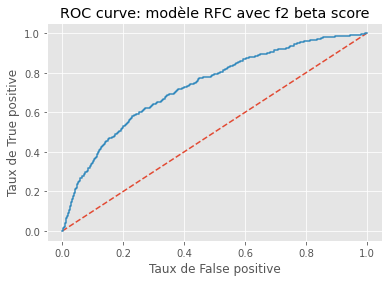

In [503]:
# %%script echo skipping
plt.style.use('ggplot')
y_pred_2_prob = gs_rfc_std.predict_proba(X_test_2)[:, 1] # classe positive (=clients en défaut)
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2_prob)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='RFC Standard avec f2 beta score')
plt.xlabel("Taux de False positive")
plt.ylabel("Taux de True positive")
plt.title("ROC curve: modèle RFC avec f2 beta score")
plt.show()

In [504]:
rfc_fbeta2_auc = auc(fpr, tpr)
print("La valeur de l'aire sous la courbe ROC est de:", rfc_fbeta2_auc)

La valeur de l'aire sous la courbe ROC est de: 0.7311249883453533


##### Courbe de Precision / Recall (observation de la balance)

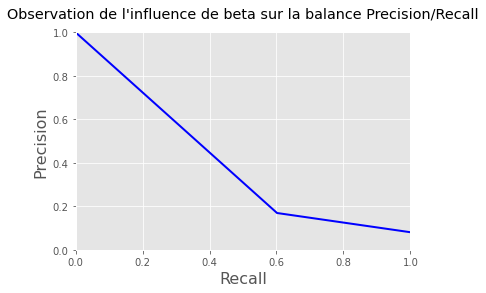

In [505]:
precisions, recalls, thresholds = precision_recall_curve(y_test_2, y_pred_rfc_std)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Observation de l'influence de beta sur la balance Precision/Recall", pad=15)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

> Bien que l'on améliore le Recall ici (baisse de Fn), la précision est affectée. Idéalement il faut trouver un équilibre, cad une bonne sensibilité tout en conservant un niveau de précision acceptable (Fp)

#### Features d'importance du modèle (based on Mean Decrease in Impurity ou MDI)

In [512]:
# important_feat = gs_rfc_std.feature_importances_
important_feat = gs_rfc_std.best_estimator_.feature_importances_

In [513]:
features_name = X_train_2.columns.tolist()
ps_feat_name = pd.Series(features_name, name='feat_name')

In [514]:
ps_imp_feat = pd.Series(important_feat, name='feat_mdi')
print(ps_imp_feat.shape)

(383,)


In [517]:
# std_imp_feat = np.std([tree.feature_importances_ for tree in gs_rfc_std.estimators_], axis=0)
std_imp_feat = np.std([tree.feature_importances_ for tree in gs_rfc_std.best_estimator_], axis=0)

In [518]:
ps_std_imp_feat = pd.Series(std_imp_feat, name='std_mdi')
print(ps_std_imp_feat.shape)

(383,)


In [519]:
df_rfc_std_imp_feat = pd.concat([ps_feat_name, ps_imp_feat, ps_std_imp_feat], axis=1)

In [520]:
df_rfc_std_imp_feat.sort_values(by='feat_mdi', inplace=True, ascending=False)

In [521]:
df_rfc_std_imp_feat.head()

feat_name  feat_mdi   std_mdi
32           EXT_SOURCE_2  0.110950  0.138083
33           EXT_SOURCE_3  0.104621  0.126361
31           EXT_SOURCE_1  0.062733  0.086497
224        YEARS_EMPLOYED  0.032870  0.057194
225  YEARS_EMPLOYED_RATIO  0.029025  0.051695

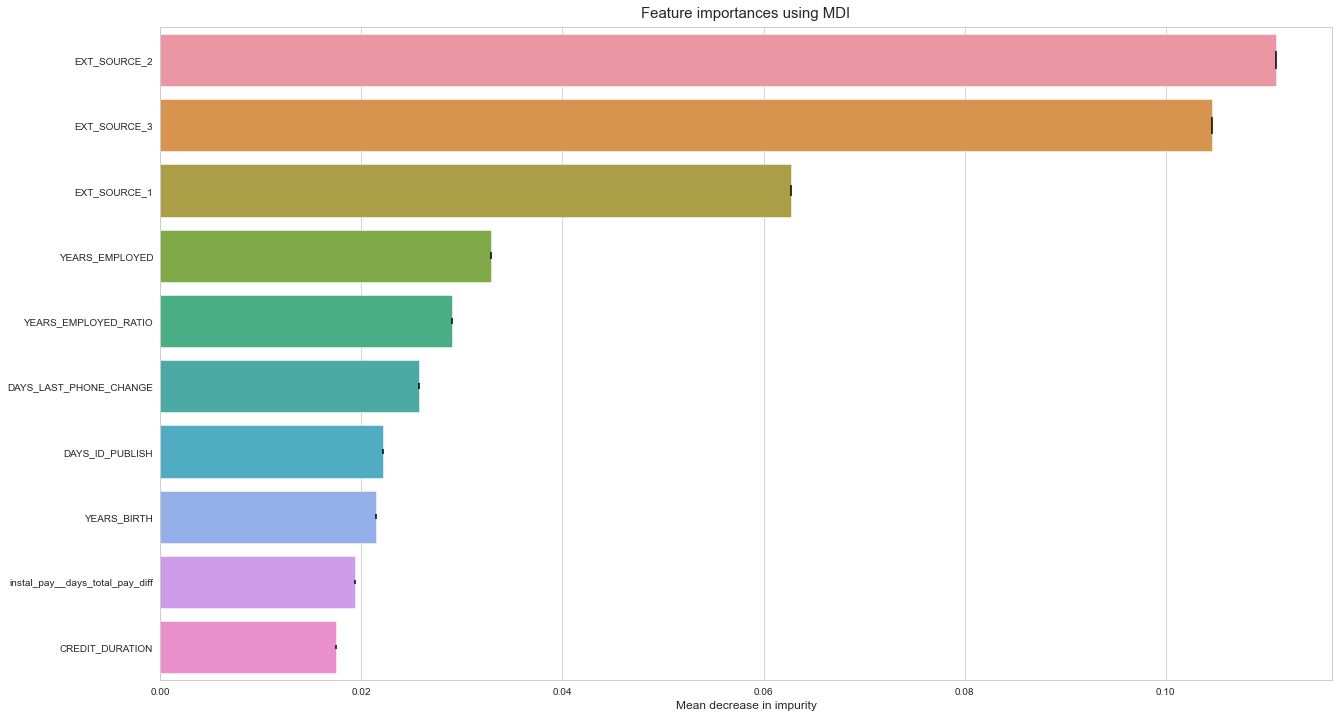

In [522]:
sns.set_style("whitegrid")
plt.figure(figsize=(21, 12))
ax = sns.barplot(x='feat_mdi', y='feat_name', yerr=df_rfc_std_imp_feat['std_mdi'][:10], data=df_rfc_std_imp_feat[:10])
ax.set_title("Feature importances using MDI", fontsize=15, pad=10)
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("")
plt.show()

#### Feature importance based on feature permutation
Citation : "Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set."

In [523]:
%%time
%%script echo skipping
result_perm_imp = permutation_importance(gs_rfc_std, X_test_2, y_test_2, n_repeats=10, random_state=42, n_jobs=2)
pickle.dump(result_perm_imp, open(path + '/fichiers_pickle/result_perm_imp.pkl', 'wb'))

Couldn't find program: 'echo'
Wall time: 3.96 ms


In [525]:
result_perm_imp = pickle.load(open(path + '/fichiers_pickle/result_perm_imp.pkl', 'rb'))

In [526]:
ps_perm_imp = pd.Series(result_perm_imp.importances_mean, name='perm_imp_feat')

In [527]:
print(ps_perm_imp.head())

0    0.000163
1   -0.001772
2   -0.001626
3    0.000211
4    0.000000
Name: perm_imp_feat, dtype: float64


In [528]:
df_perm_imp_feat = pd.concat([ps_feat_name, ps_perm_imp, pd.Series(result_perm_imp.importances_std, name='imp_std')], axis=1)

In [529]:
df_perm_imp_feat.sort_values(by='perm_imp_feat', inplace=True, ascending=False)
display(df_perm_imp_feat.head())

feat_name  perm_imp_feat   imp_std
266          instal_pay__amt_total_diff       0.002650  0.000888
268  pos_cash_bal__name_contract_status       0.001935  0.001019
229         bureau__amt_credit_sum_debt       0.001301  0.001653
241       bureau__credit_active__active       0.001024  0.000613
15                       CODE_GENDER__F       0.001008  0.000936

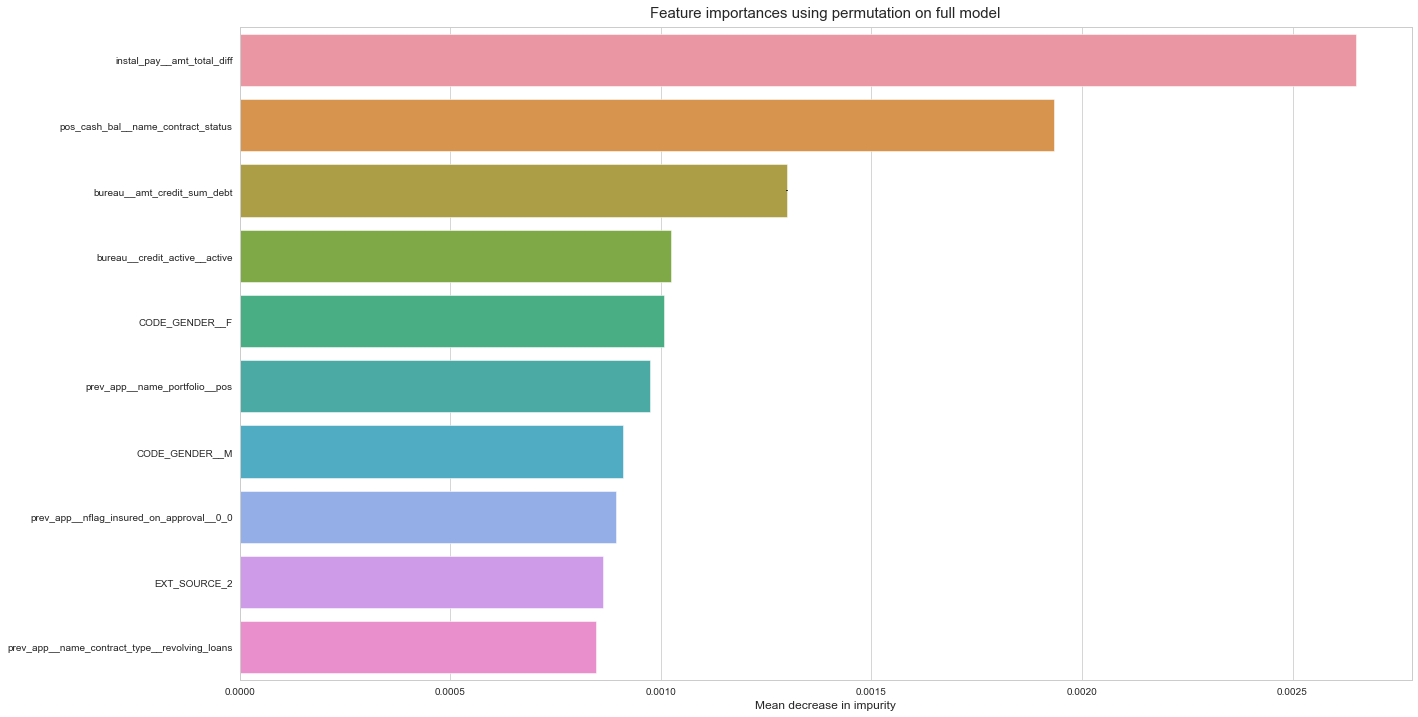

In [530]:
sns.set_style("whitegrid")
plt.figure(figsize=(21, 12))
ax = sns.barplot(x='perm_imp_feat', y='feat_name', yerr=df_perm_imp_feat['imp_std'][:10], data=df_perm_imp_feat[:10])
ax.set_title("Feature importances using permutation on full model", fontsize=15, pad=10)
ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("")
plt.show()

#### Predict & Predict_proba

In [531]:
# Avec données train (déjà normalisée et préparée)
print("Taille de l'array :", data_2.iloc[0,:].drop('TARGET').to_numpy().size) # axis=0
print("Index de la valeur a tester: {}".format(data_2.iloc[0,:].drop('TARGET').name))
print("Client en défaut de paiement (0:non, 1:oui): {}".format(data_2.loc[234502, 'TARGET']))
X_pred_to_test = data_2.iloc[0,:].drop('TARGET').to_numpy().reshape(1, -1)
print(X_pred_to_test.shape)

Taille de l'array : 383
Index de la valeur a tester: 234502
Client en défaut de paiement (0:non, 1:oui): 0.0
(1, 383)


In [2]:
%%script echo skipping
print("Prédit la classe: {:.0f}".format(gs_rfc_std.predict(X_pred_to_test)[0]))
print("Prédit la probabilité de la classe à: {:.2f} %".format(gs_rfc_std.predict_proba(X_pred_to_test)[0][0]))
# Prédit la classe: 0
# Prédit la probabilité de la classe à: 0.53 %

Couldn't find program: 'echo'


In [533]:
# Concat to retrieve original ID
df_custom_global_optim_std_w_id = pd.concat([df_custom_global_optim['SK_ID_CURR'], df_custom_global_optim_std], axis=1)

In [534]:
df_custom_global_optim_std_w_id.shape

(356255, 385)

In [ ]:
%%script echo skipping
pickle.dump(df_custom_global_optim_std_w_id, open(path + '/df_custom_global_optim_std_w_id.pkl', 'wb'))
# rajouter la colonne TARGET à l'enregistrement à partir de df_custom_global_optim['SK_ID_CURR']
# avec un concat df_custom_global_optim_std

### Bayesian optimization: Utilisation d'Hyperopt

#####  Test avec  des modèles différents pour comparer la performance

In [29]:
# XGBClassifier().get_params().keys()

In [562]:
# ration positive class vs negative class (-> hyperparamètre: scale_pos_weight)
print(y_train_2.value_counts()[1] / y_train_2.value_counts()[0])
# contrôle SMOTE

print(y_train_2_resampled.value_counts()[1] / y_train_2_resampled.value_counts()[0])

0.08781782003095291
1.0


In [563]:
from sklearn.metrics import SCORERS
print(SCORERS.keys())

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [565]:
%%time
#%%script echo skipping

import warnings
warnings.filterwarnings('ignore')

# https://github.com/ray-project/tune-sklearn/issues/186
# https://github.com/scikit-learn/scikit-learn/issues/4632

searching_space = hp.choice('classifiers', [
    
{
    'beta_value': hp.choice('rfc_beta', [2]),
    'model': 'RandomForestClassifier',
    'params': {
        'n_estimators': hp.choice('n_estimators', np.arange(250, 650, 50, dtype=int)),
        'max_depth': hp.choice('max_depth', np.arange(2, 42, 2, dtype=int)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), 
        'class_weight': hp.choice('rfc_class_weight', ['balanced', 'balanced_subsample']),
        }
},
       
])

def fn_hyperopt_tuning(args):
    
    f_beta_score = make_scorer(fbeta_score, beta=args['beta_value'])
    
    print("args['model']:", str(args['model'])[:20])
    
    # model selection
    if args['model'] == 'RandomForestClassifier': # besoin de "fitter" les paramètres avant sinon cela lève une exception répertoriée
        
        clf = RandomForestClassifier(
            n_estimators = args['params']['n_estimators'],
            max_depth = args['params']['max_depth'],
            criterion = args['params']['criterion'],
            max_features = args['params']['max_features'],
            class_weight = args['params']['class_weight'],
            random_state = 42,
            #n_jobs = -1
        )
        
    elif args['model'] == 'CatBoostClassifier':  # To avoid --> job exception: You can't change params of fitted model
        
        clf = CatBoostClassifier(
            depth = args['params']['depth'],
            border_count = args['params']['border_count'],
            learning_rate = args['params']['learning_rate'],
            l2_leaf_reg = args['params']['l2_leaf_reg'],
            scale_pos_weight = args['params']['scale_pos_weight'],
            verbose = 0,
            # n_jobs = -1
        )
        
    else: # Charge les autres modèles à tester via un pipeline
                
        pipe = Pipeline(steps=[
            ('model', args['model']) # args['model'] sera envoyée par fmin à partir de l'espace de recherche (space)
        ])

        pipe.set_params(**args['params'])
        
    if args['model'] == 'RandomForestClassifier' or args['model'] == 'CatBoostClassifier':

        score = cross_val_score(
            clf,
            X_train_2, # X_train_2, X_train_2_resampled
            y_train_2, # y_train_2, y_train_2_resampled
            n_jobs = 2,  # 2
            scoring = f_beta_score, # 'precision',  # f_beta_score, # 'recall', # 'f1'
            cv = StratifiedKFold(n_splits=5),
        ).mean()
        
    else:
        
        # kwargs = {pipe.steps[-1][0] + '__sample_weight': arr_sample_weights_2}
        # pipe.fit(X_train_2, y_train_2, **kwargs)  # arr_sample_weights_2
        # y_pred_proba_train = pipe.predict_proba(X_train_2)
        score = cross_val_score(
            pipe,
            X_train_2,  #X_train_2_resampled,
            y_train_2,  # y_train_2_resampled,
            n_jobs = -1,
            scoring = f_beta_score, # 'recall'
            cv = StratifiedKFold(n_splits=5),
        ).mean()
    
    #print("Model:", args['model'])
    print ("custom score: {}".format(score))
    return {'loss': -score, 'status': STATUS_OK, 'trained_model': args['model']}

trials = Trials()

best_clf = fmin(
    fn = fn_hyperopt_tuning,
    space = searching_space,
    algo = tpe.suggest,
    max_evals = 15,
    trials = trials,
    rstate=np.random.RandomState(42)
)

print(best_clf, '\n')
print(space_eval(searching_space, best_clf))

args['model']:                                        
RandomForestClassifi                                  
custom score: 0.023506388505057728                    
args['model']:                                                                     
RandomForestClassifi                                                               
custom score: 0.23320868290028168                                                  
args['model']:                                                                     
RandomForestClassifi                                                              
custom score: 0.12360707416235635                                                 
args['model']:                                                                    
RandomForestClassifi                                                              
custom score: 0.008762970638237475                                                
args['model']:                                                                    
R

In [ ]:
# https://catboost.ai/en/docs/references/training-parameters/
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

"""

{
    #'beta_value': hp.choice('svc_beta', np.arange(0.5, 3.15, 0.25)),
    'beta_value': hp.choice('svc_beta', [1.8]),
    'model': SVC(),
    'params': {
        # 'model__C': hp.uniform('C', 0, 10.0),
        'model__C': hp.choice('C', [1, 2, 5, 7, 10]),
        # 'model__kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        'model__kernel': hp.choice('kernel', ['linear', 'rbf']), # poly -> degré 3 par défaut
        'model__gamma': hp.uniform('gamma', 0, 20.0),
        'model__tol': hp.choice('tol', [0.0001, 0.001, 0.01]),
        'model__class_weight': hp.choice('svc_class_weight', ['balanced', None]),
    }
},

{
    'beta_value': hp.choice('rfc_beta', [1.99]),
    'model': 'RandomForestClassifier',
    'params': {
        'n_estimators': hp.choice('n_estimators', np.arange(250, 650, 50, dtype=int)),
        'max_depth': hp.choice('max_depth', np.arange(2, 42, 2, dtype=int)),
        'criterion': hp.choice('criterion', ["gini", "entropy"]),
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), 
        'class_weight': hp.choice('rfc_class_weight', ['balanced', 'balanced_subsample']),
        }
},

{
    'beta_value': hp.choice('cb_beta', [1.99]),
    'model': 'CatBoostClassifier',
    'params': {
        'depth': hp.choice('depth', np.arange(1, 10, 1, dtype=int)),
        'border_count': hp.choice('border_count', np.arange(32, 255, 1, dtype=int)),
        'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.03, 0.1, 0.2, 0.3]),
        'l2_leaf_reg': hp.choice('l2_leaf_reg', [1, 3, 5, 10, 20, 50, 100]),
        'scale_pos_weight': hp.quniform('scale_pos_weight', 0, 100, 0.1),  # marche mieux qu'avec l'affectation manuelle (valeur trouvée différente)
        }
},

{
    # 'beta_value': hp.choice('xgb_beta', [2.2, 2.21,2.22,2.23,2.24,2.25,2.26,2.27,2.28,2.29]),
    'beta_value': hp.choice('xgb_beta', [2.2]),
    # 'beta_value': hp.choice('svc_beta', np.arange(0.5, 3.15, 0.25)),
    'model': xgb.XGBClassifier(use_label_encoder=False, verbosity=0),
    'params': {
        'model__n_estimators' : hp.choice('xgb.n_estimators', np.arange(5, 50, 1, dtype=int)),
        'model__max_depth': hp.choice('xgb.max_depth', np.arange(5, 30, 1, dtype=int)),
        'model__learning_rate': hp.quniform('xgb.learning_rate', 0.01, 0.5, 0.01),
        'model__gamma':  hp.choice('xgb.gamma', np.arange(0, 20, 2, dtype=int)),
        'model__reg_lambda' : hp.uniform('xgb.reg_lambda', 0,1),
        'model__reg_alpha' : hp.uniform('xgb.reg_alpha', 0,1),
        # scale_pos_weight = total_negative_examples / total_positive_examples
        'model__scale_pos_weight': hp.quniform('xgb.scale_pos_weight', 0, 100, 0.1), # ratio of number of negative class to the positive class 
        'model__subsample': hp.quniform('xgb.subsample', 0.1, 0.8, 0.1), # fraction of the training set that can be used to train each tree
        }
},"""

In [566]:
print(space_eval(searching_space, best_clf))

{'beta_value': 2, 'model': 'RandomForestClassifier', 'params': {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 450}}


In [567]:
model_selected = space_eval(searching_space, best_clf)['model']
params_found = space_eval(searching_space, best_clf)['params']
print(params_found, '\n')
beta_value = space_eval(searching_space, best_clf)['beta_value']
print("Rappel: beta_value sélectionnée ->", beta_value)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 450} 

Rappel: beta_value sélectionnée -> 2


In [481]:
%%script echo skipping
# loading manuel pour récupération de modèle (différence de version installée SVC)
params_found = {
    'model__C': 2,
    'model__class_weight': 'balanced',
    'model__gamma': 1.3810268174720841,
    'model__kernel': 'linear',
    'model__tol': 0.001
}

Couldn't find program: 'echo'


In [482]:
%%script echo skipping
# Boucle nécessaire pour extraire les paramètres de certains modèles (e.g. XGBClassifier)

for elt in [key.split('__')[1] for key in params_found]:
    old_key = "model__" + elt
    params_found[elt] = params_found.pop(old_key)
print(params_found)

Couldn't find program: 'echo'


In [568]:
# best_model_hyperopt = RandomForestClassifier(**params_found)
# best_model_hyperopt = xgb.XGBClassifier(**params_found)
# best_model_hyperopt = SVC(**params_found)
# best_model_hyperopt = SVC(**params_found, probability=True)
# best_model_hyperopt = CatBoostClassifier(**params_found)

best_model_hyperopt = RandomForestClassifier(**params_found)
print(best_model_hyperopt)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', n_estimators=450)


##### Fitting

In [569]:
# print(model_selected)
# print(params_found)
# print(beta_value)
# best_model_hyperopt.fit(X_train_2, y_train_2, sample_weight=arr_sample_weights_2)
best_model_hyperopt.fit(X_train_2, y_train_2)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', n_estimators=450)

In [571]:
%%script echo skipping
# enregistrement des résultats pour utilisation ultérieure
pickle.dump(best_model_hyperopt, open(path + '/fichiers_pickle/rfc_01_hyperopt.pkl', 'wb'))

Couldn't find program: 'echo'


In [572]:
%%script echo skipping
best_model_hyperopt = pickle.load(open(path + '/fichiers_pickle/rfc_01_hyperopt.pkl', 'rb'))
print(best_model_hyperopt)

RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', n_estimators=450)


In [487]:
%%script echo skipping
#best_rfc_hyperopt.fit(X_train_2, y_train_2) # avec Beta = 4
best_model_hyperopt.fit(X_train_2, y_train_2)

Couldn't find program: 'echo'


##### Joblib : enregistrement et chargement du modèle

In [573]:
# joblib
save_load_gs_model('save', 'rfc_hyperopt', best_model_hyperopt)

In [574]:
joblib_best_model_hyperopt = save_load_gs_model('load', 'rfc_hyperopt')
print("rfc_hyperopt :", joblib_best_model_hyperopt)

rfc_hyperopt : RandomForestClassifier(class_weight='balanced', max_depth=6,
                       max_features='sqrt', n_estimators=450)


In [575]:
# joblib_best_model_hyperopt.get_params().keys()
# joblib_best_model_hyperopt.get_xgb_params()
# joblib_best_model_hyperopt.best_params_
joblib_best_model_hyperopt.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 450,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [576]:
#joblib_best_model_hyperopt.fit(X_train_2, y_train_2)
beta_value = 2
y_pred_model_hyperopt = joblib_best_model_hyperopt.predict(X_test_2)
print("f beta score sur le jeu de test: {}".format(fbeta_score(y_test_2, y_pred_model_hyperopt, average='binary', beta=beta_value)))
print("Accuracy sur le jeu de test: {}".format(joblib_best_model_hyperopt.score(X_test_2, y_test_2)))
print("beta value:", beta_value)

f beta score sur le jeu de test: 0.38840416549394874
Accuracy sur le jeu de test: 0.7545114615509674
beta value: 2


##### Matrice de confusion

In [577]:
cm_model_hyperopt = confusion_matrix(y_test_2, y_pred_model_hyperopt)
print(cm_model_hyperopt)

[[4365 1289]
 [ 221  276]]


##### Classification report

In [578]:
print(classification_report(y_test_2, y_pred_model_hyperopt))

              precision    recall  f1-score   support

         0.0       0.95      0.77      0.85      5654
         1.0       0.18      0.56      0.27       497

    accuracy                           0.75      6151
   macro avg       0.56      0.66      0.56      6151
weighted avg       0.89      0.75      0.81      6151



##### Courbe précision/recall

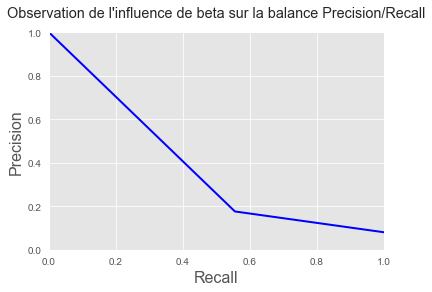

In [579]:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432
# The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets
plt.style.use('ggplot')
precisions, recalls, thresholds = precision_recall_curve(y_test_2, y_pred_model_hyperopt)
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Observation de l'influence de beta sur la balance Precision/Recall", pad=15)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()

##### Courbe ROC & AUC

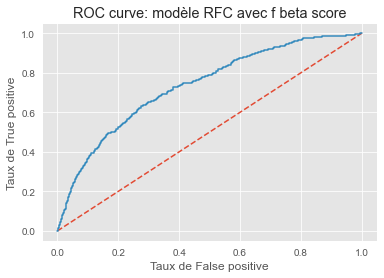

In [580]:
plt.style.use('ggplot')
y_pred_2_prob = joblib_best_model_hyperopt.predict_proba(X_test_2)[:, 1] # classe positive (=clients en défaut)
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_2_prob)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='RFC Standard avec f beta score')
plt.xlabel("Taux de False positive")
plt.ylabel("Taux de True positive")
plt.title("ROC curve: modèle RFC avec f beta score")
plt.show()

In [581]:
model_fbeta_auc = auc(fpr, tpr)
print("La valeur de l'aire sous la courbe ROC est de:", model_fbeta_auc)

La valeur de l'aire sous la courbe ROC est de: 0.734301457845054


#### SVC entraînement et vérification

In [537]:
svc = SVC(
    C=2,
    class_weight='balanced',
    gamma=1.3810268174720841,
    kernel='linear',
    tol=0.001,
    probability=True
)

In [538]:
%%time
svc.fit(X_train_2, y_train_2)

Wall time: 24min 53s


SVC(C=2, class_weight='balanced', gamma=1.3810268174720841, kernel='linear',
    probability=True)

In [539]:
y_pred_svc = svc.predict(X_test_2)
print("f beta score sur le jeu de test: {}".format(fbeta_score(y_test_2, y_pred_svc, average='binary', beta=2)))
print("Accuracy sur le jeu de test: {}".format(svc.score(X_test_2, y_test_2)))

f beta score sur le jeu de test: 0.420253164556962
Accuracy sur le jeu de test: 0.7081775321086002


In [540]:
cm_svc = confusion_matrix(y_test_2, y_pred_svc)
print(cm_svc)

[[4024 1630]
 [ 165  332]]


In [541]:
print(classification_report(y_test_2, y_pred_svc))

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82      5654
         1.0       0.17      0.67      0.27       497

    accuracy                           0.71      6151
   macro avg       0.56      0.69      0.54      6151
weighted avg       0.90      0.71      0.77      6151



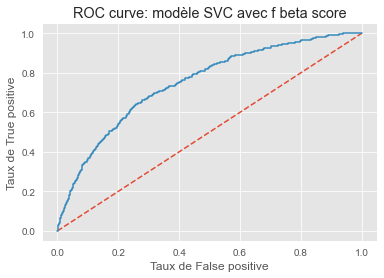

In [542]:
plt.style.use('ggplot')
y_pred_svc = svc.predict_proba(X_test_2)[:, 1] # classe positive (=clients en défaut)
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_svc)
plt.plot([0, 1], [0, 1], '--')
plt.plot(fpr, tpr, label='SVC avec f beta score 2')
plt.xlabel("Taux de False positive")
plt.ylabel("Taux de True positive")
plt.title("ROC curve: modèle SVC avec f beta score")
plt.show()

In [543]:
model_svc_auc = auc(fpr, tpr)
print("La valeur de l'aire sous la courbe ROC est de:", model_svc_auc)

La valeur de l'aire sous la courbe ROC est de: 0.7482592762090763


#### Nearest Neighbors from model

In [544]:
# Il faut partir sur la totalité des données clients
with gzip.open(path + '/fichiers_pickle/df_custom_global_optim_std_w_id.pkl.gz', 'rb') as df:
    df_to_load = pickle.load(df)

In [545]:
# Les colonnes 'SK_ID_CURR' et 'TARGET' sont inutiles
full_customers_data = df_to_load.drop(['SK_ID_CURR', 'TARGET'], axis=1).copy()
print("full_customers_data:", full_customers_data.shape)  # doit contenir 383 features au total

full_customers_data: (356255, 383)


In [546]:
# Modification pour tests GUI de développement de l'application
full_customers_data = df_to_load.drop(['TARGET'], axis=1).copy()
full_customers_data.set_index(['SK_ID_CURR'], inplace=True)
print("full_customers_data:", full_customers_data.shape)

full_customers_data: (356255, 383)


In [547]:
# Prenons un client identifié
display(full_customers_data.iloc[1])

AMT_ANNUITY                                 0.132924
AMT_CREDIT                                  0.311736
AMT_GOODS_PRICE                             0.271605
AMT_INCOME_TOTAL                            0.002089
AMT_REQ_CREDIT_BUREAU_DAY                   0.000000
                                              ...   
prev_app__name_seller_industry__tourism     0.000000
prev_app__name_seller_industry__xna         0.014706
prev_app__nflag_insured_on_approval__0_0    0.047619
prev_app__nflag_insured_on_approval__1_0    0.086957
prev_app__rate_down_payment                 0.526639
Name: 100003, Length: 383, dtype: float64

In [548]:
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html
n_neigh = NearestNeighbors(n_neighbors=20)
# n_neigh.fit(full_customers_data)  # Pour vérifier avec le profil client
n_neigh.fit(full_customers_data.drop([full_customers_data.index[1]]))

NearestNeighbors(n_neighbors=20)

In [549]:
customer_profil = full_customers_data.iloc[1].values.reshape(1, -1)
print(customer_profil.shape)

(1, 383)


In [3]:
%%script echo skipping
# On doit retomber sur le même
customer_neighbors = n_neigh.kneighbors(customer_profil)
print(customer_neighbors, '\n')
customer_neighbors_list = customer_neighbors[1][0].tolist()
print("List of similar profils (array indices):", customer_neighbors_list)

"""
(array([[2.0133569 , 2.03122337, 2.4882359 , 2.49562033, 2.52477691,
        2.52700473, 2.54792694, 2.54895355, 2.56165659, 2.57334195,
        2.5751851 , 2.62879623, 2.66101039, 2.66877643, 2.68712201,
        2.69085768, 2.7097032 , 2.71403122, 2.72682963, 2.73047203]]), array([[ 33270,  14574, 210250, 310967, 240910, 100973,  59297, 227809,
        123289, 135061, 287287,   1165,  81115, 232233, 196046, 262433,
         10125,  23965, 290526, 329681]], dtype=int64)) 

List of similar profils (array indices): [33270, 14574, 210250, 310967, 240910, 100973, 59297, 227809, 123289, 135061, 287287, 1165, 81115, 232233, 196046, 262433, 10125, 23965, 290526, 329681]
"""

Couldn't find program: 'echo'


In [553]:
# On vérifie
with pd.option_context('display.max_columns', None):
    display(df_to_load.loc[customer_neighbors_list, 'TARGET'])
    display(df_to_load[['TARGET']].iloc[customer_neighbors_list])

33270     0.0
14574     0.0
210250    0.0
310967    NaN
240910    0.0
100973    0.0
59297     0.0
227809    0.0
123289    0.0
135061    0.0
287287    0.0
1165      1.0
81115     0.0
232233    0.0
196046    0.0
262433    0.0
10125     0.0
23965     0.0
290526    0.0
329681    NaN
Name: TARGET, dtype: float64

TARGET
33270      0.0
14574      0.0
210250     0.0
310967     NaN
240910     0.0
100973     0.0
59297      0.0
227809     0.0
123289     0.0
135061     0.0
287287     0.0
1165       1.0
81115      0.0
232233     0.0
196046     0.0
262433     0.0
10125      0.0
23965      0.0
290526     0.0
329681     NaN

In [4]:
%%script echo skipping
# prediction des 20 plus proches voisins (moyenne)
# Il faut enlever 'TARGET' & 'SK_ID_CURR'
model = joblib_gs_rfc_std
n_neigh_customers_list = df_to_load.drop(['TARGET', 'SK_ID_CURR'], axis=1).iloc[customer_neighbors_list].values
predict_proba_n_neigh_customers = model.predict_proba(n_neigh_customers_list)
print("predict_proba_n_neigh_customers:", np.mean(predict_proba_n_neigh_customers, axis=0), '\n')
print("predict_proba_n_neigh_customers:", predict_proba_n_neigh_customers)

"""
predict_proba_n_neigh_customers: [0.55451785 0.44548215] 

predict_proba_n_neigh_customers: [[0.58639342 0.41360658]
 [0.62259932 0.37740068]
 [0.45277481 0.54722519]
 [0.59884274 0.40115726]
 [0.5524321  0.4475679 ]
 [0.60822243 0.39177757]
 [0.41536323 0.58463677]
 [0.42007537 0.57992463]
 [0.58091252 0.41908748]
 [0.53677106 0.46322894]
 [0.54621418 0.45378582]
 [0.51108978 0.48891022]
 [0.4432769  0.5567231 ]
 [0.59932357 0.40067643]
 [0.57819463 0.42180537]
 [0.58230586 0.41769414]
 [0.60498768 0.39501232]
 [0.63963448 0.36036552]
 [0.6042967  0.3957033 ]
 [0.6066462  0.3933538 ]]
"""

Couldn't find program: 'echo'


In [5]:
%%script echo skipping
# predict_proba avec le client d'origine
original_customer = df_to_load.drop(['TARGET', 'SK_ID_CURR'], axis=1).iloc[1].values.reshape(1, -1)
predict_proba_original_customer = model.predict_proba(original_customer)
print("predict_proba_original_customer:", predict_proba_original_customer)

# predict_proba_original_customer: [[0.60827032 0.39172968]]

Couldn't find program: 'echo'


In [556]:
predict_proba_original_customer[0][0]

0.6082703164635099

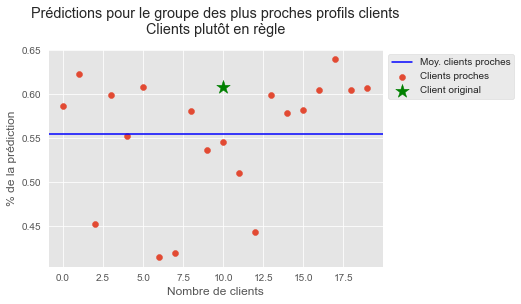

In [557]:
no_default_neighbors = np.mean(predict_proba_n_neigh_customers[:, 0], axis=0)
default_neighbors = np.mean(predict_proba_n_neigh_customers[:, 1], axis=0)

if no_default_neighbors > default_neighbors:
    col_preds = 0
    title_preds = "Clients plutôt en règle"
    mean_preds = no_default_neighbors
else:
    col_preds = 1
    title_preds = "Clients plutôt en défaut"
    mean_preds = default_neighbors
    
customers_nbr = range(len(predict_proba_n_neigh_customers))
    
plt.style.use('ggplot')
plt.scatter(customers_nbr, predict_proba_n_neigh_customers[:, col_preds], label='Clients proches')
plt.axhline(y=mean_preds, color='b', linestyle='-', label='Moy. clients proches')
plt.scatter(int(len(predict_proba_n_neigh_customers) // 2), predict_proba_original_customer[0][col_preds], color='g', marker='*', s=200, label='Client original')
plt.title("Prédictions pour le groupe des plus proches profils clients\n" + title_preds, pad=15)
plt.xlabel("Nombre de clients")
plt.ylabel("% de la prédiction")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

#### LIME: "Explication/compréhension du résultat de prédiction

In [558]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(X_train_2),
    feature_names=X_train_2.columns,
    verbose=True,
    mode='classification',
    random_state=42
)

In [560]:
with gzip.open(path + '/fichiers_pickle/df_custom_global_optim_std_w_id.pkl.gz', 'rb') as df:
    df_to_load = pickle.load(df)

In [6]:
%%script echo skipping
model = joblib_best_model_hyperopt
print(model)

Couldn't find program: 'echo'


In [ ]:
%%time
# Prediction_local -> intercept + la somme des coefs
# Right -> La prédiction du modèle d'origine
explanation = explainer.explain_instance(
    df_to_load.drop(['TARGET', 'SK_ID_CURR'], axis=1).iloc[236],  # original_customer
    model.predict_proba,
    num_features=4
)

explanation.show_in_notebook(show_table=True, show_all=False)

In [ ]:
explanation_df = pd.DataFrame(explanation.as_list())
print(explanation_df)

In [ ]:
print(explanation.as_list(), '\n')
print(explanation.as_map())
col_feat_idx_list = [feat[0] for feat in explanation.as_map()[1]]
print(col_feat_idx_list)

In [ ]:
full_customers_data.columns[col_feat_idx_list].tolist()

#### Variables catégorielles -> récupération pour  "améliorer" l'expérience d'utilisation du dashboard via l'API
Certaines variables seront très probablement ajoutées au dashboard pour ensuite enrichir l'expérience utilisateur.

In [ ]:
full_customers_data.columns.tolist()

In [ ]:
with pd.option_context('display.max_columns', None):
    display(full_customers_data.agg(['min', 'max', 'median']))

In [ ]:
list_of_cat_feats = [
    'CODE_GENDER__F', # pertinent
    'CODE_GENDER__M',
    'CODE_GENDER__XNA',
    
    'EMERGENCYSTATE_MODE__No',
    'EMERGENCYSTATE_MODE__UNSPECIFIED',
    'EMERGENCYSTATE_MODE__Yes',
    
    'FLAG_CONT_MOBILE', # -> possible boolean (yes, No)
    
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    
    'FLAG_EMAIL',
    
    'FLAG_EMP_PHONE',
    
    'FLAG_MOBIL',
    
    'FLAG_OWN_CAR__N',  # pertinent
    'FLAG_OWN_CAR__Y',
    
    'FLAG_OWN_REALTY__N',
    'FLAG_OWN_REALTY__Y',
    
    'FLAG_PHONE'
    
    'FONDKAPREMONT_MODE__UNSPECIFIED',
    'FONDKAPREMONT_MODE__not specified',
    'FONDKAPREMONT_MODE__org spec account',
    'FONDKAPREMONT_MODE__reg oper account',
    'FONDKAPREMONT_MODE__reg oper spec account',
    
    'HOUSETYPE_MODE__UNSPECIFIED',
    'HOUSETYPE_MODE__block of flats',
    'HOUSETYPE_MODE__specific housing',
    'HOUSETYPE_MODE__terraced house',
    
    'LIVE_CITY_NOT_WORK_CITY',
    
    'LIVE_REGION_NOT_WORK_REGION',
    
    'NAME_CONTRACT_TYPE__Cash loans',  # pertinent
    'NAME_CONTRACT_TYPE__Revolving loans',
    
    'NAME_EDUCATION_TYPE__Academic degree',  # pertinent
    'NAME_EDUCATION_TYPE__Higher education',
    'NAME_EDUCATION_TYPE__Incomplete higher',
    'NAME_EDUCATION_TYPE__Lower secondary',
    'NAME_EDUCATION_TYPE__Secondary / secondary special',
    
    'NAME_FAMILY_STATUS__Civil marriage',  # pertinent
    'NAME_FAMILY_STATUS__Married',
    'NAME_FAMILY_STATUS__Separated',
    'NAME_FAMILY_STATUS__Single / not married',
    'NAME_FAMILY_STATUS__Unknown',
    'NAME_FAMILY_STATUS__Widow',
    
    'NAME_HOUSING_TYPE__Co-op apartment',  # pertinent
    'NAME_HOUSING_TYPE__House / apartment',
    'NAME_HOUSING_TYPE__Municipal apartment',
    'NAME_HOUSING_TYPE__Office apartment',
    'NAME_HOUSING_TYPE__Rented apartment',
    'NAME_HOUSING_TYPE__With parents',
    
    'NAME_INCOME_TYPE__Businessman',  # pertinent
    'NAME_INCOME_TYPE__Commercial associate',
    'NAME_INCOME_TYPE__Maternity leave',
    'NAME_INCOME_TYPE__Pensioner',
    'NAME_INCOME_TYPE__State servant',
    'NAME_INCOME_TYPE__Student',
    'NAME_INCOME_TYPE__Unemployed',
    'NAME_INCOME_TYPE__Working',
    
    'NAME_TYPE_SUITE__Children',  # A voir
    'NAME_TYPE_SUITE__Family',
    'NAME_TYPE_SUITE__Group of people',
    'NAME_TYPE_SUITE__Other_A',
    'NAME_TYPE_SUITE__Other_B',
    'NAME_TYPE_SUITE__Spouse, partner',
    'NAME_TYPE_SUITE__UNSPECIFIED',
    'NAME_TYPE_SUITE__Unaccompanied',
    
    'OCCUPATION_TYPE__Accountants',  # pertinent 
    'OCCUPATION_TYPE__Cleaning staff',
    'OCCUPATION_TYPE__Cooking staff',
    'OCCUPATION_TYPE__Core staff',
    'OCCUPATION_TYPE__Drivers',
    'OCCUPATION_TYPE__HR staff',
    'OCCUPATION_TYPE__High skill tech staff',
    'OCCUPATION_TYPE__IT staff',
    'OCCUPATION_TYPE__Laborers',
    'OCCUPATION_TYPE__Low-skill Laborers',
    'OCCUPATION_TYPE__Managers',
    'OCCUPATION_TYPE__Medicine staff',
    'OCCUPATION_TYPE__Private service staff',
    'OCCUPATION_TYPE__Realty agents',
    'OCCUPATION_TYPE__Sales staff',
    'OCCUPATION_TYPE__Secretaries',
    'OCCUPATION_TYPE__Security staff',
    'OCCUPATION_TYPE__UNSPECIFIED',
    'OCCUPATION_TYPE__Waiters/barmen staff',
    
    'ORGANIZATION_TYPE__Advertising',  # pertinent
    'ORGANIZATION_TYPE__Agriculture',
    'ORGANIZATION_TYPE__Bank',
    'ORGANIZATION_TYPE__Business Entity Type 1',
    'ORGANIZATION_TYPE__Business Entity Type 2',
    'ORGANIZATION_TYPE__Business Entity Type 3',
    'ORGANIZATION_TYPE__Cleaning',
    'ORGANIZATION_TYPE__Construction',
    'ORGANIZATION_TYPE__Culture',
    'ORGANIZATION_TYPE__Electricity',
    'ORGANIZATION_TYPE__Emergency',
    'ORGANIZATION_TYPE__Government',
    'ORGANIZATION_TYPE__Hotel',
    'ORGANIZATION_TYPE__Housing',
    'ORGANIZATION_TYPE__Industry: type 1',
    'ORGANIZATION_TYPE__Industry: type 10',
    'ORGANIZATION_TYPE__Industry: type 11',
    'ORGANIZATION_TYPE__Industry: type 12',
    'ORGANIZATION_TYPE__Industry: type 13',
    'ORGANIZATION_TYPE__Industry: type 2',
    'ORGANIZATION_TYPE__Industry: type 3',
    'ORGANIZATION_TYPE__Industry: type 4',
    'ORGANIZATION_TYPE__Industry: type 5',
    'ORGANIZATION_TYPE__Industry: type 6',
    'ORGANIZATION_TYPE__Industry: type 7',
    'ORGANIZATION_TYPE__Industry: type 8',
    'ORGANIZATION_TYPE__Industry: type 9',
    'ORGANIZATION_TYPE__Insurance',
    'ORGANIZATION_TYPE__Kindergarten',
    'ORGANIZATION_TYPE__Legal Services',
    'ORGANIZATION_TYPE__Medicine',
    'ORGANIZATION_TYPE__Military',
    'ORGANIZATION_TYPE__Mobile',
    'ORGANIZATION_TYPE__Other',
    'ORGANIZATION_TYPE__Police',
    'ORGANIZATION_TYPE__Postal',
    'ORGANIZATION_TYPE__Realtor',
    'ORGANIZATION_TYPE__Religion',
    'ORGANIZATION_TYPE__Restaurant',
    'ORGANIZATION_TYPE__School',
    'ORGANIZATION_TYPE__Security',
    'ORGANIZATION_TYPE__Security Ministries',
    'ORGANIZATION_TYPE__Self-employed',
    'ORGANIZATION_TYPE__Services',
    'ORGANIZATION_TYPE__Telecom',
    'ORGANIZATION_TYPE__Trade: type 1',
    'ORGANIZATION_TYPE__Trade: type 2',
    'ORGANIZATION_TYPE__Trade: type 3',
    'ORGANIZATION_TYPE__Trade: type 4',
    'ORGANIZATION_TYPE__Trade: type 5',
    'ORGANIZATION_TYPE__Trade: type 6',
    'ORGANIZATION_TYPE__Trade: type 7',
    'ORGANIZATION_TYPE__Transport: type 1',
    'ORGANIZATION_TYPE__Transport: type 2',
    'ORGANIZATION_TYPE__Transport: type 3',
    'ORGANIZATION_TYPE__Transport: type 4',
    'ORGANIZATION_TYPE__University',
    'ORGANIZATION_TYPE__XNA',
    
    'REG_CITY_NOT_LIVE_CITY',
    
    'REG_CITY_NOT_WORK_CITY',
    
    'REG_REGION_NOT_LIVE_REGION',
    
    'REG_REGION_NOT_WORK_REGION',
    
    'WALLSMATERIAL_MODE__Block',
    'WALLSMATERIAL_MODE__Mixed',
    'WALLSMATERIAL_MODE__Monolithic',
    'WALLSMATERIAL_MODE__Others',
    'WALLSMATERIAL_MODE__Panel',
    'WALLSMATERIAL_MODE__Stone, brick',
    'WALLSMATERIAL_MODE__UNSPECIFIED',
    'WALLSMATERIAL_MODE__Wooden',
    
    'WEEKDAY_APPR_PROCESS_START__FRIDAY',
    'WEEKDAY_APPR_PROCESS_START__MONDAY',
    'WEEKDAY_APPR_PROCESS_START__SATURDAY',
    'WEEKDAY_APPR_PROCESS_START__SUNDAY',
    'WEEKDAY_APPR_PROCESS_START__THURSDAY',
    'WEEKDAY_APPR_PROCESS_START__TUESDAY',
    'WEEKDAY_APPR_PROCESS_START__WEDNESDAY',
    
    'bureau__bureau_bal__status__0',
    'bureau__bureau_bal__status__1',
    'bureau__bureau_bal__status__2',
    'bureau__bureau_bal__status__3',
    'bureau__bureau_bal__status__4',
    'bureau__bureau_bal__status__5',
    'bureau__bureau_bal__status__c',
    'bureau__bureau_bal__status__x',
    
    'bureau__credit_type__another_type_of_loan',  # A voir
    'bureau__credit_type__car_loan',
    'bureau__credit_type__cash_loan__non_earmarked_',
    'bureau__credit_type__consumer_credit',
    'bureau__credit_type__credit_card',
    'bureau__credit_type__interbank_credit',
    'bureau__credit_type__loan_for_business_development',
    'bureau__credit_type__loan_for_purchase_of_shares__margin_lending_',
    'bureau__credit_type__loan_for_the_purchase_of_equipment',
    'bureau__credit_type__loan_for_working_capital_replenishment',
    'bureau__credit_type__microloan',
    'bureau__credit_type__mobile_operator_loan',
    'bureau__credit_type__mortgage',
    'bureau__credit_type__real_estate_loan',
    'bureau__credit_type__unknown_type_of_loan',
    
    'prev_app__channel_type__ap___cash_loan_',  # A voir
    'prev_app__channel_type__car_dealer',
    'prev_app__channel_type__channel_of_corporate_sales',
    'prev_app__channel_type__contact_center',
    'prev_app__channel_type__country_wide',
    'prev_app__channel_type__credit_and_cash_offices',
    'prev_app__channel_type__regional___local',
    'prev_app__channel_type__stone',
    
    'prev_app__channel_type__regional___local',
    'prev_app__channel_type__stone',
    
    'prev_app__code_reject_reason__client',  # A voir
    'prev_app__code_reject_reason__hc',
    'prev_app__code_reject_reason__limit',
    'prev_app__code_reject_reason__sco',
    'prev_app__code_reject_reason__scofr',
    'prev_app__code_reject_reason__system',
    'prev_app__code_reject_reason__verif',
    'prev_app__code_reject_reason__xap',
    'prev_app__code_reject_reason__xna',
    
    'prev_app__name_cash_loan_purpose__building_a_house_or_an_annex',  # A voir
    'prev_app__name_cash_loan_purpose__business_development',
    'prev_app__name_cash_loan_purpose__buying_a_garage',
    'prev_app__name_cash_loan_purpose__buying_a_holiday_home___land',
    'prev_app__name_cash_loan_purpose__buying_a_home',
    'prev_app__name_cash_loan_purpose__buying_a_new_car',
    'prev_app__name_cash_loan_purpose__buying_a_used_car',
    'prev_app__name_cash_loan_purpose__car_repairs',
    'prev_app__name_cash_loan_purpose__education',
    'prev_app__name_cash_loan_purpose__everyday_expenses',
    'prev_app__name_cash_loan_purpose__furniture',
    'prev_app__name_cash_loan_purpose__gasification___water_supply',
    'prev_app__name_cash_loan_purpose__hobby',
    'prev_app__name_cash_loan_purpose__journey',
    'prev_app__name_cash_loan_purpose__medicine',
    'prev_app__name_cash_loan_purpose__money_for_a_third_person',
    'prev_app__name_cash_loan_purpose__other',
    'prev_app__name_cash_loan_purpose__payments_on_other_loans',
    'prev_app__name_cash_loan_purpose__purchase_of_electronic_equipment',
    'prev_app__name_cash_loan_purpose__refusal_to_name_the_goal',
    'prev_app__name_cash_loan_purpose__repairs',
    'prev_app__name_cash_loan_purpose__urgent_needs',
    'prev_app__name_cash_loan_purpose__wedding___gift___holiday',
    'prev_app__name_cash_loan_purpose__xap',
    'prev_app__name_cash_loan_purpose__xna',
    
    'prev_app__name_client_type__new',  # A voir
    'prev_app__name_client_type__refreshed',
    'prev_app__name_client_type__repeater',
    'prev_app__name_client_type__xna',
    
    'prev_app__name_contract_status__canceled',  # A voir
    'prev_app__name_contract_status__refused',
    'prev_app__name_contract_status__unused_offer',
    'prev_app__name_contract_type__consumer_loans',
    'prev_app__name_contract_type__revolving_loans',
    'prev_app__name_contract_type__xna',
    
    'prev_app__name_contract_status__canceled',  # A voir
    'prev_app__name_contract_status__refused',
    'prev_app__name_contract_status__unused_offer',
     
    'prev_app__name_contract_type__consumer_loans',  # A voir
    'prev_app__name_contract_type__revolving_loans',
    'prev_app__name_contract_type__xna',
    
    'prev_app__name_goods_category__additional_service',
    'prev_app__name_goods_category__animals',
    'prev_app__name_goods_category__audio_video',
    'prev_app__name_goods_category__auto_accessories',
    'prev_app__name_goods_category__clothing_and_accessories',
    'prev_app__name_goods_category__computers',
    'prev_app__name_goods_category__construction_materials',
    'prev_app__name_goods_category__consumer_electronics',
    'prev_app__name_goods_category__direct_sales',
    'prev_app__name_goods_category__education',
    'prev_app__name_goods_category__fitness',
    'prev_app__name_goods_category__furniture',
    'prev_app__name_goods_category__gardening',
    'prev_app__name_goods_category__homewares',
    'prev_app__name_goods_category__house_construction',
    'prev_app__name_goods_category__insurance',
    'prev_app__name_goods_category__jewelry',
    'prev_app__name_goods_category__medical_supplies',
    'prev_app__name_goods_category__medicine',
    'prev_app__name_goods_category__mobile',
    'prev_app__name_goods_category__office_appliances',
    'prev_app__name_goods_category__other',
    'prev_app__name_goods_category__photo___cinema_equipment',
    'prev_app__name_goods_category__sport_and_leisure',
    'prev_app__name_goods_category__tourism',
    'prev_app__name_goods_category__vehicles',
    'prev_app__name_goods_category__weapon',
    
    'prev_app__name_payment_type__cash_through_the_bank',  # A voir
    'prev_app__name_payment_type__cashless_from_the_account_of_the_employer',
    'prev_app__name_payment_type__non_cash_from_your_account',
    'prev_app__name_payment_type__xna',
    
    'prev_app__name_portfolio__cards',  # A voir
    'prev_app__name_portfolio__cars',
    'prev_app__name_portfolio__cash',
    'prev_app__name_portfolio__pos',
    'prev_app__name_portfolio__xna',
    
    'prev_app__name_product_type__walk_in',  # A voir
    'prev_app__name_product_type__x_sell',
    'prev_app__name_product_type__xna',
    'prev_app__name_seller_industry__auto_technology',
    
    'prev_app__name_seller_industry__clothing',  # A voir
    'prev_app__name_seller_industry__connectivity',
    'prev_app__name_seller_industry__construction',
    'prev_app__name_seller_industry__consumer_electronics',
    'prev_app__name_seller_industry__furniture',
    'prev_app__name_seller_industry__industry',
    'prev_app__name_seller_industry__jewelry',
    'prev_app__name_seller_industry__mlm_partners',
    'prev_app__name_seller_industry__tourism',
    'prev_app__name_seller_industry__xna',
    
    'prev_app__nflag_insured_on_approval__0_0',  # A voir
    'prev_app__nflag_insured_on_approval__1_0',
]

### Classification binaire avec Keras TensorFlow

##### Vérification du format des données en entrée (cela doit être des "float" uniquement)

In [14]:
print(X_train_2.shape, y_train_2.shape)
print(X_test_2.shape, y_test_2.shape)

(24601, 383) (24601,)
(6151, 383) (6151,)


In [15]:
display(y_train_2.head())
display(y_test_2.head())

551       0.0
82567     0.0
36647     0.0
284462    0.0
69909     0.0
Name: TARGET, dtype: float64

138178    0.0
149384    1.0
75585     0.0
243366    0.0
191571    0.0
Name: TARGET, dtype: float64

In [16]:
print(X_train_2.info(verbose=True), '\n')
print(X_test_2.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24601 entries, 551 to 210285
Data columns (total 383 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    AMT_ANNUITY                                                             float64
 1    AMT_CREDIT                                                              float64
 2    AMT_GOODS_PRICE                                                         float64
 3    AMT_INCOME_TOTAL                                                        float64
 4    AMT_REQ_CREDIT_BUREAU_DAY                                               float64
 5    AMT_REQ_CREDIT_BUREAU_HOUR                                              float64
 6    AMT_REQ_CREDIT_BUREAU_MON                                               float64
 7    AMT_REQ_CREDIT_BUREAU_QRT                                               float64
 8    AMT_REQ_CREDIT_BUREAU

None 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6151 entries, 138178 to 161570
Data columns (total 383 columns):
 #    Column                                                                  Dtype  
---   ------                                                                  -----  
 0    AMT_ANNUITY                                                             float64
 1    AMT_CREDIT                                                              float64
 2    AMT_GOODS_PRICE                                                         float64
 3    AMT_INCOME_TOTAL                                                        float64
 4    AMT_REQ_CREDIT_BUREAU_DAY                                               float64
 5    AMT_REQ_CREDIT_BUREAU_HOUR                                              float64
 6    AMT_REQ_CREDIT_BUREAU_MON                                               float64
 7    AMT_REQ_CREDIT_BUREAU_QRT                                               float64
 8    AMT_REQ_CRED

In [17]:
print(X_test_2.values)

[[0.03332748 0.04026966 0.02356902 ... 0.04761905 0.         0.52663879]
 [0.10064935 0.11892135 0.10213244 ... 0.04761905 0.         0.52663879]
 [0.08304668 0.16509888 0.1369248  ... 0.14285714 0.         0.52663879]
 ...
 [0.17911548 0.19496966 0.17845118 ... 0.04761905 0.         0.52663879]
 [0.02879958 0.03370787 0.03479237 ... 0.04761905 0.         0.52663879]
 [0.11714637 0.25797753 0.21436588 ... 0.14285714 0.13043478 0.48906424]]


In [18]:
print(y_train_2)

551       0.0
82567     0.0
36647     0.0
284462    0.0
69909     0.0
         ... 
196880    0.0
167511    0.0
193810    0.0
236176    0.0
210285    0.0
Name: TARGET, Length: 24601, dtype: float64


In [19]:
# Ré-éaluation du déséquilibre de classe sur les données d'entraînement pour le réseau de neurones
counts = np.bincount(y_train_2.astype('int').values)
print("counts:", counts)
print(
    "Nombre de clients en défaut dans le jeu de test: {} ({:.2f}% du total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train_2)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]  # on attribue un "poids" plus important

print("weight_for_0:", weight_for_0)
print("weight_for_1:", weight_for_1)

counts: [22615  1986]
Nombre de clients en défaut dans le jeu de test: 1986 (8.07% du total)
weight_for_0: 4.421843908910016e-05
weight_for_1: 0.0005035246727089627


##### Création du réseau de neurones en prenant la première couche (hiden layer) avec autant de neurones que de variables en entrée

###### Déséquilibre de classe -> prise en compte

In [20]:
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

{0: 4.421843908910016e-05, 1: 0.0005035246727089627}


###### Métriques par défaut

In [63]:
# from keras.metrics
classic_metrics = [
    FalseNegatives(name="fn"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    TruePositives(name="tp"),
    Precision(name="precision"),
    Recall(name="recall"),    
]

###### Stateful F-beta

In [64]:
# script source: https://towardsdatascience.com/f-beta-score-in-keras-part-i-86ad190a252f
# efficace -> permet de modifier facilement la valeur de Beta pour effectuer des comparaisons sur les résultats obtenus (jeu de test)

class StatefullBinaryFBeta(Metric):
    def __init__(self, name='state_full_binary_fbeta', beta=1.5, threshold=0.5, epsilon=1e-7, **kwargs):
        # initializing an object of the super class
        super(StatefullBinaryFBeta, self).__init__(name=name, **kwargs)

        # initializing state variables
        self.tp = self.add_weight(name='tp', initializer='zeros') # initializing true positives 
        self.actual_positive = self.add_weight(name='fp', initializer='zeros') # initializing actual positives
        self.predicted_positive = self.add_weight(name='fn', initializer='zeros') # initializing predicted positives

        # initializing other atrributes that wouldn't be changed for every object of this class
        self.beta_squared = beta**2 
        self.threshold = threshold
        self.epsilon = epsilon

    def update_state(self, ytrue, ypred, sample_weight=None):
        # casting ytrue and ypred as float dtype
        ytrue = tf.cast(ytrue, tf.float32)
        ypred = tf.cast(ypred, tf.float32)

        # setting values of ypred greater than the set threshold to 1 while those lesser to 0
        ypred = tf.cast(tf.greater_equal(ypred, tf.constant(self.threshold)), tf.float32)

        self.tp.assign_add(tf.reduce_sum(ytrue*ypred)) # updating true positives atrribute
        self.predicted_positive.assign_add(tf.reduce_sum(ypred)) # updating predicted positive atrribute
        self.actual_positive.assign_add(tf.reduce_sum(ytrue)) # updating actual positive atrribute

    def result(self):
        self.precision = self.tp/(self.predicted_positive+self.epsilon) # calculates precision
        self.recall = self.tp/(self.actual_positive+self.epsilon) # calculates recall

        # calculating fbeta
        self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

        return self.fb

    def reset_states(self):
        self.tp.assign(0) # resets true positives to zero (Tp)
        self.predicted_positive.assign(0) # resets predicted positives to zero (Tp + Fp)
        self.actual_positive.assign(0) # resets actual positives to zero (Tp + Fn)

In [65]:
# initialisation d'un objet "stateful" pour le F Beta Score
statefull_binary_fbeta = StatefullBinaryFBeta()

###### Construction du réseau de neurones

In [66]:
%%script echo skipping
# Pour la reproductivité des résultats uniquement avec beta déjà fixé (nombres aléatoires numpy & tensorflow)
np.random.seed(1)
tf.random.set_seed(2)

skipping


In [67]:
def simple_model_perceptron(custom_metrics):
    
    model = Sequential()
    model.add(Dense(383, activation='relu', input_dim=383))
    model.add(Dense(383, activation='relu'))  # on change la topologie du réseau en ajoutant un layer caché
    model.add(Dropout(0.3))  # Régularisation par dropout 30%
    model.add(Dense(383, activation='relu'))
    model.add(Dropout(0.3))
    # model.add(Dense(190, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=custom_metrics)
    # model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [68]:
# metrics = ['acc', f1_m, precision_m, recall_m]
metric = [statefull_binary_fbeta, classic_metrics]

first_model = simple_model_perceptron(metric)
print(first_model.summary())
# print(first_model.output_shape)
# print(first_model.get_config())
# print(first_model.get_weights())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 383)               147072    
_________________________________________________________________
dense_17 (Dense)             (None, 383)               147072    
_________________________________________________________________
dropout_8 (Dropout)          (None, 383)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 383)               147072    
_________________________________________________________________
dropout_9 (Dropout)          (None, 383)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 384       
Total params: 441,600
Trainable params: 441,600
Non-trainable params: 0
________________________________________________

###### Entraînement

In [69]:
# définition du point de "saugarde" pour pouvoir recharger la meilleure valeur (= la plus basse) de l'entropie croisée
check_point_model = ModelCheckpoint(path + '/checkpoints/model_weights_w_beta_fixed.hdf5', monitor='val_loss', save_best_only=True)

In [70]:
training_model = first_model.fit(
    X_train_2.values,
    y_train_2.values,
    validation_split=0.35,  # 0.20
    epochs=5, # 10, 5
    batch_size=64, # 32 ou 64
    verbose=2,
    callbacks=[check_point_model],
    class_weight=class_weight
)

Epoch 1/5
250/250 - 13s - loss: 5.5054e-05 - state_full_binary_fbeta: 0.2551 - fn: 504.0000 - fp: 6583.0000 - tn: 8090.0000 - tp: 813.0000 - precision: 0.1099 - recall: 0.6173 - val_loss: 0.6018 - val_state_full_binary_fbeta: 0.2958 - val_fn: 272.0000 - val_fp: 2460.0000 - val_tn: 5482.0000 - val_tp: 397.0000 - val_precision: 0.1390 - val_recall: 0.5934
Epoch 2/5
250/250 - 8s - loss: 5.1235e-05 - state_full_binary_fbeta: 0.3095 - fn: 450.0000 - fp: 5275.0000 - tn: 9398.0000 - tp: 867.0000 - precision: 0.1412 - recall: 0.6583 - val_loss: 0.4178 - val_state_full_binary_fbeta: 0.3127 - val_fn: 419.0000 - val_fp: 843.0000 - val_tn: 7099.0000 - val_tp: 250.0000 - val_precision: 0.2287 - val_recall: 0.3737
Epoch 3/5
250/250 - 7s - loss: 5.0089e-05 - state_full_binary_fbeta: 0.3244 - fn: 432.0000 - fp: 5017.0000 - tn: 9656.0000 - tp: 885.0000 - precision: 0.1499 - recall: 0.6720 - val_loss: 0.6094 - val_state_full_binary_fbeta: 0.3174 - val_fn: 215.0000 - val_fp: 2689.0000 - val_tn: 5253.0000

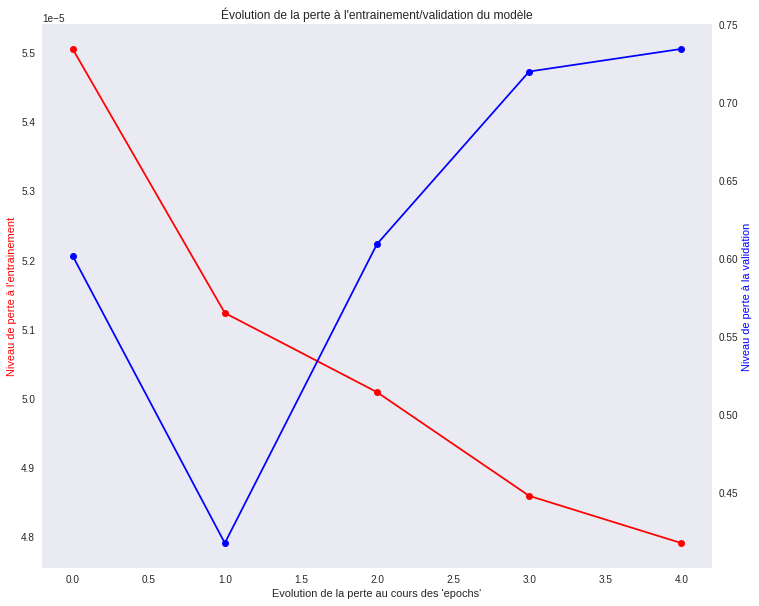

In [71]:
history_first_model = training_model.history

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(12,10))
ax2 = ax1.twinx()
ax1.plot(history_first_model['loss'], c='r', marker='o') # doit diminuer progressivement durant l'apprentissage
ax2.plot(history_first_model['val_loss'], c='b', marker='o') # doit diminuer, mais peu repartir à la hausse en cas d'overfitting

ax1.set_xlabel("Evolution de la perte au cours des 'epochs'")
ax1.set_ylabel('Niveau de perte à l\'entrainement', color='r')
ax2.set_ylabel('Niveau de perte à la validation', color='b')

ax1.grid(False)
ax2.grid(False)
plt.title("Évolution de la perte à l'entrainement/validation du modèle")
plt.show()

###### Evaluation sur le jeu de test

In [72]:
%%time
# A partir des meilleurs "weights" du modèle, on prédit notre classe sur les données test
first_model.load_weights(path + '/checkpoints/model_weights_w_beta_fixed.hdf5')

CPU times: user 10 ms, sys: 9.18 ms, total: 19.2 ms
Wall time: 17.7 ms


In [73]:
loss, state_full_binary_fbeta, fn, fp, tn, tp, precision, recall= first_model.evaluate(X_test_2.values, y_test_2.values, verbose=0)
print("loss:", round(loss, 3), " f_beta_score:", round(state_full_binary_fbeta, 3), "\n")
print("Tn:", int(tn), "Fp:", int(fp),"\nFn:", int(fn), " Tp:", int(tp), "\n")
print("Précision:", round(tp/(tp+fp), 2))
print("Sensibilité (Recall):", round(tp/(tp+fn), 2))
print("Spécificité:", round(tn/(tn+fp), 2))

loss: 0.416  f_beta_score: 0.318 

Tn: 5065 Fp: 589 
Fn: 312  Tp: 185 

Précision: 0.24
Sensibilité (Recall): 0.37
Spécificité: 0.9


In [62]:
%%script echo skipping
# https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
save_model(
    first_model,
    path,
    include_optimizer=True,
    overwrite=True,
    # save_traces=True
)

skipping


In [104]:
%%script echo skipping
y_pred_first_model = np.argmax(first_model.predict(X_test_2.values), axis=-1)
print(y_pred_first_model)

skipping


### Stacking
Idée: La faiblesse d'un modèle peut être compensée par la performance d'un autre.<br />
- Avantages:
 - gain de performance
 - réduction de variance, création d'un modèle plus robuste pour la prédiction (binaire ici)
- Inconvénients:
 - Entraînement plus long et consommateur de ressources
 - Lenteur et consomme plus de ressources qu'un seul modèle

##### Je possède 4 modèles entraînés, il faut donc que je détermine le meilleur "meta modèle" à partir des possibilités de combinaisons des modèles disponibles
- Avec 4 modèles je doit donc tester les performances de 11 meta modèles différents:
    - 6 modèles pour des combinaisons de 2
    - 4 modèles pour des combinaisons de 3
    - 1 seul pour les 4

##### Chargement des modèles utilisés pour le dashboard

In [594]:
def load_model_for_stacking(model_name, gzip_comp=False):
    if gzip_comp:
        model_to_load = joblib.load(path + '/model_for_stacking/' + model_name + '.pkl.gz')
    else:
        model_to_load = joblib.load(path + '/model_for_stacking/' + model_name + '.pkl')
    return model_to_load

In [595]:
svc = load_model_for_stacking("svc_hyperopt_wo_smote_beta_1_8", gzip_comp=False)
cb = load_model_for_stacking("catboost_model")
xgb = load_model_for_stacking("xgb_12_hyperopt")
rfc = load_model_for_stacking("gs_rfc_std")

In [597]:
%%script echo skipping

print(svc, "\n")
print("catboost:", cb.get_params(), "\n")
print(xgb, "\n")
print("rfc:", rfc.best_params_)

Couldn't find program: 'echo'


In [598]:
# dictionnaire de listes de combinaisons de tuples candidats potentiels pour le stacking
base_models = {
    'combination_1':[('svc', svc), ('rfc', rfc)],
    'combination_2':[('svc', svc), ('xgb', xgb)],
    'combination_3':[('svc', svc), ('cb', cb)],
    'combination_4':[('rfc', rfc), ('xgb', xgb)],
    'combination_5':[('rfc', rfc), ('cb', cb)],
    'combination_6':[('xgb', xgb), ('cb', cb)],
    'combination_7':[('svc', svc), ('rfc', rfc), ('xgb', xgb)],
    'combination_8':[('svc', svc), ('rfc', rfc), ('cb', cb)],
    'combination_9':[('rfc', rfc), ('xgb', xgb), ('cb', cb)],
    'combination_10':[('xgb', xgb), ('cb', cb), ('svc', svc)],
    'combination_11':[('rfc', rfc), ('xgb', xgb), ('cb', cb), ('svc', svc)],
}

In [599]:
stacking_model_test = StackingClassifier(
    estimators = base_models['combination_5'],
    final_estimator = LogisticRegressionCV(
        solver='saga',  # -> ElasticNet changé car 'lbfgs' ne converge pas...
        max_iter=100  # 100 par défaut -> convergence
    ),  # utilise la cross validation pour déterminer C
    passthrough=True,  # entraînement sur données d'origine pris en compte
    cv=3,
    verbose=1,
    n_jobs=2
)

In [600]:
# Beta = 2 est possible pour l'ensemble des modèles sans dégradation de résultats
f_2_scorer = make_scorer(fbeta_score, beta=2)

def evaluate_model(model, X, y):
    #cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
    #scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, verbose=2, n_jobs=2, error_score='raise')
    model.fit(X, y)
    y_pred_stack = model.predict(X_test_2)
    print("f beta score sur le jeu de test: {}".format(fbeta_score(y_test_2, y_pred_stack, average='binary', beta=2)))
    print("Accuracy sur le jeu de test: {}".format(model.score(X_test_2, y_test_2)))
    cm_stacked = confusion_matrix(y_test_2, y_pred_stack)
    print(cm_stacked)
    print(classification_report(y_test_2, y_pred_stack))
    return

In [ ]:
%%time
evaluate_model(stacking_model_test, X_train_2, y_train_2)

Note : L'évaluation des modèles par stacking a été abandonnée car cela nécessite une puissance et un temps de calcul trop important pour réaliser une évaluation complète.